<a href="https://colab.research.google.com/github/sunilvengalil/concept_learning/blob/master/notebooks/experiment_100_gmm_prob_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/concept_learning/concept_learning

Mounted at /content/gdrive
/content/gdrive/MyDrive/concept_learning/concept_learning


In [3]:
!pwd

/content/gdrive/MyDrive/concept_learning/concept_learning


In [4]:
!git pull

Already up to date.


In [4]:
env = "colab"

In [5]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model, get_train_val_iterator,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution, compute_distance_level_2
from PIL import Image


%matplotlib inline


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

# Set experiment parameters

In [7]:
z_dim = 10
run_id = 3
num_units=[64, 128, 32]
create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW
experiment_name = "experiment_100_gmm_prob"
base_path = "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3"


In [8]:
clean_up_previous_run = False
if env == "sunil_local":
    root_path = "/Users/sunilv/concept_learning_exp"
elif env == "colab":
    root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"
    # if clean_up_previous_run :
    #     rm -rf 
# !rm -rf /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3

In [9]:
experiment_name = "experiment_100_gmm_prob"
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              z_dim=z_dim,
                              num_units=num_units,
                              num_cluster_config=num_cluster_config,
                              confidence_decay_factor=run_id,
                              beta=5,
                              supervise_weight=150,
                              dataset_name="mnist",
                              split_name="Split_1",
                              model_name="VAE",
                              batch_size=64,
                              eval_interval_in_epochs=1,
                              name=experiment_name,
                              num_val_samples=128,
                              total_training_samples=60000,
                              manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                              reconstruction_weight=1,
                              activation_hidden_layer="RELU",
                              activation_output_layer="SIGMOID",
                              learning_rate = 1e-3
                              )
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name
model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST


In [10]:
K = exp_config.confidence_decay_factor
def convert_distance_to_confidence_exp(dist):
    return np.exp(-1 / K * dist)

def get_distance_exp(confidence):
    return -K * log(confidence)

def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))


In [11]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [10]:
num_epochs = 2
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                                                                     root_path=root_path,
                                                                                     z_dim=z_dim,
                                                                                     run_id=run_id,
                                                                                     create_split=create_split,
                                                                                     num_epochs=num_epochs,
                                                                                     num_epochs_completed=0,
                                                                                     num_cluster_config=num_cluster_config,
                                                                                     model_type=model_type
                                                                                    )
tf.reset_default_graph()

NameError: ignored

In [12]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= dao,
                                                 exp_config= exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=exp_config.split_name)

Warning /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/analysis/manual_annotation.csv path does not exist. Creating random prior with uniform distribution
Total Manual annotation confidence 0.0


# Load the trained model

In [13]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=model_type,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_m

# Read the latent vectors for train data

In [14]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names, _ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=3 z_min=-4.196731 z_max=5.2463045
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [15]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 2.0


# Use Elbow method to to find out number of optimum clusters k

In [18]:
# kmeans_model = KMeans()
# visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

# visualizer.fit(latent_vectors)  
# visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [16]:
# if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
#     num_clusters = visualizer.elbow_value_
# else:
#     num_clusters = 2 * visualizer.elbow_value_
# if num_clusters < 10:
#     num_clusters = 10
# print(f"Number of clusters {num_clusters}")
num_clusters=10

In [17]:
from sklearn.mixture import GaussianMixture
from clearn.dao.idao import IDao

def decode_latent_vectors(model_type: str,
                          cluster_centers: np.ndarray,
                          exp_config: ExperimentConfig,
                          dao: IDao):
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao, exp_config, model_type, num_epochs=0, sess=sess)
        z = np.zeros([cluster_centers.shape[0], exp_config.Z_DIM])
        for i in range(cluster_centers.shape[0]):
            z[i, :] = cluster_centers[i]
        decoded_images = decode(model, z, exp_config.BATCH_SIZE)
        return decoded_images

    
def cluster_and_decode_latent_vectors_gmm(model_type: str,
                                          num_clusters: int,
                                          latent_vectors: np.ndarray,
                                          exp_config: ExperimentConfig,
                                          dao: IDao):
    gm = GaussianMixture(n_components=num_clusters, random_state=0)
    cluster_labels = gm.fit_predict(latent_vectors)
    cluster_centers = gm.means_
    decoded_images = decode_latent_vectors(model_type, cluster_centers, exp_config, dao)
    posterior = gm.predict_proba(latent_vectors)

    return decoded_images, cluster_centers, cluster_labels, posterior


In [18]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
tf.reset_default_graph()
if  not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])
    posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])   
   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [22]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [6, 0, -1, 3,
                                               -1, 1, -1, 7,
                                               8, 2
                                              ]
    manual_annotation_json["manual_confidence"] = [0.8, 0.8, 0, 0.8,
                                                   0, 1, 0, 0.8,
                                                   0.8, 0.8
                                                  ]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    manual_annotation_json["posterior_proba"] = posterior_proba.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [19]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [20]:
cluster_group_dict = get_cluster_groups(manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [21]:
cluster_group_dict

{None: <clearn.analysis.ClusterGroup at 0x7fb300038190>,
 'good_clusters': <clearn.analysis.ClusterGroup at 0x7fb3002b7850>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fb30002fcd0>}

In [22]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


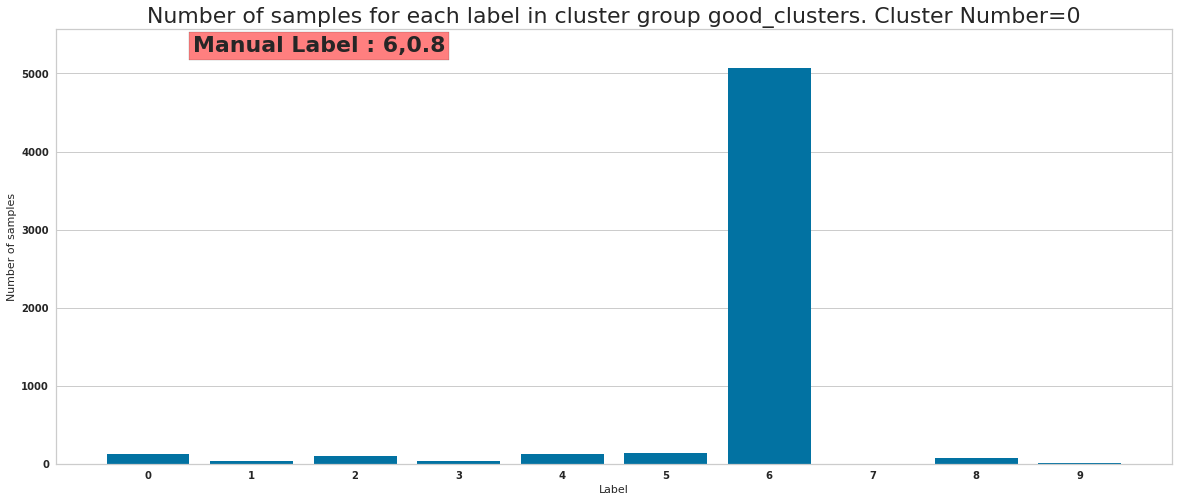

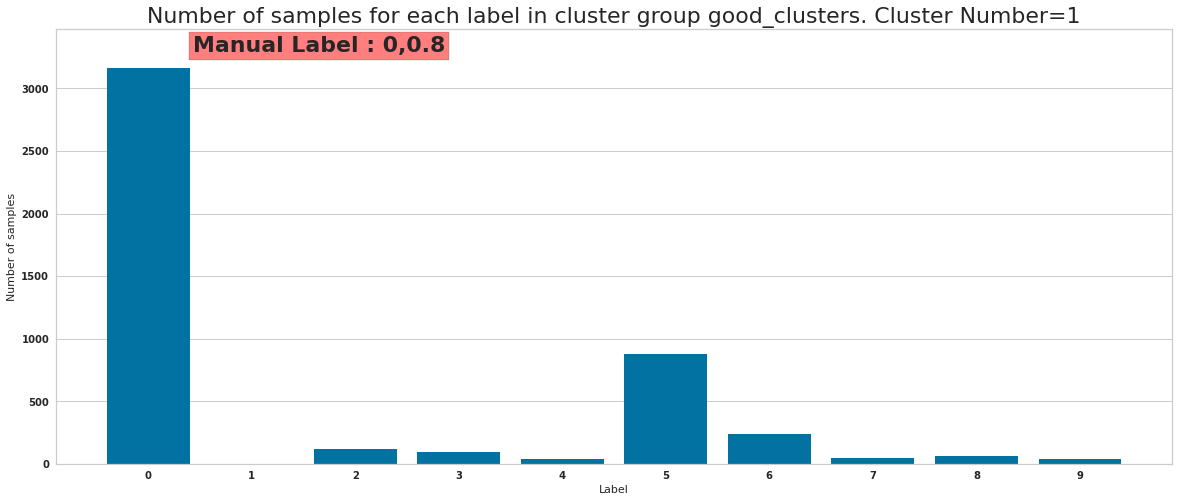

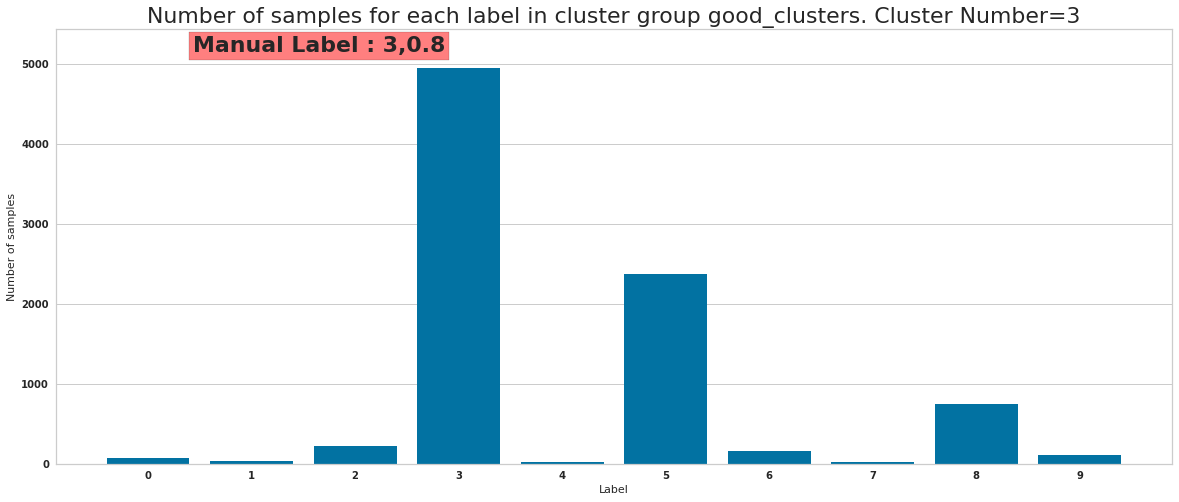

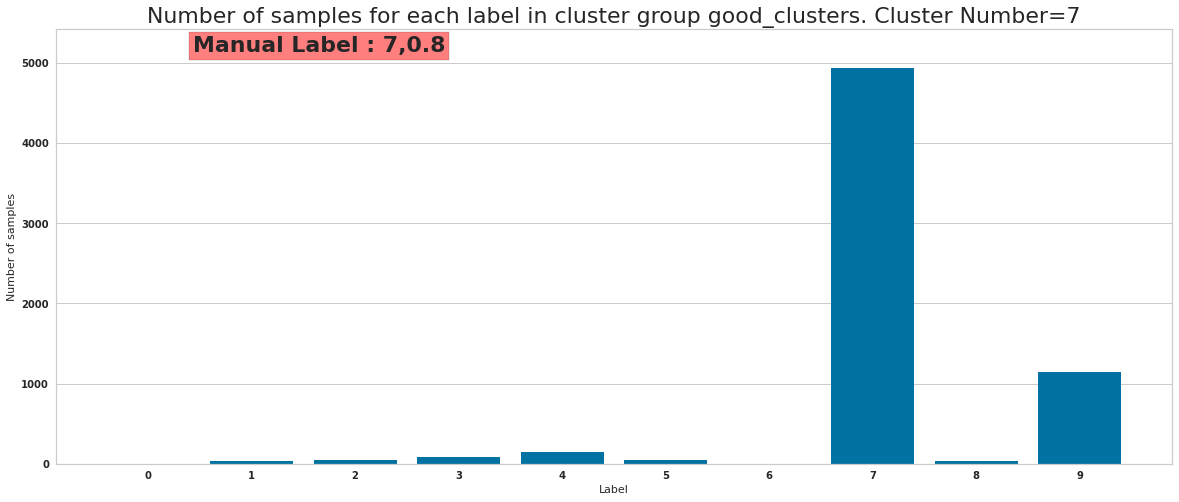

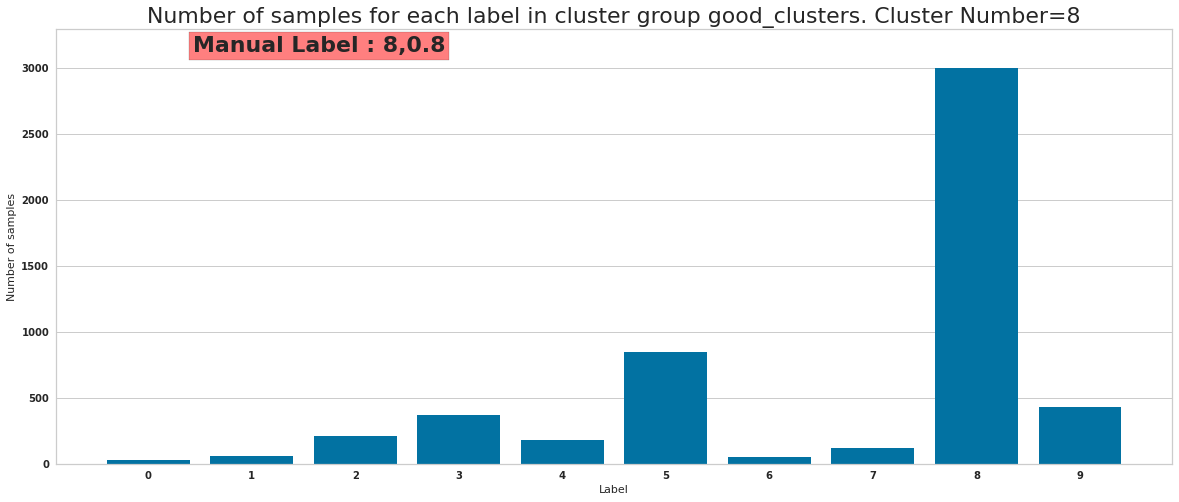

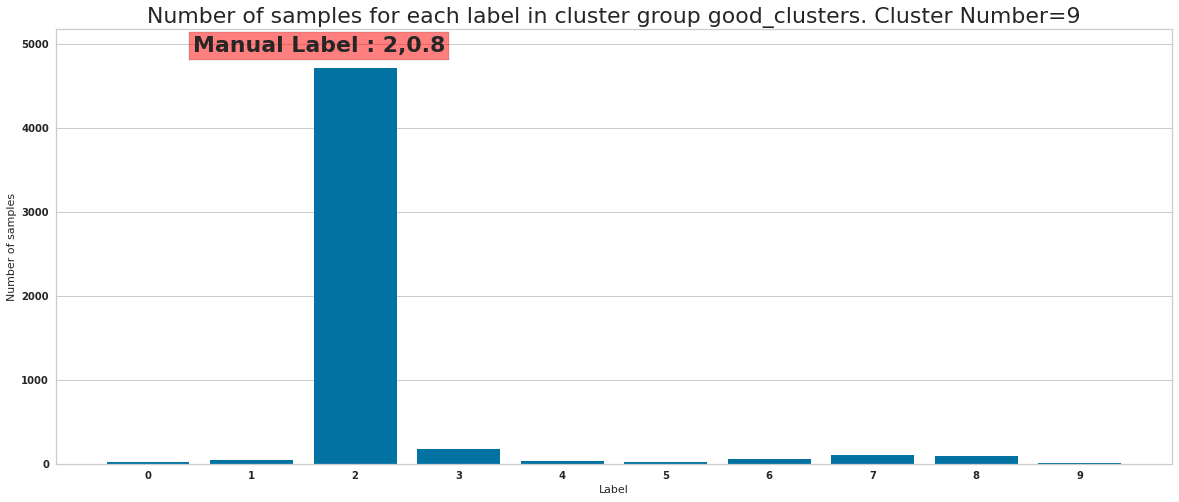

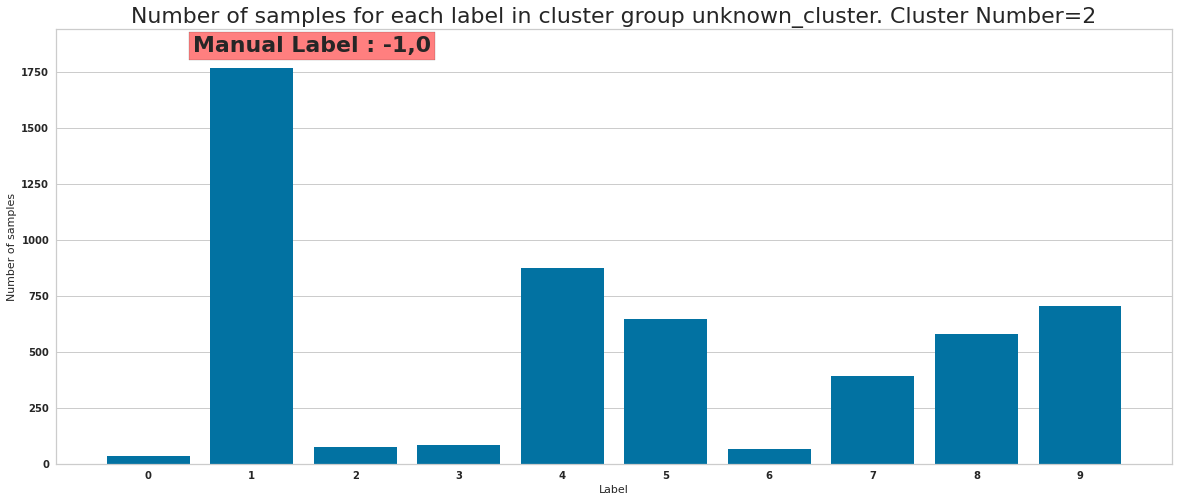

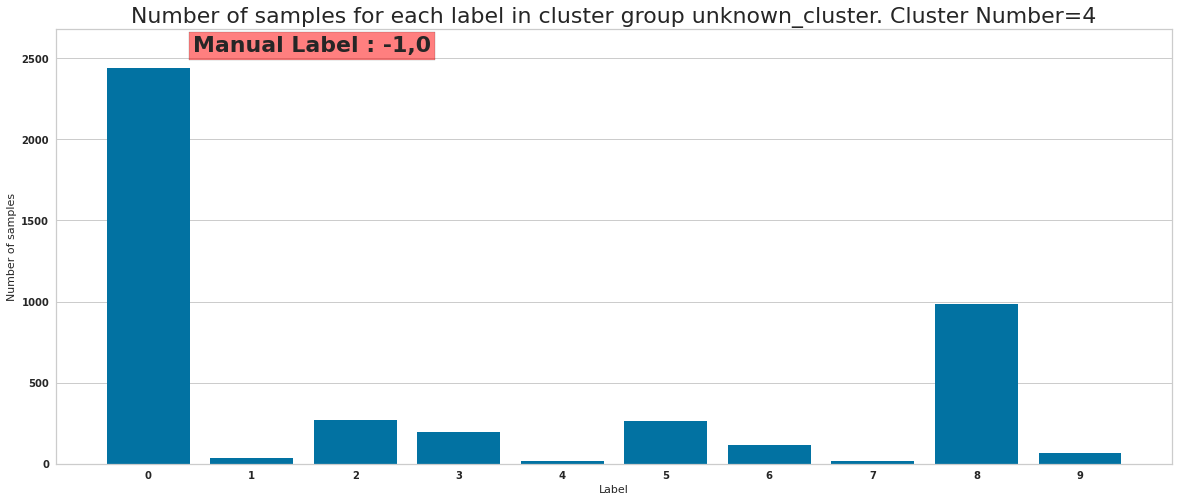

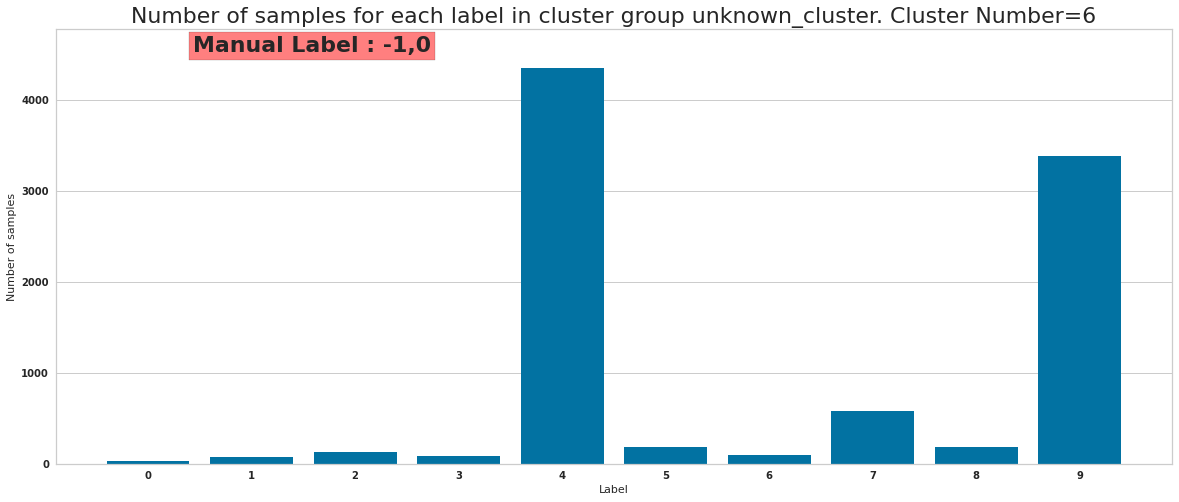

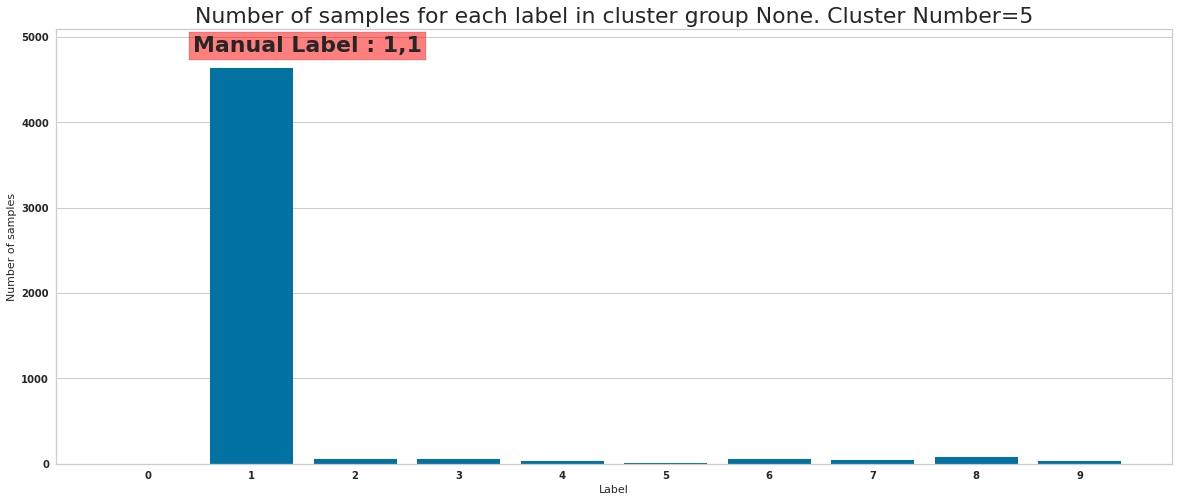

In [23]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [24]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5730, 10)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(4670, 10)
(5228, 10)
(8702, 10)
(4402, 10)
(5004, 10)
(9083, 10)
(6474, 10)
(5288, 10)
(5259, 10)


In [25]:
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

Posterior probability shape (59840, 10)


In [26]:
df.head()

,label,label_predicted,mu_0,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,mu_8,mu_9,sigma_0,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7,sigma_8,sigma_9,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,cluster_level_1,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,distance_9,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,confidence_6,confidence_7,confidence_8,confidence_9
0,4,0,0.757074,-0.504941,-0.283510,-0.810968,-0.918412,-0.334419,-0.511586,1.299259,0.437654,-0.342151,0.302773,0.893345,0.987151,0.502586,0.271065,0.685452,0.906082,0.493492,0.280848,0.548274,0.970723,0.445043,1.305916,-1.299170,-1.308483,-0.572397,-0.512006,0.797789,0.385790,-0.621227,6,100000.0,100000.0,100000.000000,100000.0,100000.00000,100000.000000,2.953179,100000.0,100000.0,100000.000000,3.558931e-10,9.633353e-07,0.135472,6.417885e-09,7.282181e-08,1.627949e-14,8.458035e-01,1.678489e-02,9.260846e-04,1.012212e-03
1,3,7,1.757622,0.477522,0.056621,0.129049,0.420775,-0.009047,-0.498852,-0.894153,0.825061,1.164327,0.321442,0.853805,0.958313,0.528278,0.246012,0.514625,0.849562,0.515842,0.246020,0.423463,1.679827,1.904752,2.633042,0.529416,0.674585,-0.620742,-0.938838,-0.372641,1.069456,1.148040,2,100000.0,100000.0,4.401944,100000.0,100000.00000,100000.000000,100000.000000,100000.0,100000.0,100000.000000,4.818936e-10,1.262249e-06,0.780219,3.903120e-02,1.424023e-01,1.867566e-06,3.721896e-08,5.857423e-03,3.247128e-02,1.540840e-05
2,1,3,-0.888461,0.164536,0.010532,-0.057828,0.551803,0.013882,-0.008259,-0.026928,2.112153,-0.013040,0.253242,1.054944,0.975057,0.758484,0.322376,0.855587,0.977775,0.739248,0.440306,0.783871,-1.019741,1.103335,-0.610234,1.494859,0.238962,-0.693736,-1.219410,-0.071478,2.542235,-0.864359,5,100000.0,100000.0,100000.000000,100000.0,100000.00000,3.746971,100000.000000,100000.0,100000.0,100000.000000,1.910221e-06,2.040471e-08,0.026606,6.516584e-07,1.281719e-06,9.641600e-01,1.586130e-03,6.513973e-03,1.129681e-03,1.366935e-11
3,2,7,-0.049631,-0.328641,-0.070279,-0.142961,1.614936,-0.464888,-0.082109,-0.129700,0.535664,0.789830,0.253111,0.823048,0.935757,0.504155,0.375977,0.617748,0.837599,0.610181,0.244051,0.518229,0.026857,0.542838,0.000430,0.701402,1.965629,-0.482534,-2.211080,0.609893,0.463563,1.372863,4,100000.0,100000.0,100000.000000,100000.0,4.47936,100000.000000,100000.000000,100000.0,100000.0,100000.000000,2.070255e-03,1.112101e-05,0.029554,2.843762e-01,3.945781e-01,1.524312e-02,6.028707e-08,3.962744e-07,2.381244e-01,3.604191e-02
4,2,6,1.739677,-0.321339,0.073765,-1.608149,1.321984,0.018958,-0.380135,0.631111,-0.590849,0.062772,0.312119,0.677409,0.883552,0.347638,0.310488,0.490120,0.708101,0.526202,0.220657,0.391285,1.508143,0.726113,0.999851,-1.398913,1.383590,0.109123,1.307352,-0.058291,-0.894174,-0.169998,9,100000.0,100000.0,100000.000000,100000.0,100000.00000,100000.000000,100000.000000,100000.0,100000.0,3.172549,4.443668e-05,2.046237e-02,0.002047,1.169749e-03,7.035859e-04,1.163873e-13,1.791585e-06,7.414499e-09,3.356759e-07,9.755712e-01


In [27]:
def validate_tokenize_int(lbl, length):
  print(f"Parsing manual entry {lbl}")
  lbls = lbl.split(",")
  if len(lbls) != length :
    raise Exception(f"Enter a text with {length} comma separated integers in the range of [0,9] or -1. -1 for unknown label")
  return [int(l) for l in lbls]

def validate_tokenize_float(lbl, length):
  print(f"Parsing manual entry {lbl}")
  lbls = lbl.split(",")
  if len(lbls) != length :
    raise Exception(f"Enter a text with {length} comma separated integers in the range of [0,9] or -1. -1 for unknown label")
  return [float(l) for l in lbls]

In [28]:
def display_cluster_center_images(decoded_images,
                                  image_filename,
                                  cluster_centers
                                  ):
    colormap = "Greys"
    fig = plt.figure()
    fig.tight_layout()
    num_cols = 4
    num_clusters = cluster_centers.shape[0]
    num_rows = math.ceil(num_clusters / num_cols)
    # fig.suptitle(
    #     f"Decoded Cluster Centers. \nClustered the latent vectors of training set N_3={exp_config.num_units[2]}"
    #     f" z_dim={exp_config.Z_DIM} run_id={run_id + 1}")
    for i in range(cluster_centers.shape[0]):
        ax = fig.add_subplot(num_rows, num_cols, i + 1)
        ax.imshow(np.squeeze(decoded_images[i]), cmap=colormap)
    plt.savefig(image_filename,
                bbox="tight",
                pad_inches=0)
    plt.show()

In [113]:
from pandas import DataFrame
from typing import Dict
def cluster_next_level_gmm(exp_config: ExperimentConfig,
                       df: DataFrame,
                       cluster_column_name_2,
                       cluster_labels,
                       model_type,
                       epochs_completed,
                       dao: IDao,
                       cluster_group_dict: Dict[str, ClusterGroup],
                       cluster_type="unknown_cluster"
                       ):
    _, _, z_col_names,_  = get_latent_vector_column(exp_config.Z_DIM)
    level2_manual_annotations = dict()
    if cluster_type in cluster_group_dict.keys():
        df[cluster_column_name_2] = -1
        tf.reset_default_graph()
        for cluster in cluster_group_dict[cluster_type]:
            print(cluster.id)
            _indices = np.where(cluster_labels == cluster.id)
            _df = df.iloc[_indices]

            _latent_vectors = _df[z_col_names].values
            tf.reset_default_graph()
            _decoded_images, _cluster_centers, _cluster_labels, posterior_proba_level_2 = cluster_and_decode_latent_vectors_gmm(
                model_type,
                10,
                _latent_vectors,
                exp_config,
                dao
            )
            df[cluster_column_name_2].iloc[_indices] = _cluster_labels
            print(posterior_proba_level_2.shape, _cluster_labels.shape)
            for i in range(10):
              __indices = np.where((cluster_labels == cluster.id) &
                    (df[cluster_column_name_2].values == i) )[0]

              df[f"confidence_level_2_{cluster.id}_{i}"].iloc[_indices] = posterior_proba_level_2[:, i] 
            
            image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}_cluster_id_{cluster.id}.png"

            display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)
            # class_labels = widgets.Text(place_holder="-1,-1,-1,-1,-1,-1,-1,-1,-1,-1",
            #     description="Labels")
            # display(class_labels)
            #labels_input = input("Enter the labels in above text box")
            #print(validate_tokenize(labels_input, 10))

            # confidence_input = input("Enter the confidence in above text box")
            #print(validate_tokenize(confidence_input, 10))


            level_2_cluster_dict = dict()
            level_2_cluster_dict["cluster_centers"] = _cluster_centers.tolist()
            level_2_cluster_dict["cluster_labels"] = _cluster_labels.tolist()
            level_2_cluster_dict["posterier_prob"] = posterior_proba_level_2.tolist()
            #level_2_cluster_dict["manual_labels"] = validate_tokenize_int(labels_input, 10)
            #level_2_cluster_dict["manual_confidences"] = validate_tokenize_float(confidence_input, 10)

            level2_manual_annotations[cluster.id] = level_2_cluster_dict

    return level2_manual_annotations


2
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/content/gdrive/

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

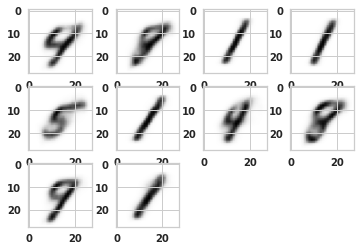

4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/content/gdrive/

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

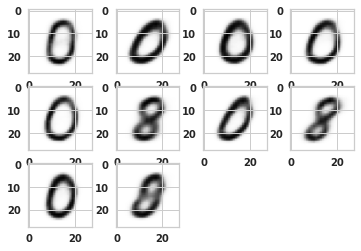

6
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-1871"
all_model_checkpoint_paths: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_100_gmm_prob/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/content/gdrive/

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

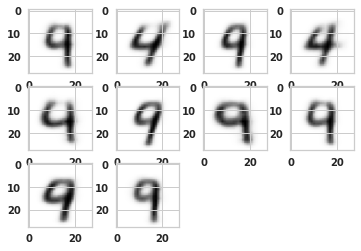

In [115]:
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

In [116]:
# class_labels = widgets.Text(place_holder="-1,-1,-1,-1,-1,-1,-1,-1,-1,-1",
#     description="Labels")
# display(class_labels)

In [117]:
# validate_tokenize(class_labels.value, 10)

In [118]:
[k for k in level2_manual_annotations.keys()]

[2, 4, 6]

In [116]:
# from ipywidgets import widgets
# btb = widgets.BoundedIntText(
#  value=7,
#  min=0,
#  max=10
#  )
# display(btb)

BoundedIntText(value=7, max=10)

In [118]:
# class_labels = widgets.Text(place_holder="-1-1-1-1",
#                             description="Labels")

In [120]:
# display(class_labels)

Text(value='', description='Labels')

In [142]:
# labels_1 = validate_tokenize(class_labels.value, 4)

In [143]:
# labels_1

[-1, -1, -1, -1]

In [119]:
level_2_cluster_dict = level2_manual_annotations[2]
level_2_cluster_dict["manual_labels"] = [
                                         -1, -1, 1, 1,
                                         -1, 1, -1, -1,
                                         9, 1
                                        ]
level_2_cluster_dict["manual_confidences"] = [0, 0, 1, 1,
                                              0, 1, 0, 0,
                                              0.6, 1
                                              ]

level_2_cluster_dict = level2_manual_annotations[4]
level_2_cluster_dict["manual_labels"] = [0, 0, 0, 0,
                                         0,8,0, 8,
                                         0, -1]

level_2_cluster_dict["manual_confidences"] = [1, 1, 1, 1,
                                              1, 1, 1, 1,
                                              1, 0
                                             ]


level_2_cluster_dict = level2_manual_annotations[6]
level_2_cluster_dict["manual_labels"] = [-1, 4, -1, 4,
                                        -1, 9, 9, -1,
                                        9, 9
                                         ]
level_2_cluster_dict["manual_confidences"] = [0, 0.8, 0, 0.8,
                                              0, 0.8, 0.8, 0,
                                              0.8, 0.8
                                             ]


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [9, -1,-1,-1,
#                                         9,-1,-1,9,
#                                         9,-1]

# level_2_cluster_dict["manual_confidences"] = [0.7, 0.7, 0.7, 0.7,
#                                               0.7,0.7,0.7,0.7,
#                                               0.7,0.7
#                                              ]

# level2_manual_annotations[7] = level_2_cluster_dict



# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1,-1,-1,
#                                         -1,-1,0,-1,
#                                         -1,0]

# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0.9,0,
#                                               0,0.9
#                                              ]

# level2_manual_annotations[7] = level_2_cluster_dict



# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [8,8,3,8,
#                                         3,3,8,-1,
#                                         -1,-1]

# level_2_cluster_dict["manual_confidences"] = [0.8,0.8,0.7,0.8,
#                                               0.7, 0.7, 0.8, 0,
#                                               0,0
#                                              ]

# level2_manual_annotations[8] = level_2_cluster_dict


level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"level_2_manual_annotation_epoch_{epochs_completed}.json")

with open(level_2_manual_annotation_file_json, "w") as json_file:
    json.dump(level2_manual_annotations, json_file)


In [120]:
print("Setting  next_level_clusters attribute to each primary cluster")
for cluster_id in level2_manual_annotations.keys():
    _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
    _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

print("Computing distances from second level cluster centers")
for cluster_id in level2_manual_annotations.keys():
    _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
    _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

    print(cluster_id)

    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster, cluster_column_name_2)

2
4
6


In [122]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [123]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [124]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [125]:
def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       assign_only_correct=False,
                                       estimate_type="distance_function"
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        if estimate_type == "distance_function":
            _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
            dst = _distance_df.iloc[_indices]
            _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
            _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        elif estimate_type == "map":
            _confidence_df = df[f"confidence_level_2_{cluster.id}_{_cluster.id}"]
            _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * _confidence_df.iloc[_indices]
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0
    num_individual_samples_annotated = 0
    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _confidence_df = df[f"confidence_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label

                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)
            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")

            if estimate_type == "distance_function":
                distance_df = df["distance_{}".format(annotate_cluster)]
                dist = distance_df.iloc[indices]
                df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
                df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
            elif estimate_type == "map":
                confidence_df = df["confidence_{}".format(annotate_cluster)]
                df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * confidence_df.iloc[indices]
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
        else:
            print("unknown")
            # TODO second level clustering is not used now so commenting the code
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(type(cluster.next_level_clusters))
            print(list(cluster.next_level_clusters.keys()))
            print(cluster.id)

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    print(f"Second level cluster id {_cluster.id}")
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Label all the ~600 samples in the second level cluster
                        indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                           & (df[cluster_column_name_2].values == _cluster.id))[0]
                        print(f"Annotating individual samples {indices.shape}")
                        num_individual_samples_annotated += indices.shape[0]
                        df["manual_annotation"].iloc[indices] = df["label"][indices].values
                        df["manual_annotation_confidence"].iloc[indices] = 1
                        if estimate_type =="distance_function":
                            _dist = _distance_df.iloc[indices]
                            df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)
        print("********************************")

    return num_individual_samples_annotated

In [126]:
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Manual Label 6
(5730, 117) (5730, 33)
Num correct=5064
Cluster 0 Manual Label 6 Percentage correct 88.37696335078535
********************************
Manual Label 0
(4670, 117) (4670, 33)
Num correct=3159
Cluster 1 Manual Label 0 Percentage correct 67.64453961456103
********************************
unknown
<class 'dict'>
['unknown_cluster', None, 'average_clusters']
2
Second level cluster id 0
********-1*******
Annotating individual samples (691,)
Second level cluster id 1
********-1*******
Annotating individual samples (472,)
Second level cluster id 4
********-1*******
Annotating individual samples (444,)
Second level cluster id 6
********-1*******
Annotating individual samples (538,)
Second level cluster id 7
********-1*******
Annotating individual samples (405,)
Second level cluster id 2
********1*******
Manual_label 1
Second level cluster id 3
********1*******
Manual_label 1
Second level cluster id 5
********1*******
Manual_label 1
Second level cluster id 9
********1*******
Manual_

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

Annotating individual samples (593,)
Second level cluster id 1
********4*******
Manual_label 4
Second level cluster id 3
********4*******
Manual_label 4
Second level cluster id 5
********9*******
Manual_label 9
Second level cluster id 6
********9*******
Manual_label 9
Second level cluster id 8
********9*******
Manual_label 9
Second level cluster id 9
********9*******
Manual_label 9
********************************
Manual Label 7
(6724, 117) (6474, 33)
Num correct=5181
Cluster 7 Manual Label 7 Percentage correct 77.0523497917906
********************************
Manual Label 8
(7076, 117) (5288, 33)
Num correct=4337
Cluster 8 Manual Label 8 Percentage correct 61.291690220463536
********************************
Manual Label 2
(5389, 117) (5259, 33)
Num correct=4838
Cluster 9 Manual Label 2 Percentage correct 89.77546854704026
********************************
Total number of individual samples annotated 6226


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [127]:
num_individual_samples_annotated

6226

# Save the dataframe with manual annotations

In [128]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5730., 4670., 5228., 8702., 4402., 5004., 9083., 6474., 5288.,
        5259.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

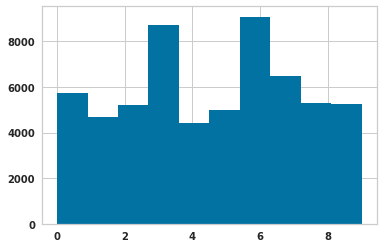

In [129]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [130]:
from clearn.analysis.cluster_utils import plot_distance_distribution

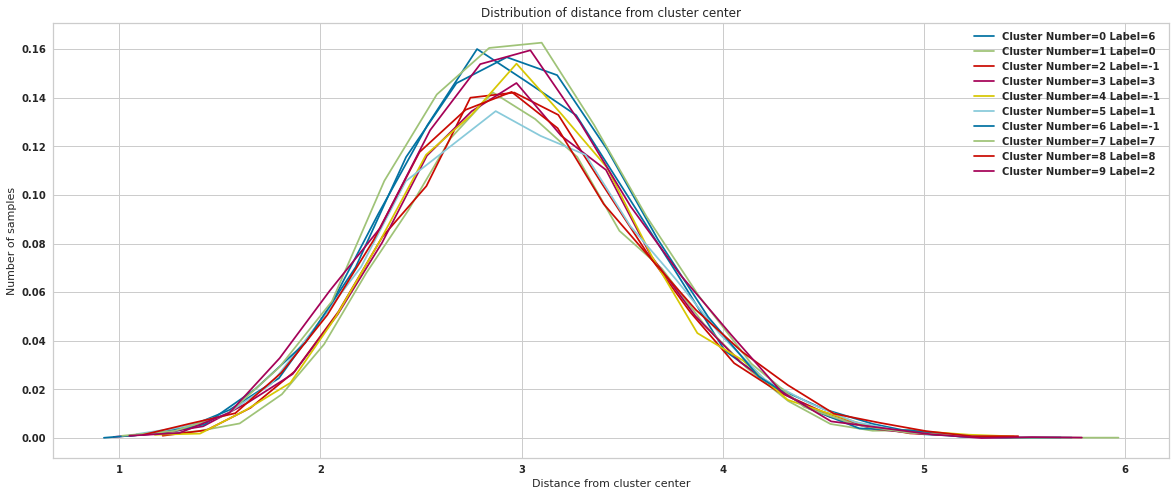

In [131]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

In [132]:
def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1

In [133]:
df1 = df[df["manual_annotation_confidence"] > 0.1]
print(df1.shape)


(59840, 117)


In [134]:
df.columns
cols = [f"confidence_{i}" for i in range(num_clusters)]
cols.append("manual_annotation_confidence")

In [135]:
df[ (df["manual_annotation"] == 6) & (df["cluster_level_1"] == 0)][cols].head()


,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,confidence_6,confidence_7,confidence_8,confidence_9,manual_annotation_confidence
16,0.415229,0.002914,4.843505e-02,6.873942e-02,0.029666,8.027155e-02,0.242976,7.814077e-03,1.039549e-01,3.042828e-07,0.332183
24,0.759865,0.219588,5.434894e-12,1.671958e-07,0.013617,1.152514e-16,0.005011,1.305790e-08,1.309224e-07,1.918007e-03,0.607892
28,0.980937,0.006010,7.314972e-03,1.794850e-03,0.002204,4.372827e-04,0.001223,3.803688e-06,6.402108e-05,1.068199e-05,0.784750
31,0.989536,0.000005,5.395670e-06,6.849252e-03,0.003370,1.581165e-04,0.000002,1.827023e-11,7.506045e-05,3.298845e-07,0.791629
33,0.760845,0.040587,1.245234e-05,3.789615e-03,0.000010,1.349581e-03,0.019470,2.504007e-06,1.118454e-03,1.728155e-01,0.608676


In [136]:
df["manual_annotation_confidence"].describe()

count    59840.000000
mean         0.701512
std          0.196726
min          0.155865
25%          0.552127
50%          0.743386
75%          0.799015
max          1.000000
Name: manual_annotation_confidence, dtype: float64

Text(0, 0.5, 'Percentage Correct')

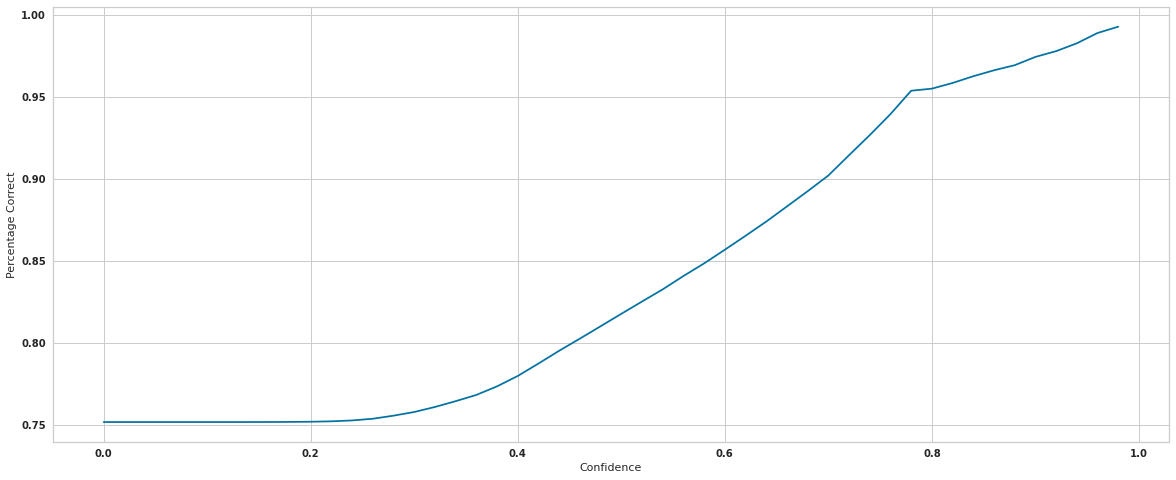

In [137]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

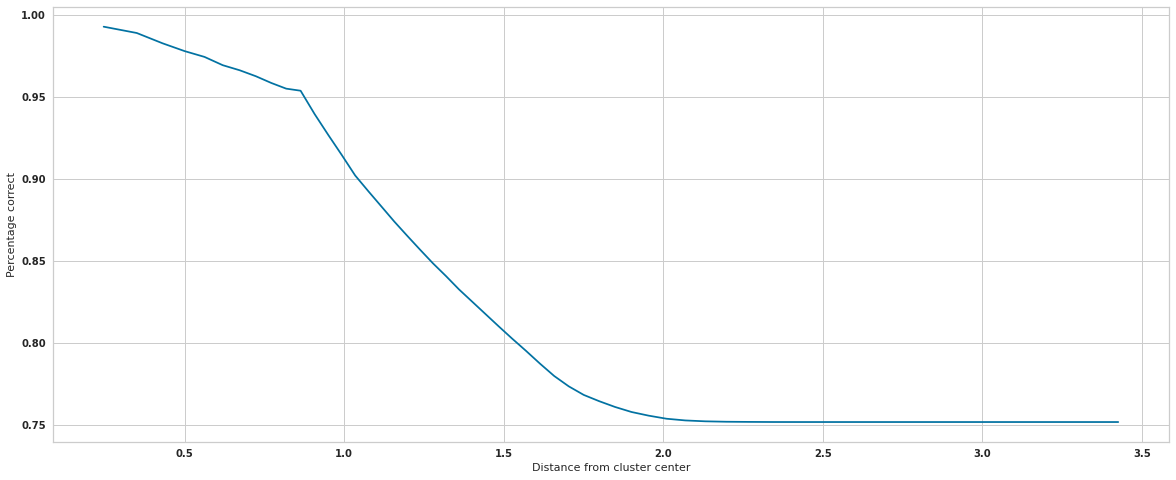

In [138]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [139]:
from shutil import copy2

In [140]:
num_epochs = 2

In [141]:
epochs_completed

2.0

In [142]:
from typing import List

def get_manual_annotation_col_name(epochs_completed):
    epoch_col_confidence = f"manual_confidence_{int(epochs_completed)}"
    epoch_col_label = f"manual_label_{int(epochs_completed)}"
    return epoch_col_confidence, epoch_col_label

def get_overall_confidence(row, epochs_competed:List[int]):
    if len(epochs_competed) == 1:
        epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_competed[0])
        return row[epoch_col_confidence]
    else:
        confidences = [row[get_manual_annotation_col_name(epoch)[0]] for epoch in epochs_competed]
        if max(confidences) == 1:
            return 1
        else:
            return confidences[-1]


def get_overall_label(row, epochs_competed:List[int]):
    if len(epochs_competed) == 1:
        epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_competed[0])
        return row[epoch_col_label]
    else:
        confidences = [row[get_manual_annotation_col_name(epoch)[0]] for epoch in epochs_competed]
        labels = [row[get_manual_annotation_col_name(epoch)[1]] for epoch in epochs_competed]

        # argmax of confidences
        max_index = max(enumerate(confidences), key=lambda x: x[1])[0]
        if confidences[max_index] == 1:
            return labels[max_index]
        else:
            return labels[-1]


In [143]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2


In [144]:
manual_annotation_df.shape

(59840, 4)

In [145]:
manual_annotation_df.head()

,manual_label_2,manual_confidence_2,manual_annotation,manual_annotation_confidence
0,4.0,0.361670,4.0,0.361670
1,3.0,1.000000,3.0,1.000000
2,1.0,0.964160,1.0,0.964160
3,2.0,1.000000,2.0,1.000000
4,2.0,0.780457,2.0,0.780457


In [146]:
df.head()

,label,label_predicted,mu_0,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,mu_8,mu_9,sigma_0,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7,sigma_8,sigma_9,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,cluster_level_1,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,...,confidence_level_2_6_3,confidence_level_2_6_4,confidence_level_2_6_5,confidence_level_2_6_6,confidence_level_2_6_7,confidence_level_2_6_8,confidence_level_2_6_9,distance_level_2_2_0,distance_level_2_2_1,distance_level_2_2_2,distance_level_2_2_3,distance_level_2_2_4,distance_level_2_2_5,distance_level_2_2_6,distance_level_2_2_7,distance_level_2_2_8,distance_level_2_2_9,distance_level_2_4_0,distance_level_2_4_1,distance_level_2_4_2,distance_level_2_4_3,distance_level_2_4_4,distance_level_2_4_5,distance_level_2_4_6,distance_level_2_4_7,distance_level_2_4_8,distance_level_2_4_9,distance_level_2_6_0,distance_level_2_6_1,distance_level_2_6_2,distance_level_2_6_3,distance_level_2_6_4,distance_level_2_6_5,distance_level_2_6_6,distance_level_2_6_7,distance_level_2_6_8,distance_level_2_6_9,manual_annotation,manual_annotation_confidence,distance_to_confidence
0,4,0,0.757074,-0.504941,-0.283510,-0.810968,-0.918412,-0.334419,-0.511586,1.299259,0.437654,-0.342151,0.302773,0.893345,0.987151,0.502586,0.271065,0.685452,0.906082,0.493492,0.280848,0.548274,0.970723,0.445043,1.305916,-1.299170,-1.308483,-0.572397,-0.512006,0.797789,0.385790,-0.621227,6,100000.0,100000.0,100000.000000,100000.0,100000.00000,100000.000000,2.953179,...,4.520879e-01,0.000004,6.948493e-03,1.370504e-06,1.278947e-06,1.764292e-01,2.676692e-03,100000,100000,100000.0,100000.0,100000,100000.0,100000,100000,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000,100000,100000.0,100000,2.797461,100000,100000.0,100000.0,100000,100000.0,100000.0,4.0,0.361670,0.0
1,3,7,1.757622,0.477522,0.056621,0.129049,0.420775,-0.009047,-0.498852,-0.894153,0.825061,1.164327,0.321442,0.853805,0.958313,0.528278,0.246012,0.514625,0.849562,0.515842,0.246020,0.423463,1.679827,1.904752,2.633042,0.529416,0.674585,-0.620742,-0.938838,-0.372641,1.069456,1.148040,2,100000.0,100000.0,4.401944,100000.0,100000.00000,100000.000000,100000.000000,...,3.903120e-02,0.142402,1.867566e-06,3.721896e-08,5.857423e-03,3.247128e-02,1.540840e-05,100000,100000,100000.0,100000.0,100000,100000.0,100000,100000,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000,100000,100000.0,100000,100000.000000,100000,100000.0,100000.0,100000,100000.0,100000.0,3.0,1.000000,0.0
2,1,3,-0.888461,0.164536,0.010532,-0.057828,0.551803,0.013882,-0.008259,-0.026928,2.112153,-0.013040,0.253242,1.054944,0.975057,0.758484,0.322376,0.855587,0.977775,0.739248,0.440306,0.783871,-1.019741,1.103335,-0.610234,1.494859,0.238962,-0.693736,-1.219410,-0.071478,2.542235,-0.864359,5,100000.0,100000.0,100000.000000,100000.0,100000.00000,3.746971,100000.000000,...,6.516584e-07,0.000001,9.641600e-01,1.586130e-03,6.513973e-03,1.129681e-03,1.366935e-11,100000,100000,100000.0,100000.0,100000,100000.0,100000,100000,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000,100000,100000.0,100000,100000.000000,100000,100000.0,100000.0,100000,100000.0,100000.0,1.0,0.964160,0.0
3,2,7,-0.049631,-0.328641,-0.070279,-0.142961,1.614936,-0.464888,-0.082109,-0.129700,0.535664,0.789830,0.253111,0.823048,0.935757,0.504155,0.375977,0.617748,0.837599,0.610181,0.244051,0.518229,0.026857,0.542838,0.000430,0.701402,1.965629,-0.482534,-2.211080,0.609893,0.463563,1.372863,4,100000.0,100000.0,100000.000000,100000.0,4.47936,100000.000000,100000.000000,...,2.843762e-01,0.394578,1.524312e-02,6.028707e-08,3.962744e-07,2.381244e-01,3.604191e-02,100000,100000,100000.0,100000.0,100000,100000.0,100000,100000,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000,100000,100000.0,100000,100000.000000,100000,1000

In [153]:
#cols.append("cluster_level_2")
cols.append("manual_annotation")
df[cols].head()

,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,confidence_6,confidence_7,confidence_8,confidence_9,manual_annotation_confidence,cluster_level_2,manual_annotation
0,3.558931e-10,9.633353e-07,0.135472,6.417885e-09,7.282181e-08,1.627949e-14,8.458035e-01,1.678489e-02,9.260846e-04,1.012212e-03,0.361670,3,4.0
1,4.818936e-10,1.262249e-06,0.780219,3.903120e-02,1.424023e-01,1.867566e-06,3.721896e-08,5.857423e-03,3.247128e-02,1.540840e-05,1.000000,7,3.0
2,1.910221e-06,2.040471e-08,0.026606,6.516584e-07,1.281719e-06,9.641600e-01,1.586130e-03,6.513973e-03,1.129681e-03,1.366935e-11,0.964160,-1,1.0
3,2.070255e-03,1.112101e-05,0.029554,2.843762e-01,3.945781e-01,1.524312e-02,6.028707e-08,3.962744e-07,2.381244e-01,3.604191e-02,1.000000,9,2.0
4,4.443668e-05,2.046237e-02,0.002047,1.169749e-03,7.035859e-04,1.163873e-13,1.791585e-06,7.414499e-09,3.356759e-07,9.755712e-01,0.780457,-1,2.0


In [152]:
df[second_level_cols].head()

,confidence_level_2_6_0,confidence_level_2_6_1,confidence_level_2_6_2,confidence_level_2_6_3,confidence_level_2_6_4,confidence_level_2_6_5,confidence_level_2_6_6,confidence_level_2_6_7,confidence_level_2_6_8,confidence_level_2_6_9
0,4.381816e-04,3.608868e-01,0.000526,4.520879e-01,0.000004,6.948493e-03,1.370504e-06,1.278947e-06,1.764292e-01,2.676692e-03
1,4.818936e-10,1.262249e-06,0.780219,3.903120e-02,0.142402,1.867566e-06,3.721896e-08,5.857423e-03,3.247128e-02,1.540840e-05
2,1.910221e-06,2.040471e-08,0.026606,6.516584e-07,0.000001,9.641600e-01,1.586130e-03,6.513973e-03,1.129681e-03,1.366935e-11
3,2.070255e-03,1.112101e-05,0.029554,2.843762e-01,0.394578,1.524312e-02,6.028707e-08,3.962744e-07,2.381244e-01,3.604191e-02
4,4.443668e-05,2.046237e-02,0.002047,1.169749e-03,0.000704,1.163873e-13,1.791585e-06,7.414499e-09,3.356759e-07,9.755712e-01


In [150]:
second_level_cols = [f"confidence_level_{2}_{6}_{i}"  for i in range(10)]

In [151]:
manual_labels

[6, 0, -1, 3, -1, 1, -1, 7, 8, 2]

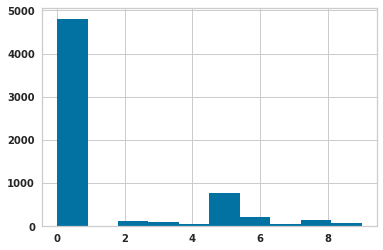

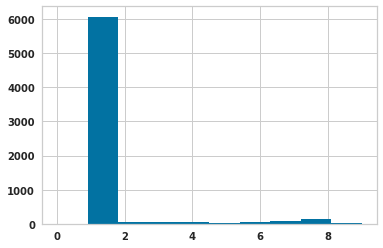

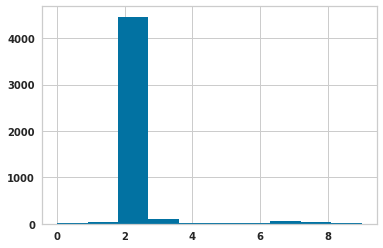

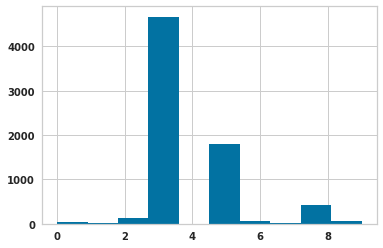

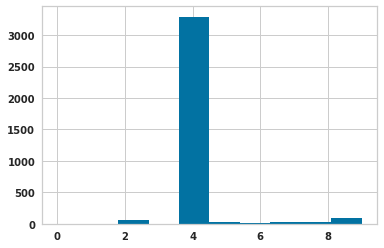

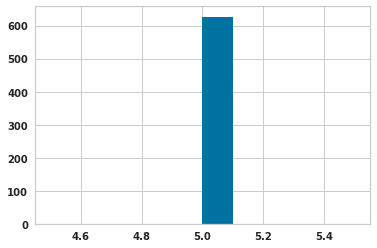

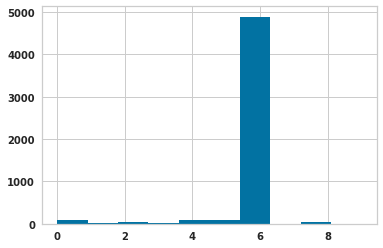

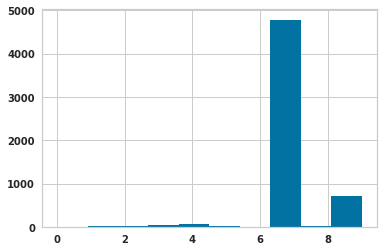

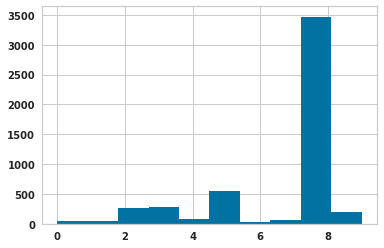

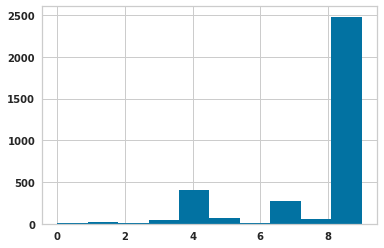

In [154]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 2

In [155]:
num_epochs

2

In [ ]:
def get_num_samples_wrongly_annotated():
    df1 = df[df["manual_annotation_confidence"] > 0]
    if df1.shape[0] >  0:
        df2 = df1[df1["manual_annotation"] != df1["label"]]        
        return df2.shape[0]
    else:
        return 0


In [ ]:
def get_sum_confidence_wrong():
    df1 = df[df["manual_annotation_confidence"] > 0]
    if df1.shape[0] >  0:
        df2 = df1[df1["manual_annotation"] != df1["label"]]        
        return df2["manual_annotation_confidence"].sum()
    else:
        return 0


# Get the number of samples annotated

In [ ]:
epochs_completed

2.0

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

,epoch,train_accuracy,val_accuracy,test_accuracy,train_reconstruction_loss,val_reconstruction_loss,test_reconstruction_loss
0,1,0.054646,0.03125,0.052384,136.726135,134.637161,135.946472
1,2,0.057821,0.06250,0.053586,127.913963,125.115356,127.054619


In [ ]:
num_individual_samples_annotated

10620

In [ ]:
num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()

,epoch,train_accuracy,val_accuracy,test_accuracy,train_reconstruction_loss,val_reconstruction_loss,test_reconstruction_loss,num_individual_samples_annotated,num_samples_wrongly_annotated,total_confidence_of_wrong_annotation
0,1,0.054646,0.03125,0.052384,136.726135,134.637161,135.946472,10620,13394,638.765225
1,2,0.057821,0.06250,0.053586,127.913963,125.115356,127.054619,10620,13394,638.765225


In [ ]:
confidence

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

In [ ]:
percentage_correct

array([0.77616979, 0.8109009 , 0.84111609, 0.86625887, 0.88796513,
       0.90687292, 0.92380062, 0.93971082, 0.95281103, 0.96242451,
       0.97099404, 0.9772783 , 0.98313802, 0.98711407, 0.99047199,
       0.9930095 , 0.99483228, 0.99661482, 0.99778944, 0.99814832,
       0.99888414, 0.99906716, 0.9992515 , 0.99962512, 0.99971844,
       0.99990603, 0.99990597, 0.99990594, 0.99990593, 0.99990591,
       0.9999059 , 0.99990588, 0.99990588, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [ ]:
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

# Start training for one more epoch

In [ ]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        root_path=root_path,
                                        learning_rate=5e-4,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs
                                        )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0005, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100'}
Loaded manual annotation
Number of samples with manual confidence 59840
Total Manual

Epoch: 2/61, Nll_loss : 123.86109924316406 KLD:7.762929916381836  Supervised loss:0.4451139569282532
Epoch: 2/62, Nll_loss : 128.755126953125 KLD:7.931044578552246  Supervised loss:0.41391658782958984
Epoch: 2/63, Nll_loss : 143.18682861328125 KLD:8.585527420043945  Supervised loss:0.36342212557792664
Epoch: 2/64, Nll_loss : 130.68670654296875 KLD:8.3919677734375  Supervised loss:0.28649502992630005
Epoch: 2/65, Nll_loss : 128.34457397460938 KLD:8.146469116210938  Supervised loss:0.4402309060096741
Epoch: 2/66, Nll_loss : 132.7514190673828 KLD:8.946460723876953  Supervised loss:0.30458658933639526
Epoch: 2/67, Nll_loss : 120.33329772949219 KLD:8.486825942993164  Supervised loss:0.3805086612701416
Epoch: 2/68, Nll_loss : 125.44033813476562 KLD:8.203744888305664  Supervised loss:0.4353359341621399
Epoch: 2/69, Nll_loss : 126.96316528320312 KLD:8.91334056854248  Supervised loss:0.2868448495864868
Epoch: 2/70, Nll_loss : 132.7515869140625 KLD:8.88150405883789  Supervised loss:0.33726638555

Epoch: 2/143, Nll_loss : 127.56022644042969 KLD:8.746307373046875  Supervised loss:0.16854965686798096
Epoch: 2/144, Nll_loss : 126.04800415039062 KLD:8.163503646850586  Supervised loss:0.16355176270008087
Epoch: 2/145, Nll_loss : 125.672607421875 KLD:8.22994327545166  Supervised loss:0.1744992583990097
Epoch: 2/146, Nll_loss : 130.45138549804688 KLD:7.678247928619385  Supervised loss:0.335479736328125
Epoch: 2/147, Nll_loss : 126.11632537841797 KLD:7.908821105957031  Supervised loss:0.3952418565750122
Epoch: 2/148, Nll_loss : 131.8212890625 KLD:8.087137222290039  Supervised loss:0.23899948596954346
Epoch: 2/149, Nll_loss : 136.59054565429688 KLD:8.055809020996094  Supervised loss:0.2504759728908539
Epoch: 2/150, Nll_loss : 128.09390258789062 KLD:7.7852044105529785  Supervised loss:0.24307900667190552
Epoch: 2/151, Nll_loss : 137.1239471435547 KLD:8.083927154541016  Supervised loss:0.2675493359565735
Epoch: 2/152, Nll_loss : 129.18075561523438 KLD:8.174660682678223  Supervised loss:0.2

Epoch: 2/224, Nll_loss : 134.27041625976562 KLD:7.699594497680664  Supervised loss:0.3002631664276123
Epoch: 2/225, Nll_loss : 137.473876953125 KLD:8.256126403808594  Supervised loss:0.22710484266281128
Epoch: 2/226, Nll_loss : 136.66586303710938 KLD:8.190645217895508  Supervised loss:0.2592197060585022
Epoch: 2/227, Nll_loss : 130.4632110595703 KLD:7.893590450286865  Supervised loss:0.24844807386398315
Epoch: 2/228, Nll_loss : 130.52870178222656 KLD:8.153913497924805  Supervised loss:0.15157738327980042
Epoch: 2/229, Nll_loss : 131.9267578125 KLD:8.760072708129883  Supervised loss:0.2406204491853714
Epoch: 2/230, Nll_loss : 126.71669006347656 KLD:9.097530364990234  Supervised loss:0.226645827293396
Epoch: 2/231, Nll_loss : 132.74208068847656 KLD:8.861978530883789  Supervised loss:0.2308577001094818
Epoch: 2/232, Nll_loss : 131.62548828125 KLD:9.260581970214844  Supervised loss:0.20411303639411926
Epoch: 2/233, Nll_loss : 121.85139465332031 KLD:8.902180671691895  Supervised loss:0.1902

Epoch: 2/306, Nll_loss : 125.61155700683594 KLD:8.11090087890625  Supervised loss:0.17084115743637085
Epoch: 2/307, Nll_loss : 131.7803192138672 KLD:8.223116874694824  Supervised loss:0.20269843935966492
Epoch: 2/308, Nll_loss : 125.5341567993164 KLD:8.226356506347656  Supervised loss:0.19969120621681213
Epoch: 2/309, Nll_loss : 136.06005859375 KLD:8.317899703979492  Supervised loss:0.2168866991996765
Epoch: 2/310, Nll_loss : 120.90253448486328 KLD:8.452356338500977  Supervised loss:0.23480002582073212
Epoch: 2/311, Nll_loss : 134.86257934570312 KLD:8.120140075683594  Supervised loss:0.18351295590400696
Epoch: 2/312, Nll_loss : 136.8102264404297 KLD:8.202917098999023  Supervised loss:0.15454842150211334
Epoch: 2/313, Nll_loss : 134.49310302734375 KLD:8.450445175170898  Supervised loss:0.2125837653875351
Epoch: 2/314, Nll_loss : 130.85812377929688 KLD:7.955159664154053  Supervised loss:0.19624048471450806
Epoch: 2/315, Nll_loss : 122.64193725585938 KLD:8.451754570007324  Supervised loss

Epoch: 2/387, Nll_loss : 131.56517028808594 KLD:8.44755744934082  Supervised loss:0.17083176970481873
Epoch: 2/388, Nll_loss : 124.12551879882812 KLD:8.386603355407715  Supervised loss:0.21082185208797455
Epoch: 2/389, Nll_loss : 132.92901611328125 KLD:8.50879955291748  Supervised loss:0.14222407341003418
Epoch: 2/390, Nll_loss : 125.9017333984375 KLD:8.679250717163086  Supervised loss:0.2859707474708557
Epoch: 2/391, Nll_loss : 133.26551818847656 KLD:8.580244064331055  Supervised loss:0.28640034794807434
Epoch: 2/392, Nll_loss : 120.452880859375 KLD:8.43889045715332  Supervised loss:0.21203026175498962
Epoch: 2/393, Nll_loss : 127.15892028808594 KLD:8.76906967163086  Supervised loss:0.16582712531089783
Epoch: 2/394, Nll_loss : 132.11529541015625 KLD:8.501729965209961  Supervised loss:0.17001226544380188
Epoch: 2/395, Nll_loss : 126.32034301757812 KLD:9.021402359008789  Supervised loss:0.2628827393054962
Epoch: 2/396, Nll_loss : 128.7769775390625 KLD:8.483603477478027  Supervised loss:

Epoch: 2/468, Nll_loss : 118.8036117553711 KLD:8.786419868469238  Supervised loss:0.16655002534389496
Epoch: 2/469, Nll_loss : 128.11383056640625 KLD:9.445416450500488  Supervised loss:0.2218223512172699
Epoch: 2/470, Nll_loss : 121.72201538085938 KLD:8.884101867675781  Supervised loss:0.21063175797462463
Epoch: 2/471, Nll_loss : 119.88069152832031 KLD:9.438405990600586  Supervised loss:0.09786498546600342
Epoch: 2/472, Nll_loss : 121.47735595703125 KLD:9.093006134033203  Supervised loss:0.11107335984706879
Epoch: 2/473, Nll_loss : 128.35015869140625 KLD:8.831279754638672  Supervised loss:0.19046857953071594
Epoch: 2/474, Nll_loss : 120.02926635742188 KLD:9.072053909301758  Supervised loss:0.17275696992874146
Epoch: 2/475, Nll_loss : 119.02973937988281 KLD:8.591608047485352  Supervised loss:0.1413343995809555
Epoch: 2/476, Nll_loss : 128.37161254882812 KLD:8.99142837524414  Supervised loss:0.1304928958415985
Epoch: 2/477, Nll_loss : 122.95724487304688 KLD:8.757268905639648  Supervised 

Epoch: 2/549, Nll_loss : 120.94850158691406 KLD:8.383042335510254  Supervised loss:0.2044161707162857
Epoch: 2/550, Nll_loss : 122.45109558105469 KLD:8.452882766723633  Supervised loss:0.1646486222743988
Epoch: 2/551, Nll_loss : 122.56842803955078 KLD:8.376716613769531  Supervised loss:0.16084471344947815
Epoch: 2/552, Nll_loss : 127.823486328125 KLD:8.331634521484375  Supervised loss:0.18848183751106262
Epoch: 2/553, Nll_loss : 121.57711791992188 KLD:8.228549003601074  Supervised loss:0.17671415209770203
Epoch: 2/554, Nll_loss : 126.22001647949219 KLD:8.800785064697266  Supervised loss:0.15087980031967163
Epoch: 2/555, Nll_loss : 128.79638671875 KLD:7.997258186340332  Supervised loss:0.2664862275123596
Epoch: 2/556, Nll_loss : 127.32627868652344 KLD:8.56460952758789  Supervised loss:0.17875578999519348
Epoch: 2/557, Nll_loss : 128.98468017578125 KLD:8.583965301513672  Supervised loss:0.15541619062423706
Epoch: 2/558, Nll_loss : 122.83262634277344 KLD:8.640583038330078  Supervised loss

Epoch: 2/630, Nll_loss : 125.97450256347656 KLD:8.43848991394043  Supervised loss:0.13456034660339355
Epoch: 2/631, Nll_loss : 125.96438598632812 KLD:8.774107933044434  Supervised loss:0.12023206055164337
Epoch: 2/632, Nll_loss : 121.22271728515625 KLD:8.614130020141602  Supervised loss:0.21271154284477234
Epoch: 2/633, Nll_loss : 120.18394470214844 KLD:9.003898620605469  Supervised loss:0.17205683887004852
Epoch: 2/634, Nll_loss : 122.046630859375 KLD:8.253888130187988  Supervised loss:0.17572659254074097
Epoch: 2/635, Nll_loss : 126.42100524902344 KLD:8.008127212524414  Supervised loss:0.15578578412532806
Epoch: 2/636, Nll_loss : 130.34812927246094 KLD:8.755207061767578  Supervised loss:0.17740406095981598
Epoch: 2/637, Nll_loss : 124.15962219238281 KLD:8.301145553588867  Supervised loss:0.15216511487960815
Epoch: 2/638, Nll_loss : 117.85202026367188 KLD:8.110380172729492  Supervised loss:0.20907869935035706
Epoch: 2/639, Nll_loss : 124.26111602783203 KLD:8.185409545898438  Supervise

Epoch: 2/713, Nll_loss : 125.9598388671875 KLD:8.825724601745605  Supervised loss:0.09985806047916412
Epoch: 2/714, Nll_loss : 126.52655792236328 KLD:8.563117980957031  Supervised loss:0.10566683858633041
Epoch: 2/715, Nll_loss : 118.70857238769531 KLD:9.433835983276367  Supervised loss:0.1469021886587143
Epoch: 2/716, Nll_loss : 124.42630767822266 KLD:8.240800857543945  Supervised loss:0.20138925313949585
Epoch: 2/717, Nll_loss : 120.98999786376953 KLD:8.710577011108398  Supervised loss:0.0785270556807518
Epoch: 2/718, Nll_loss : 127.7484359741211 KLD:9.037141799926758  Supervised loss:0.14297977089881897
Epoch: 2/719, Nll_loss : 114.32147979736328 KLD:8.673501968383789  Supervised loss:0.1051238626241684
Epoch: 2/720, Nll_loss : 129.57406616210938 KLD:8.92237377166748  Supervised loss:0.24414056539535522
Epoch: 2/721, Nll_loss : 123.91158294677734 KLD:9.110429763793945  Supervised loss:0.13558927178382874
Epoch: 2/722, Nll_loss : 122.23831939697266 KLD:8.908568382263184  Supervised l

Epoch: 2/794, Nll_loss : 117.09112548828125 KLD:8.102474212646484  Supervised loss:0.20590336620807648
Epoch: 2/795, Nll_loss : 122.03797912597656 KLD:9.057100296020508  Supervised loss:0.10108363628387451
Epoch: 2/796, Nll_loss : 126.42864990234375 KLD:8.700506210327148  Supervised loss:0.14098607003688812
Epoch: 2/797, Nll_loss : 134.58566284179688 KLD:8.577810287475586  Supervised loss:0.10002913326025009
Epoch: 2/798, Nll_loss : 122.88528442382812 KLD:8.499897003173828  Supervised loss:0.12097123265266418
Epoch: 2/799, Nll_loss : 126.62155151367188 KLD:8.161861419677734  Supervised loss:0.18887560069561005
Epoch: 2/800, Nll_loss : 130.81744384765625 KLD:8.915627479553223  Supervised loss:0.14270737767219543
Epoch: 2/801, Nll_loss : 125.56715393066406 KLD:8.425970077514648  Supervised loss:0.07622537016868591
Epoch: 2/802, Nll_loss : 118.4319839477539 KLD:8.557693481445312  Supervised loss:0.07792727649211884
Epoch: 2/803, Nll_loss : 120.59539794921875 KLD:8.504036903381348  Supervi

Epoch: 2/875, Nll_loss : 116.70513153076172 KLD:9.104366302490234  Supervised loss:0.20579087734222412
Epoch: 2/876, Nll_loss : 123.5459976196289 KLD:8.93367862701416  Supervised loss:0.18986372649669647
Epoch: 2/877, Nll_loss : 120.11193084716797 KLD:8.536294937133789  Supervised loss:0.16444487869739532
Epoch: 2/878, Nll_loss : 128.07418823242188 KLD:8.81429672241211  Supervised loss:0.09536056965589523
Epoch: 2/879, Nll_loss : 129.7027130126953 KLD:8.746360778808594  Supervised loss:0.18660235404968262
Epoch: 2/880, Nll_loss : 115.23216247558594 KLD:8.567225456237793  Supervised loss:0.14219090342521667
Epoch: 2/881, Nll_loss : 118.69235229492188 KLD:8.466751098632812  Supervised loss:0.13346529006958008
Epoch: 2/882, Nll_loss : 125.2932357788086 KLD:8.567955017089844  Supervised loss:0.18696171045303345
Epoch: 2/883, Nll_loss : 123.16667938232422 KLD:8.55295181274414  Supervised loss:0.17565274238586426
Epoch: 2/884, Nll_loss : 113.13285827636719 KLD:8.754182815551758  Supervised l

In [ ]:
num_epochs

3

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassi

In [ ]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=3 z_min=-4.833005 z_max=4.41284
Latent vectors shape (59840, 10)


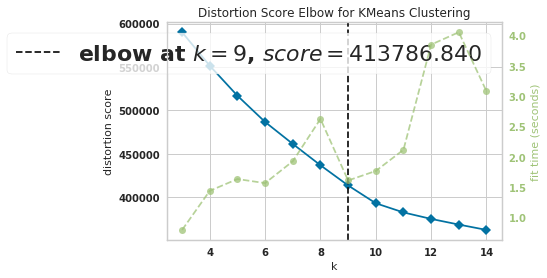

In [ ]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [ ]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
print(f"Number of clusters {num_clusters}")

Number of clusters 10


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassi

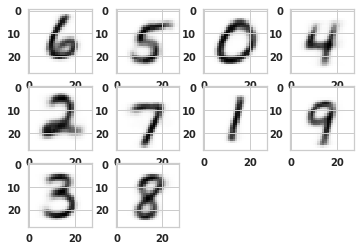

In [ ]:
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
tf.reset_default_graph()
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [ ]:
import json
# TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6,5,0,4,
                                           2,7,1,9,
                                           3,8
                                          ]
manual_annotation_json["manual_confidence"] = [1, 0.8, 1, 1,
                                               1,1,1,1,
                                               0.8, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [ ]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [ ]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

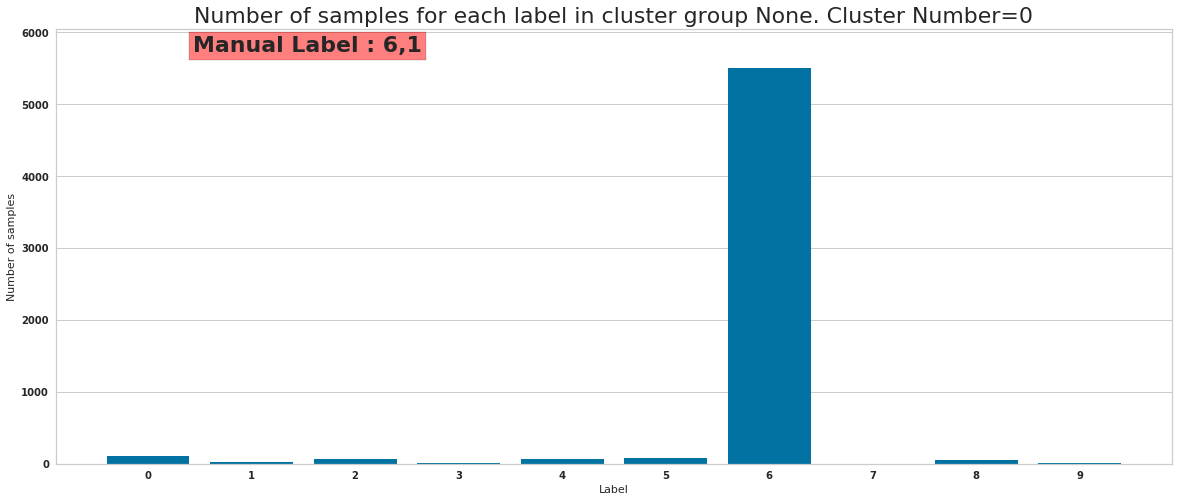

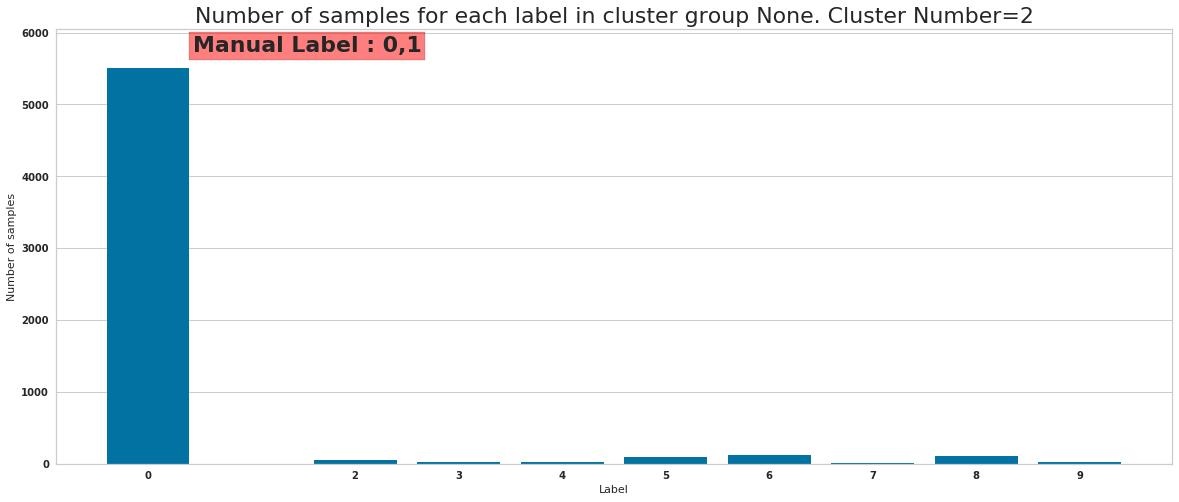

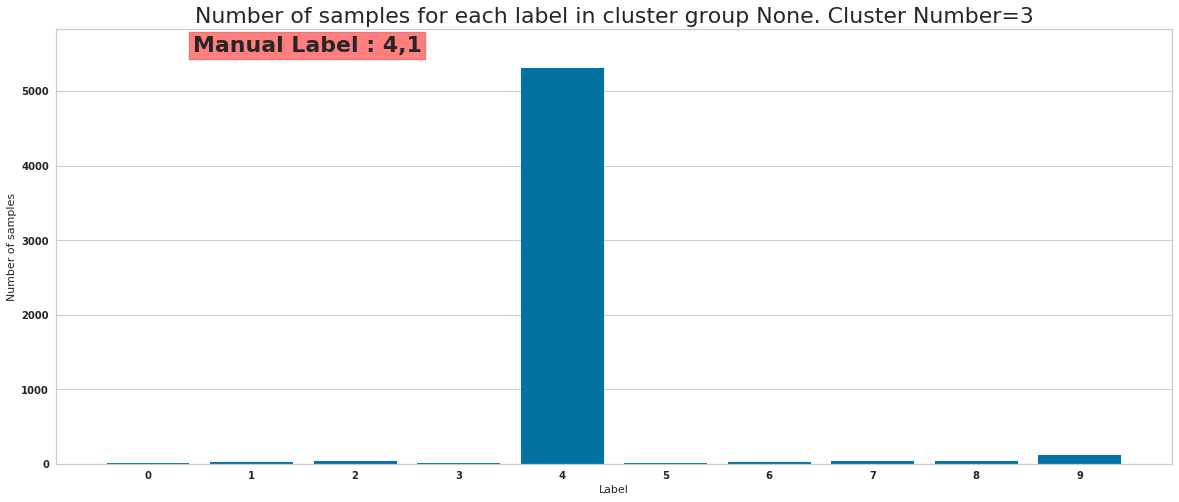

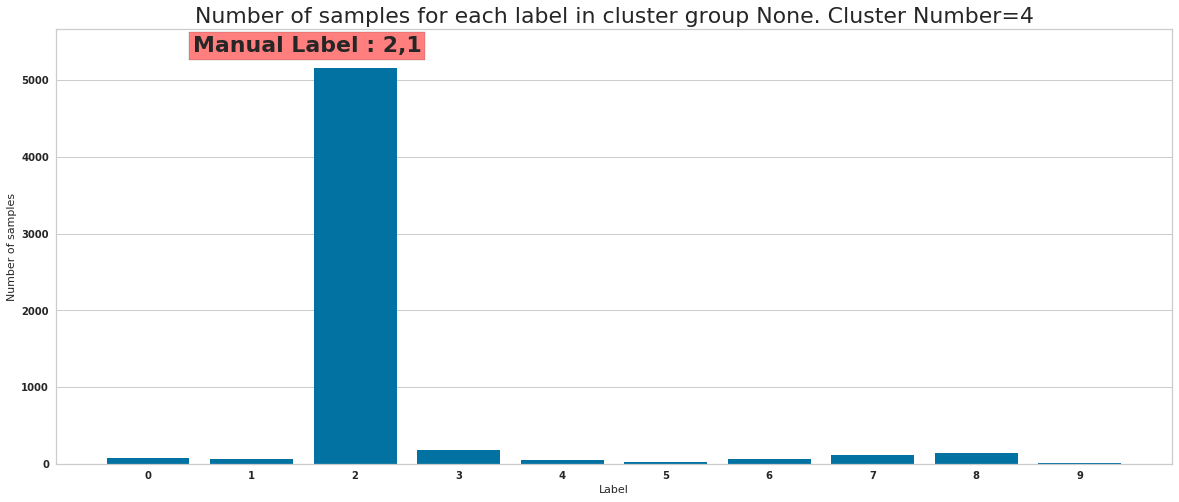

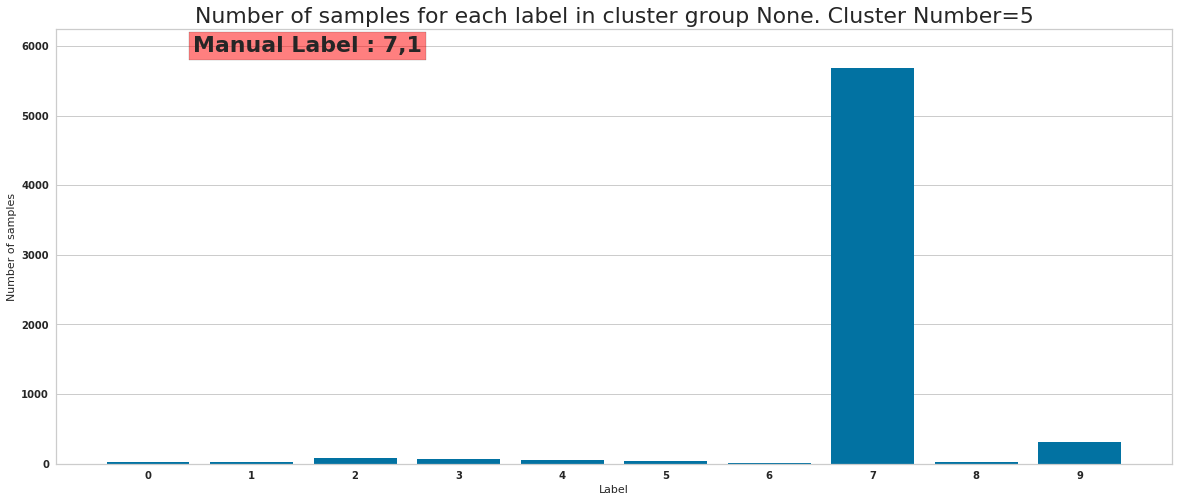

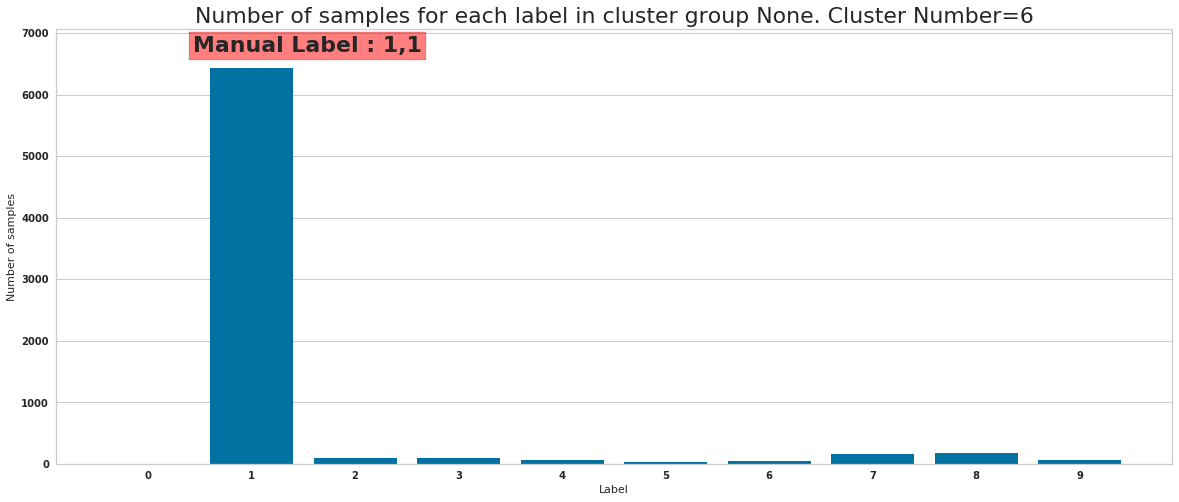

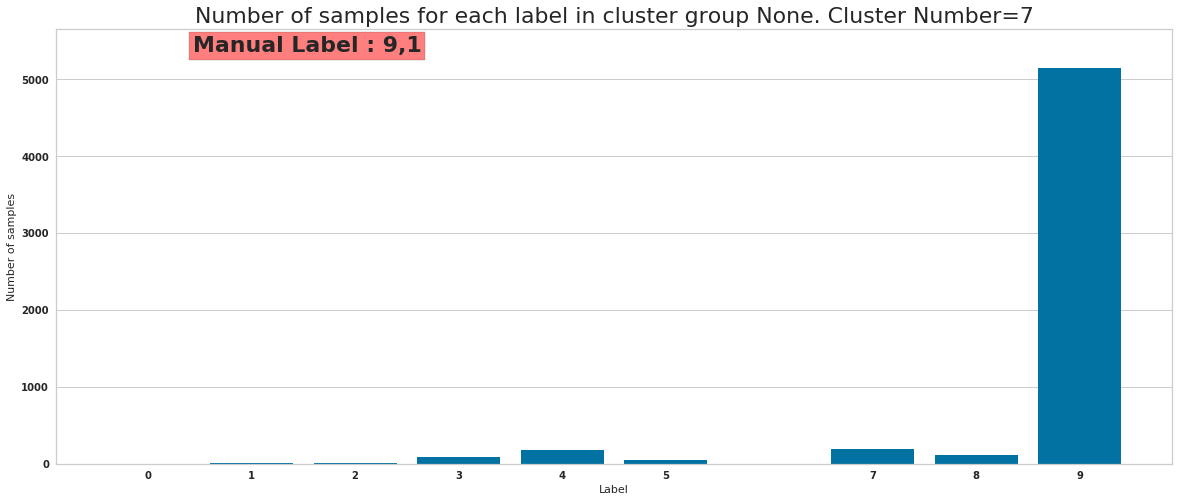

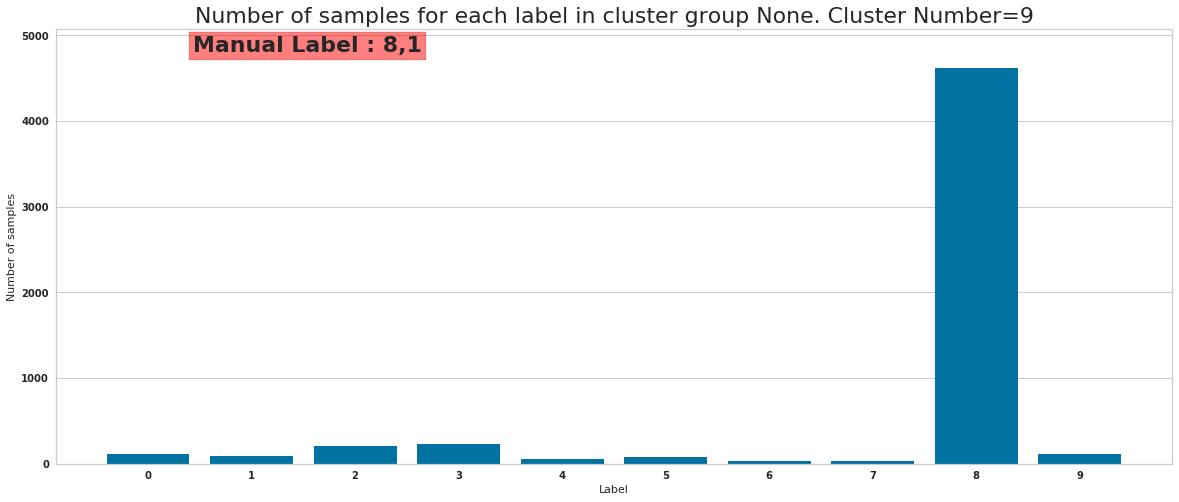

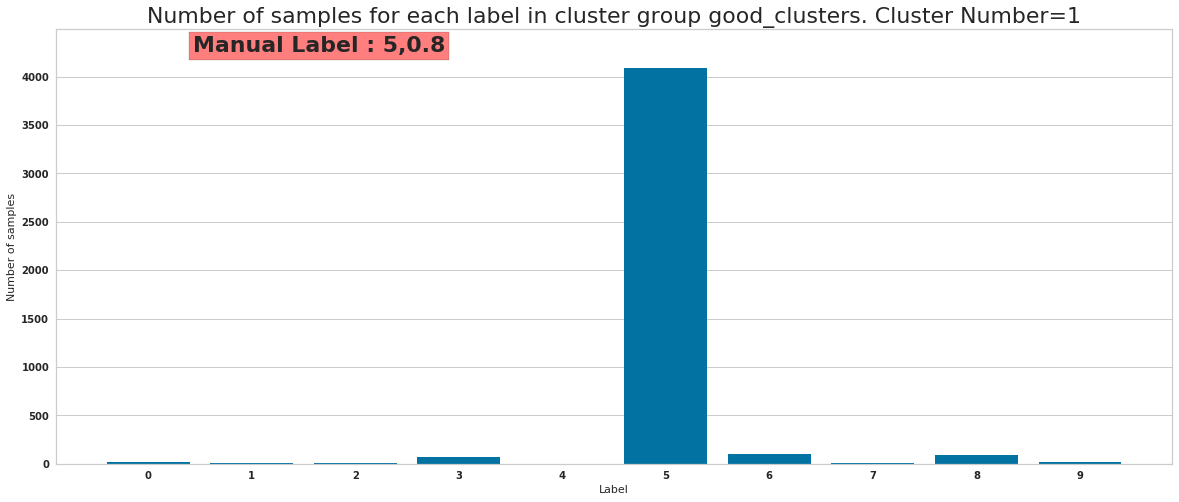

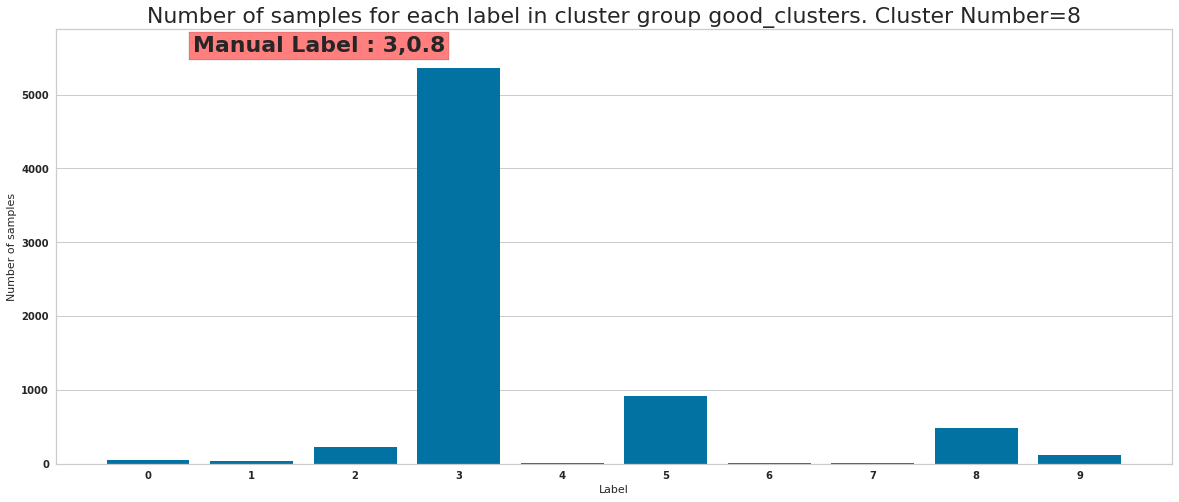

In [ ]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5941, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(4424, 10)
(5967, 10)
(5591, 10)
(5873, 10)
(6323, 10)
(7141, 10)
(5780, 10)
(7243, 10)
(5557, 10)


In [ ]:
level2_manual_annotations = cluster_next_level_gmm(exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

In [ ]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, -1, 0,
#                                         -1, -1, -1, -1,
#                                         5, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0.7,
#                                              0, 0, 0, 0,
#                                              0.7, 0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4, 9, 4, 9,
#                                         9, 4, 9, 4,
#                                         4, -1]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.8,0.8,0.8,
#                                              0.8,0.8,0.8,0.8,
#                                              0.8, 0]
# level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [ ]:
def process_second_level_clusters(df, cluster_group_dict, num_level_2_clusters, level2_manual_annotations,z_col_names, cluster_column_name_2,):
  print("Setting  next_level_clusters attribute to each primary cluster")
  for cluster_id in level2_manual_annotations.keys():
      _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
      _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

      print(cluster_id)
      level_2_cluster_dict = level2_manual_annotations[cluster_id]
      _indices =np.where( df["cluster_labels"].values == cluster_id)
      cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                      level_2_cluster_dict["manual_confidences"],
                                                      "cluster_level_2",
                                                      _cluster_centers,
                                                      _cluster_labels,
                                                      df,
                                                      _indices
                                                    )
      _, cluster = get_cluster(cluster_id, cluster_group_dict)
      cluster.set_next_level_clusters(cluster_level_2_group_dict)

  print("Computing distances from second level cluster centers")
  for cluster_id in level2_manual_annotations.keys():
      _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
      _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

      print(cluster_id)

      _, cluster = get_cluster(cluster_id, cluster_group_dict)
      num_level_2_clusters = cluster.next_lever_cluster_count()
      print(num_level_2_clusters)
      compute_distance_level_2(df, num_level_2_clusters, df["cluster_labels"].values, z_col_names, cluster, cluster_column_name_2)

  # impure_cluster = None
  # if "impure_cluster" in cluster_group_dict.keys():
  #     for cluster in cluster_group_dict["impure_cluster"]:
  #         print(cluster.id)
  #         _indices =np.where( cluster_labels == cluster.id)
  #         _df = df.iloc[_indices]
  #         _latent_vectors = _df[z_col_names].values
  #         _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
  #                                                                                             _latent_vectors,
  #                                                                                             exp_config)
  #         df[cluster_column_name_2].iloc[_indices] = _cluster_labels
  #         image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

  #         display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

  #         print(_df.iloc[_cluster_labels == 1].shape)
  #         print(_df.iloc[_cluster_labels == 0].shape)
  #         impure_cluster = cluster
          
  # level_2_cluster_dict = dict()
  # if "impure_cluster" in cluster_group_dict.keys():
  #     cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
  #                                                     level_2_cluster_dict["manual_confidences"],
  #                                                     "cluster_level_2",
  #                                                     _cluster_centers,
  #                                                     _cluster_labels,
  #                                                     df,
  #                                                     _indices
  #                                                   )
  #     impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
      
  # if "impure_cluster" in cluster_group_dict.keys():

  #     for cluster in cluster_group_dict["impure_cluster"]:
  #         num_level_2_clusters = cluster.next_lever_cluster_count()
  #         print(num_level_2_clusters)
  #         for i in range(num_level_2_clusters):
  #             df[f"distance_level_2_{cluster.id}_{i}"] = 100000
  #         for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
  #             #print(level_2_cluster.id)
  #             indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
  #             #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
  #             cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
  #             print(level_2_cluster.id, indices.shape)
  #             df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
  #                                                                                                                               cluster_centers_level_2,
  #                                                                                                                               z_col_names), axis=1)



Manual Label 6
(5941, 47) (5941, 33)
Num correct=5499
Cluster 0 Manual Label 6 Percentage correct 92.5601750547046
********************************
Manual Label 5
(4424, 47) (4424, 33)
Num correct=4084
Cluster 1 Manual Label 5 Percentage correct 92.31464737793851
********************************
Manual Label 0
(5967, 47) (5967, 33)
Num correct=5500
Cluster 2 Manual Label 0 Percentage correct 92.17362158538629
********************************
Manual Label 4
(5591, 47) (5591, 33)
Num correct=5305
Cluster 3 Manual Label 4 Percentage correct 94.8846360221785
********************************
Manual Label 2
(5873, 47) (5873, 33)
Num correct=5151
Cluster 4 Manual Label 2 Percentage correct 87.70645326068448
********************************
Manual Label 7
(6323, 47) (6323, 33)
Num correct=5676
Cluster 5 Manual Label 7 Percentage correct 89.76751541989562
********************************
Manual Label 1
(7141, 47) (7141, 33)
Num correct=6424
Cluster 6 Manual Label 1 Percentage correct 89.9593894

In [ ]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  num_level_2_clusters,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2)
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

In [ ]:
num_individual_samples_annotated

0

In [ ]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5941., 4424., 5967., 5591., 5873., 6323., 7141., 5780., 7243.,
        5557.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

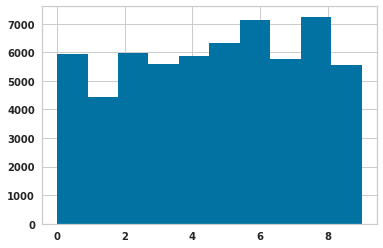

In [ ]:
plt.hist(cluster_labels)

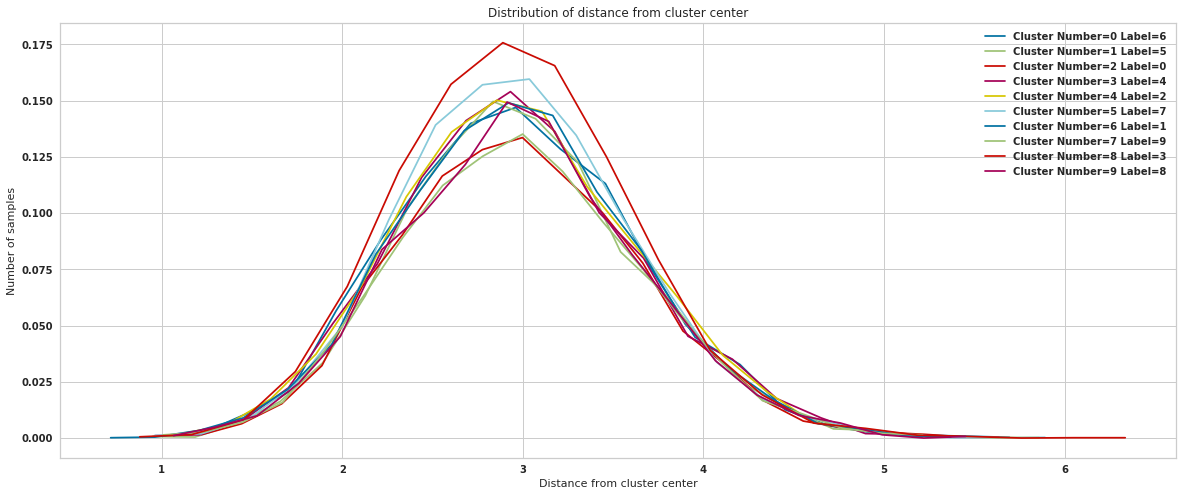

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

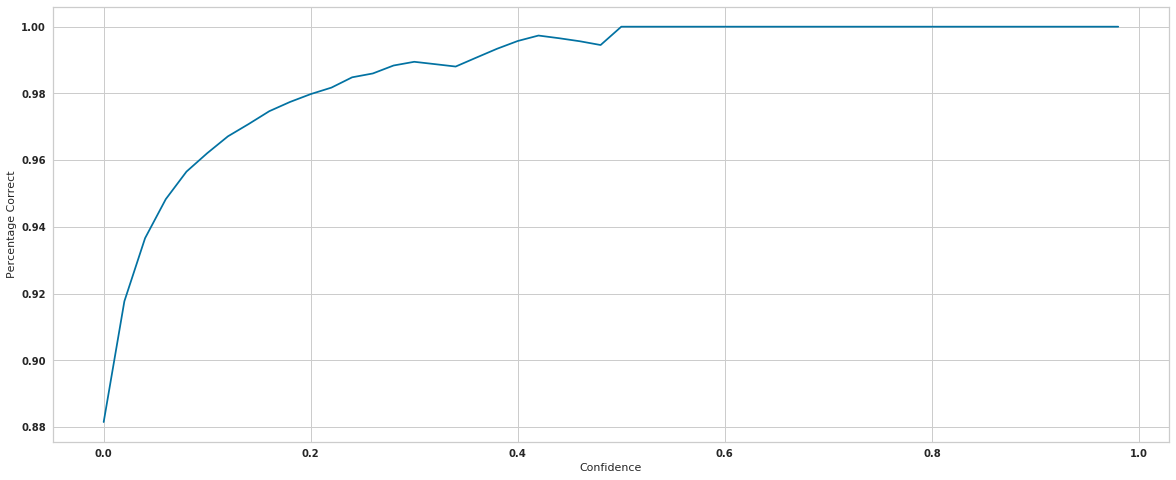

In [ ]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

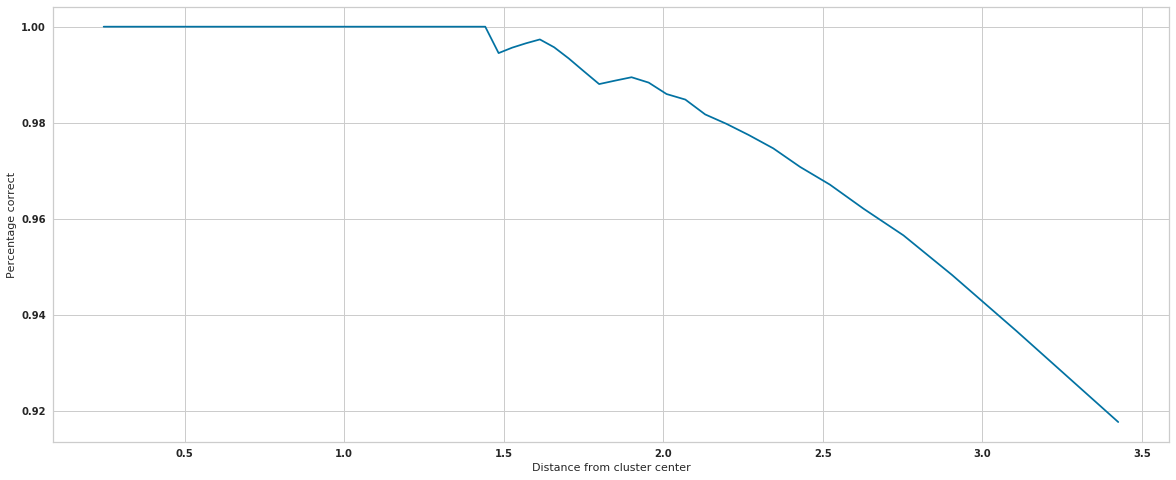

In [ ]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [ ]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3


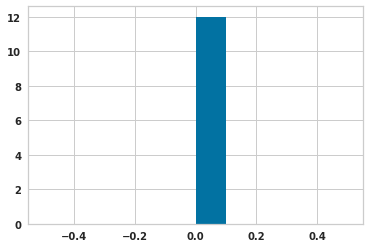

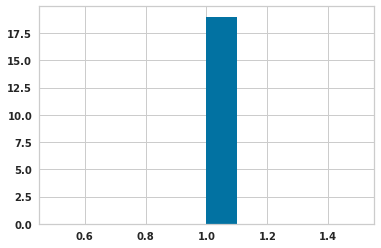

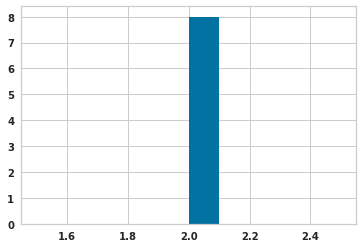

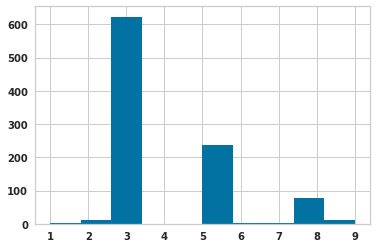

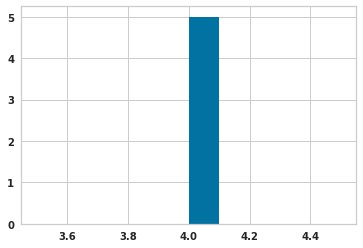

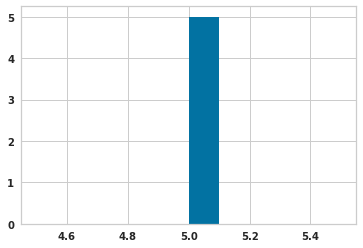

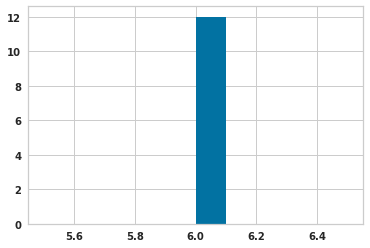

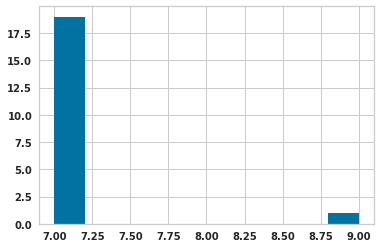

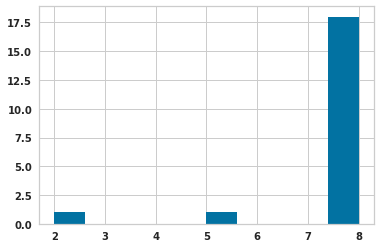

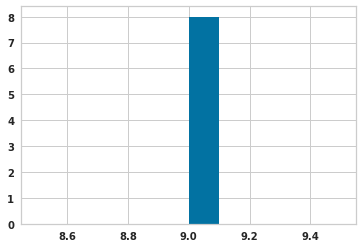

In [ ]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)

,epoch,train_accuracy,val_accuracy,test_accuracy,train_reconstruction_loss,val_reconstruction_loss,test_reconstruction_loss,num_individual_samples_annotated,num_samples_wrongly_annotated,total_confidence_of_wrong_annotation
0,3,0.766928,0.8125,0.765425,123.86779,123.300842,123.315308,0,7089,240.803849


In [ ]:
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [ ]:
num_epochs
num_epochs += 1
print(num_epochs)

4


In [ ]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_3.0.csv


In [ ]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        root_path=root_path,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        learning_rate=1e-4,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.0001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100'}
Loaded manual annotation
Number of samples with manual confidence 59840
Total Manual

Epoch: 3/61, Nll_loss : 122.11761474609375 KLD:9.096515655517578  Supervised loss:0.10700622946023941
Epoch: 3/62, Nll_loss : 133.4613037109375 KLD:9.255728721618652  Supervised loss:0.15156424045562744
Epoch: 3/63, Nll_loss : 121.34595489501953 KLD:8.95683479309082  Supervised loss:0.11324866861104965
Epoch: 3/64, Nll_loss : 120.82371520996094 KLD:8.700201034545898  Supervised loss:0.12995745241641998
Epoch: 3/65, Nll_loss : 130.8289031982422 KLD:8.916584968566895  Supervised loss:0.11518753319978714
Epoch: 3/66, Nll_loss : 114.69537353515625 KLD:8.619455337524414  Supervised loss:0.16536058485507965
Epoch: 3/67, Nll_loss : 113.87855529785156 KLD:8.431106567382812  Supervised loss:0.15487661957740784
Epoch: 3/68, Nll_loss : 124.61199951171875 KLD:9.01479434967041  Supervised loss:0.08755602687597275
Epoch: 3/69, Nll_loss : 131.489013671875 KLD:8.806629180908203  Supervised loss:0.1590457409620285
Epoch: 3/70, Nll_loss : 117.69541931152344 KLD:8.811260223388672  Supervised loss:0.10855

Epoch: 3/142, Nll_loss : 122.85769653320312 KLD:9.23736572265625  Supervised loss:0.1103784441947937
Epoch: 3/143, Nll_loss : 122.8894271850586 KLD:8.790160179138184  Supervised loss:0.06621243804693222
Epoch: 3/144, Nll_loss : 118.12606048583984 KLD:9.11161994934082  Supervised loss:0.08026149868965149
Epoch: 3/145, Nll_loss : 123.37689208984375 KLD:8.596803665161133  Supervised loss:0.16574972867965698
Epoch: 3/146, Nll_loss : 115.49520874023438 KLD:9.089198112487793  Supervised loss:0.17936857044696808
Epoch: 3/147, Nll_loss : 120.66736602783203 KLD:9.13693618774414  Supervised loss:0.1156187430024147
Epoch: 3/148, Nll_loss : 128.93441772460938 KLD:8.973774909973145  Supervised loss:0.14431025087833405
Epoch: 3/149, Nll_loss : 119.54435729980469 KLD:8.89777946472168  Supervised loss:0.10017845779657364
Epoch: 3/150, Nll_loss : 127.48214721679688 KLD:9.29080581665039  Supervised loss:0.07156109809875488
Epoch: 3/151, Nll_loss : 119.85441589355469 KLD:8.933967590332031  Supervised los

Epoch: 3/224, Nll_loss : 127.08470153808594 KLD:9.223808288574219  Supervised loss:0.11962224543094635
Epoch: 3/225, Nll_loss : 129.01028442382812 KLD:9.010370254516602  Supervised loss:0.15375784039497375
Epoch: 3/226, Nll_loss : 123.59715270996094 KLD:8.54890251159668  Supervised loss:0.14656490087509155
Epoch: 3/227, Nll_loss : 125.67682647705078 KLD:8.511222839355469  Supervised loss:0.11168868839740753
Epoch: 3/228, Nll_loss : 125.83050537109375 KLD:8.807963371276855  Supervised loss:0.0994553491473198
Epoch: 3/229, Nll_loss : 121.62051391601562 KLD:9.121872901916504  Supervised loss:0.14362239837646484
Epoch: 3/230, Nll_loss : 126.98464965820312 KLD:8.837360382080078  Supervised loss:0.1361338198184967
Epoch: 3/231, Nll_loss : 125.84403991699219 KLD:8.975173950195312  Supervised loss:0.09451328217983246
Epoch: 3/232, Nll_loss : 120.9690170288086 KLD:8.691964149475098  Supervised loss:0.15121561288833618
Epoch: 3/233, Nll_loss : 120.22429656982422 KLD:9.270833015441895  Supervised

Epoch: 3/307, Nll_loss : 121.69479370117188 KLD:8.675253868103027  Supervised loss:0.12151458114385605
Epoch: 3/308, Nll_loss : 128.1876220703125 KLD:8.867521286010742  Supervised loss:0.12156444042921066
Epoch: 3/309, Nll_loss : 118.01802062988281 KLD:8.706914901733398  Supervised loss:0.09596993774175644
Epoch: 3/310, Nll_loss : 132.00201416015625 KLD:8.659350395202637  Supervised loss:0.09005299210548401
Epoch: 3/311, Nll_loss : 131.3560791015625 KLD:8.742575645446777  Supervised loss:0.0971001386642456
Epoch: 3/312, Nll_loss : 128.48736572265625 KLD:8.974446296691895  Supervised loss:0.14404794573783875
Epoch: 3/313, Nll_loss : 128.65562438964844 KLD:8.371137619018555  Supervised loss:0.12843848764896393
Epoch: 3/314, Nll_loss : 117.10467529296875 KLD:8.681069374084473  Supervised loss:0.07343039661645889
Epoch: 3/315, Nll_loss : 118.84856414794922 KLD:8.635566711425781  Supervised loss:0.08974725008010864
Epoch: 3/316, Nll_loss : 122.49767303466797 KLD:8.82320785522461  Supervised

Epoch: 3/387, Nll_loss : 119.70812225341797 KLD:8.745744705200195  Supervised loss:0.13000088930130005
Epoch: 3/388, Nll_loss : 124.73407745361328 KLD:8.602216720581055  Supervised loss:0.11735756695270538
Epoch: 3/389, Nll_loss : 121.02949523925781 KLD:8.762439727783203  Supervised loss:0.14527171850204468
Epoch: 3/390, Nll_loss : 127.11347961425781 KLD:8.691337585449219  Supervised loss:0.12957754731178284
Epoch: 3/391, Nll_loss : 118.61197662353516 KLD:8.632139205932617  Supervised loss:0.15180671215057373
Epoch: 3/392, Nll_loss : 122.91189575195312 KLD:8.905594825744629  Supervised loss:0.10162368416786194
Epoch: 3/393, Nll_loss : 131.53607177734375 KLD:8.610491752624512  Supervised loss:0.1254202127456665
Epoch: 3/394, Nll_loss : 125.38742065429688 KLD:9.002134323120117  Supervised loss:0.1560872197151184
Epoch: 3/395, Nll_loss : 123.61604309082031 KLD:8.501747131347656  Supervised loss:0.19492527842521667
Epoch: 3/396, Nll_loss : 120.13818359375 KLD:9.113738059997559  Supervised 

Epoch: 3/468, Nll_loss : 127.37775421142578 KLD:9.101312637329102  Supervised loss:0.20894171297550201
Epoch: 3/469, Nll_loss : 118.26753234863281 KLD:8.666482925415039  Supervised loss:0.15430837869644165
Epoch: 3/470, Nll_loss : 117.65609741210938 KLD:9.121098518371582  Supervised loss:0.06045234948396683
Epoch: 3/471, Nll_loss : 120.41531372070312 KLD:8.934715270996094  Supervised loss:0.10405735671520233
Epoch: 3/472, Nll_loss : 125.56275939941406 KLD:8.898369789123535  Supervised loss:0.11586785316467285
Epoch: 3/473, Nll_loss : 119.10962677001953 KLD:9.002225875854492  Supervised loss:0.14445260167121887
Epoch: 3/474, Nll_loss : 117.58811950683594 KLD:8.747167587280273  Supervised loss:0.11559605598449707
Epoch: 3/475, Nll_loss : 121.25152587890625 KLD:9.031932830810547  Supervised loss:0.10870300233364105
Epoch: 3/476, Nll_loss : 118.85874938964844 KLD:8.97906494140625  Supervised loss:0.12493260204792023
Epoch: 3/477, Nll_loss : 123.55607604980469 KLD:8.857271194458008  Supervi

Epoch: 3/548, Nll_loss : 116.89511108398438 KLD:8.634754180908203  Supervised loss:0.12669263780117035
Epoch: 3/549, Nll_loss : 117.60554504394531 KLD:8.761367797851562  Supervised loss:0.11785609275102615
Epoch: 3/550, Nll_loss : 120.55110168457031 KLD:8.89820671081543  Supervised loss:0.12577569484710693
Epoch: 3/551, Nll_loss : 125.32361602783203 KLD:8.79947280883789  Supervised loss:0.10186322033405304
Epoch: 3/552, Nll_loss : 114.498291015625 KLD:8.655741691589355  Supervised loss:0.11084835231304169
Epoch: 3/553, Nll_loss : 123.87164306640625 KLD:9.191502571105957  Supervised loss:0.09381341934204102
Epoch: 3/554, Nll_loss : 123.32940673828125 KLD:8.436277389526367  Supervised loss:0.17760784924030304
Epoch: 3/555, Nll_loss : 120.81610107421875 KLD:8.958125114440918  Supervised loss:0.12278871238231659
Epoch: 3/556, Nll_loss : 127.50039672851562 KLD:8.875492095947266  Supervised loss:0.1200917661190033
Epoch: 3/557, Nll_loss : 119.26719665527344 KLD:9.01377010345459  Supervised l

Epoch: 3/629, Nll_loss : 121.31271362304688 KLD:8.498106002807617  Supervised loss:0.07038784772157669
Epoch: 3/630, Nll_loss : 123.95787811279297 KLD:8.75400447845459  Supervised loss:0.12256501615047455
Epoch: 3/631, Nll_loss : 116.81442260742188 KLD:8.591711044311523  Supervised loss:0.15499116480350494
Epoch: 3/632, Nll_loss : 114.18206787109375 KLD:8.934724807739258  Supervised loss:0.12484370172023773
Epoch: 3/633, Nll_loss : 118.76458740234375 KLD:8.41038703918457  Supervised loss:0.15143205225467682
Epoch: 3/634, Nll_loss : 123.8341064453125 KLD:8.245905876159668  Supervised loss:0.12196630239486694
Epoch: 3/635, Nll_loss : 126.85354614257812 KLD:8.88485336303711  Supervised loss:0.165206640958786
Epoch: 3/636, Nll_loss : 121.8840560913086 KLD:8.59240436553955  Supervised loss:0.08400695025920868
Epoch: 3/637, Nll_loss : 114.9267578125 KLD:8.402385711669922  Supervised loss:0.14289475977420807
Epoch: 3/638, Nll_loss : 121.91854858398438 KLD:8.493419647216797  Supervised loss:0.

Epoch: 3/711, Nll_loss : 124.62449645996094 KLD:8.401715278625488  Supervised loss:0.26671674847602844
Epoch: 3/712, Nll_loss : 124.84973907470703 KLD:8.885649681091309  Supervised loss:0.07493868470191956
Epoch: 3/713, Nll_loss : 120.81178283691406 KLD:8.621517181396484  Supervised loss:0.11504121869802475
Epoch: 3/714, Nll_loss : 114.41671752929688 KLD:9.40936279296875  Supervised loss:0.08885505050420761
Epoch: 3/715, Nll_loss : 118.23921966552734 KLD:8.351115226745605  Supervised loss:0.1257578730583191
Epoch: 3/716, Nll_loss : 119.60518646240234 KLD:8.587799072265625  Supervised loss:0.07634393870830536
Epoch: 3/717, Nll_loss : 125.33750915527344 KLD:8.942424774169922  Supervised loss:0.1726551055908203
Epoch: 3/718, Nll_loss : 114.72256469726562 KLD:8.509634971618652  Supervised loss:0.10900547355413437
Epoch: 3/719, Nll_loss : 124.16893005371094 KLD:8.767520904541016  Supervised loss:0.17310667037963867
Epoch: 3/720, Nll_loss : 123.87430572509766 KLD:8.874037742614746  Supervise

Epoch: 3/793, Nll_loss : 116.18827819824219 KLD:8.547255516052246  Supervised loss:0.16715171933174133
Epoch: 3/794, Nll_loss : 121.71646118164062 KLD:9.392571449279785  Supervised loss:0.07325543463230133
Epoch: 3/795, Nll_loss : 120.50535583496094 KLD:9.101625442504883  Supervised loss:0.09955600649118423
Epoch: 3/796, Nll_loss : 131.21031188964844 KLD:8.957673072814941  Supervised loss:0.09424974024295807
Epoch: 3/797, Nll_loss : 120.54100036621094 KLD:8.919921875  Supervised loss:0.10998110473155975
Epoch: 3/798, Nll_loss : 122.974609375 KLD:8.566094398498535  Supervised loss:0.15141400694847107
Epoch: 3/799, Nll_loss : 129.06956481933594 KLD:9.476402282714844  Supervised loss:0.12033408135175705
Epoch: 3/800, Nll_loss : 124.01473999023438 KLD:8.9740629196167  Supervised loss:0.07843911647796631
Epoch: 3/801, Nll_loss : 117.35125732421875 KLD:9.104475021362305  Supervised loss:0.0629221498966217
Epoch: 3/802, Nll_loss : 120.03535461425781 KLD:9.133156776428223  Supervised loss:0.12

Epoch: 3/875, Nll_loss : 118.66059875488281 KLD:9.054447174072266  Supervised loss:0.12204375863075256
Epoch: 3/876, Nll_loss : 117.49522399902344 KLD:8.639800071716309  Supervised loss:0.1097414568066597
Epoch: 3/877, Nll_loss : 123.30645751953125 KLD:9.029540061950684  Supervised loss:0.05790681019425392
Epoch: 3/878, Nll_loss : 130.30992126464844 KLD:9.012715339660645  Supervised loss:0.1149069294333458
Epoch: 3/879, Nll_loss : 115.49473571777344 KLD:8.807703971862793  Supervised loss:0.10826200991868973
Epoch: 3/880, Nll_loss : 118.6460189819336 KLD:8.767366409301758  Supervised loss:0.1183612197637558
Epoch: 3/881, Nll_loss : 118.90927124023438 KLD:8.89443588256836  Supervised loss:0.14275725185871124
Epoch: 3/882, Nll_loss : 121.47271728515625 KLD:8.7907133102417  Supervised loss:0.15377335250377655
Epoch: 3/883, Nll_loss : 109.07048034667969 KLD:8.859435081481934  Supervised loss:0.08110105991363525
Epoch: 3/884, Nll_loss : 121.31547546386719 KLD:9.156225204467773  Supervised lo

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassi

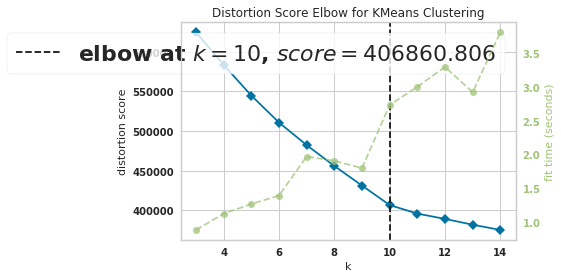

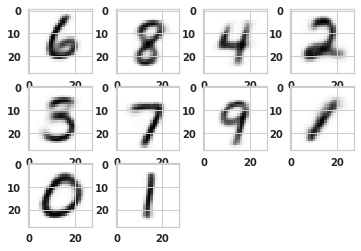

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
print(f"Number of clusters {num_clusters}")

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [ ]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 8, 4, 2,
                                           -1, 7, 4, 1,
                                           0, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               0, 1, 1, 0.8,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


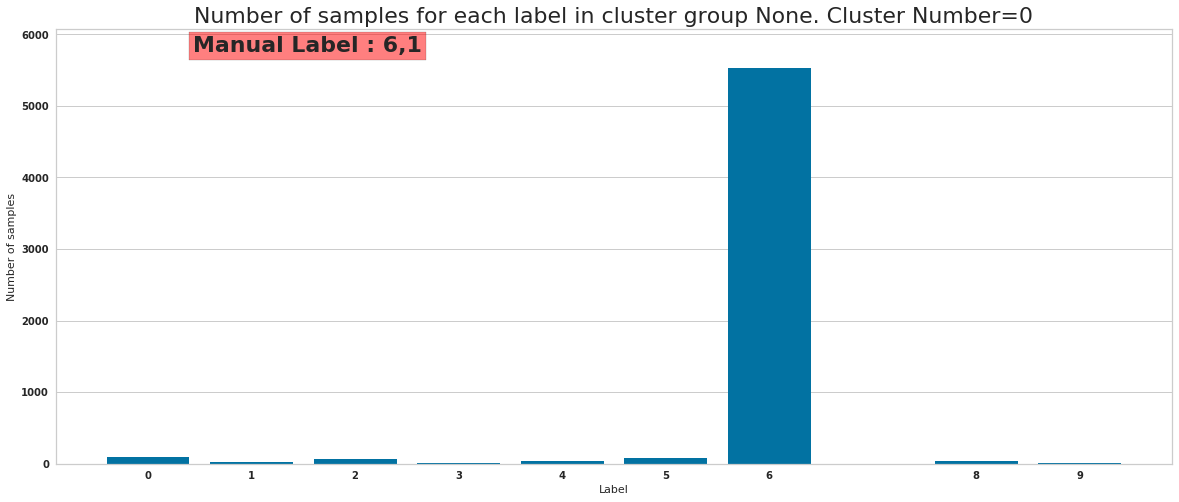

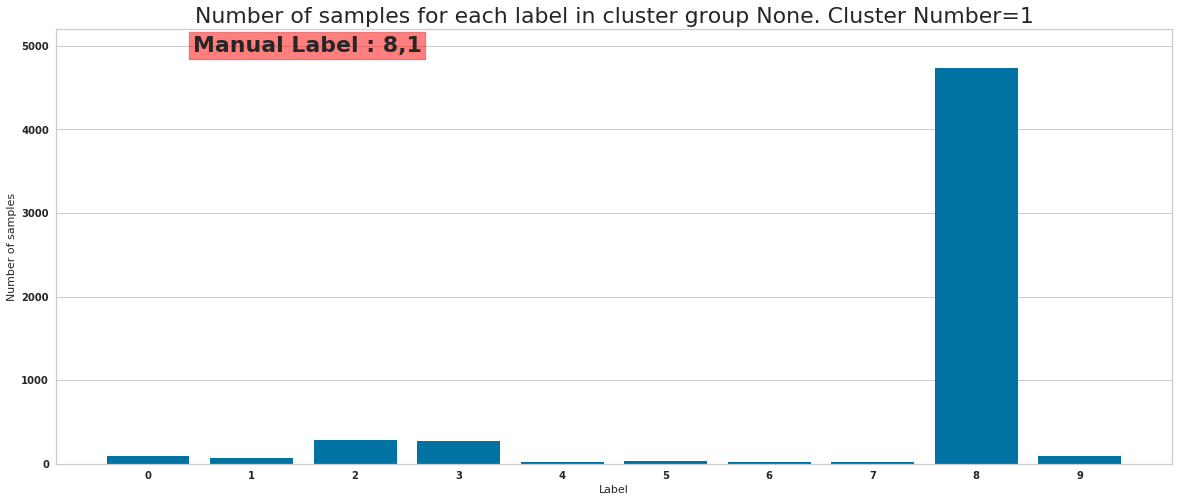

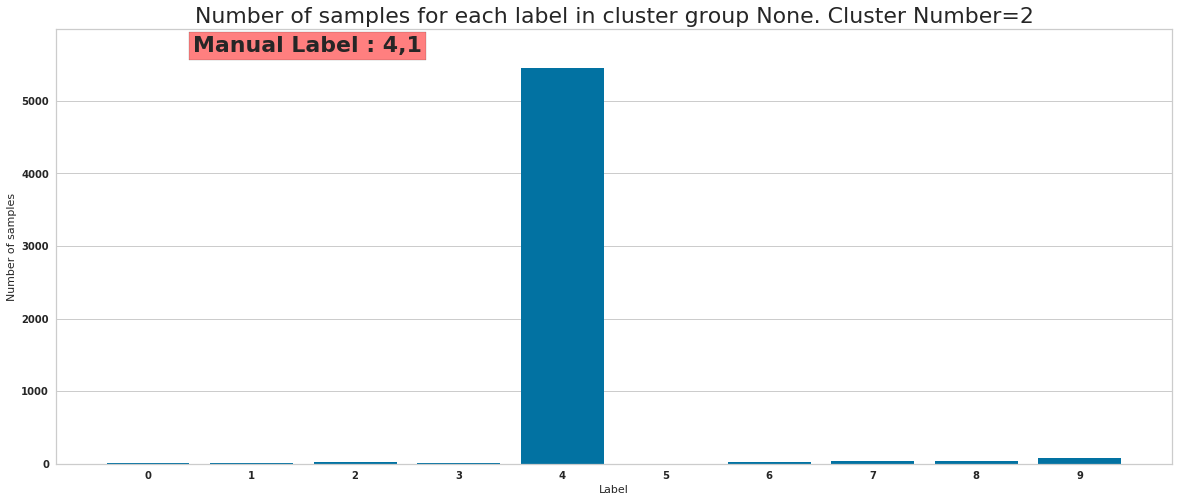

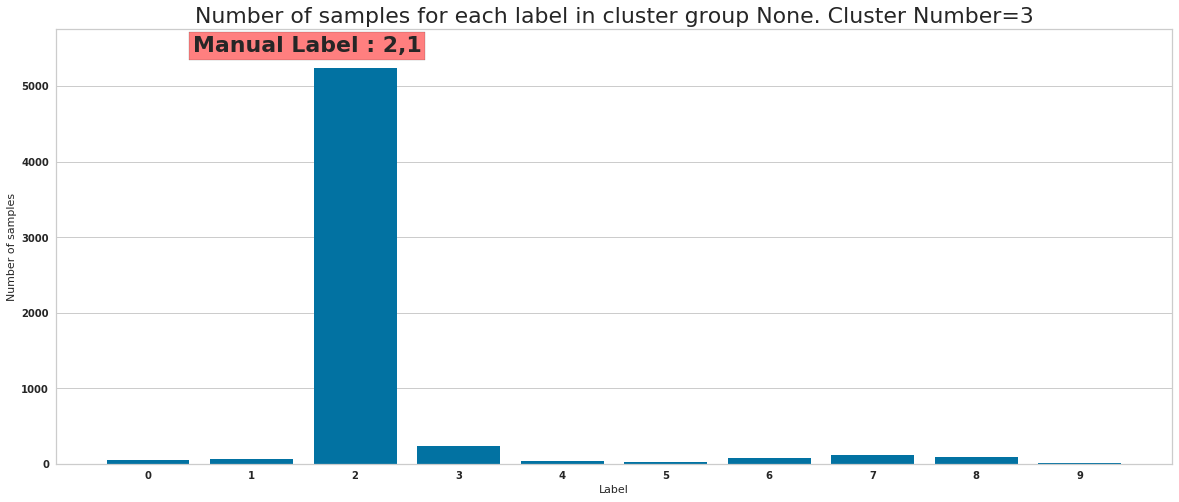

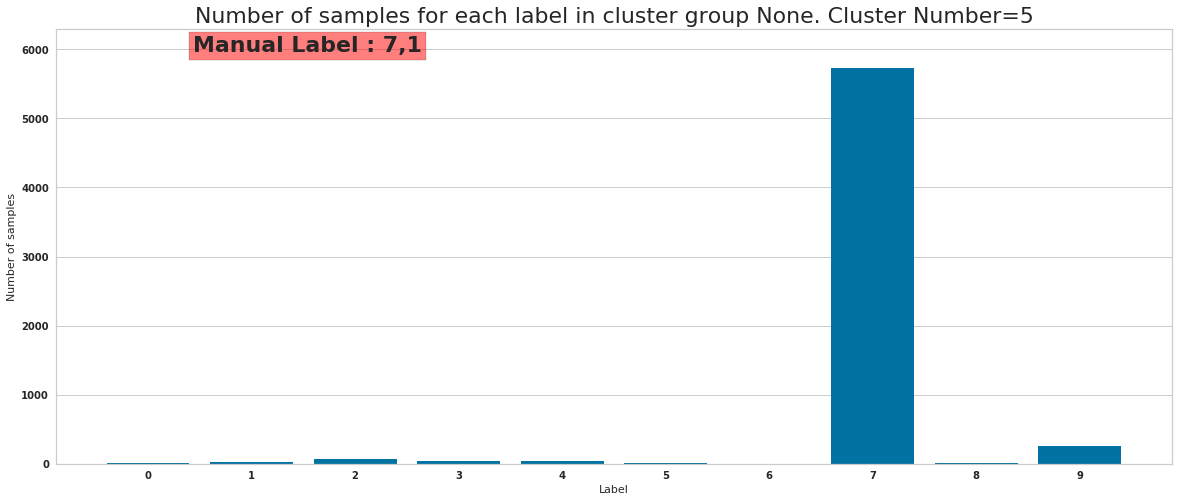

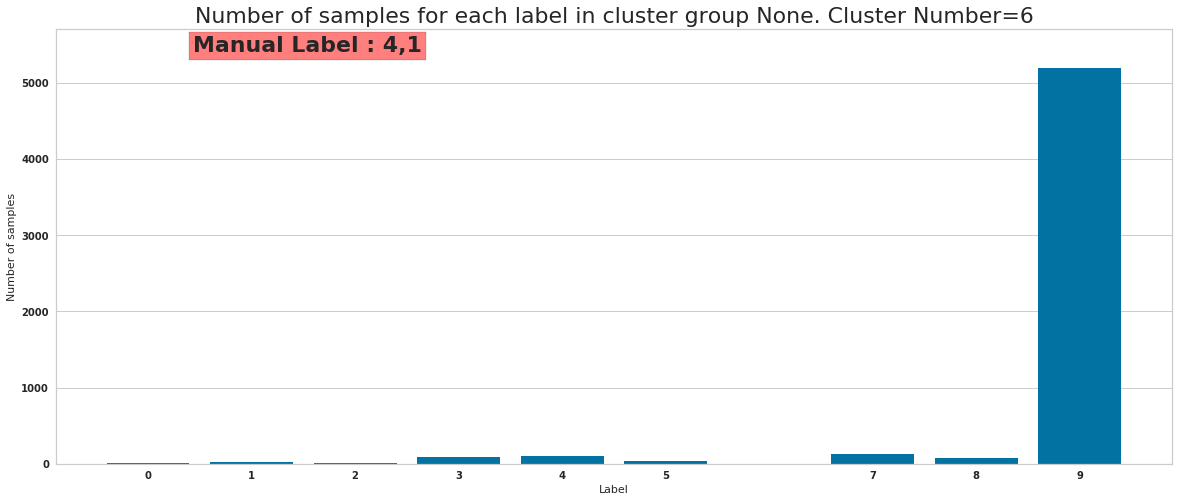

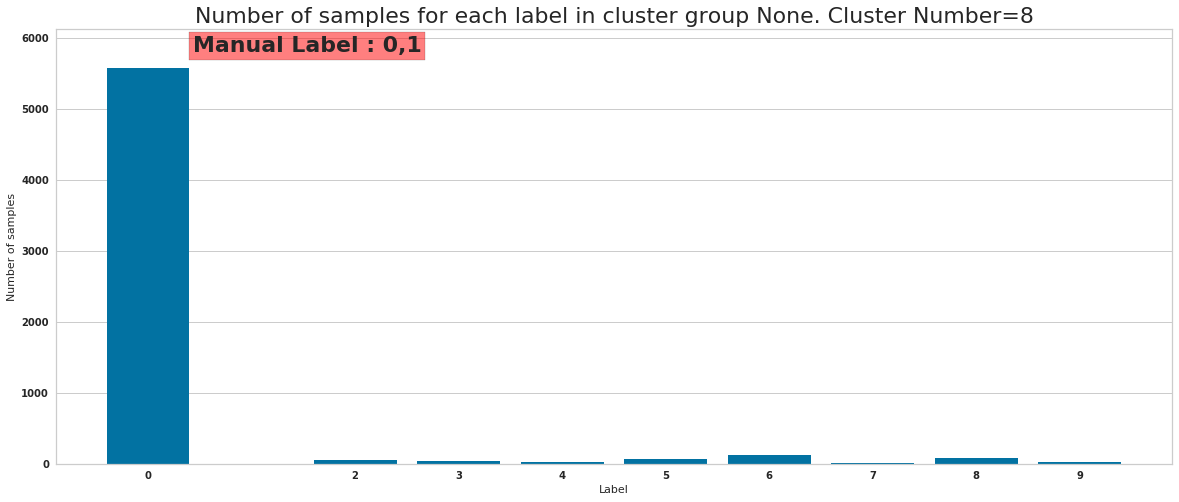

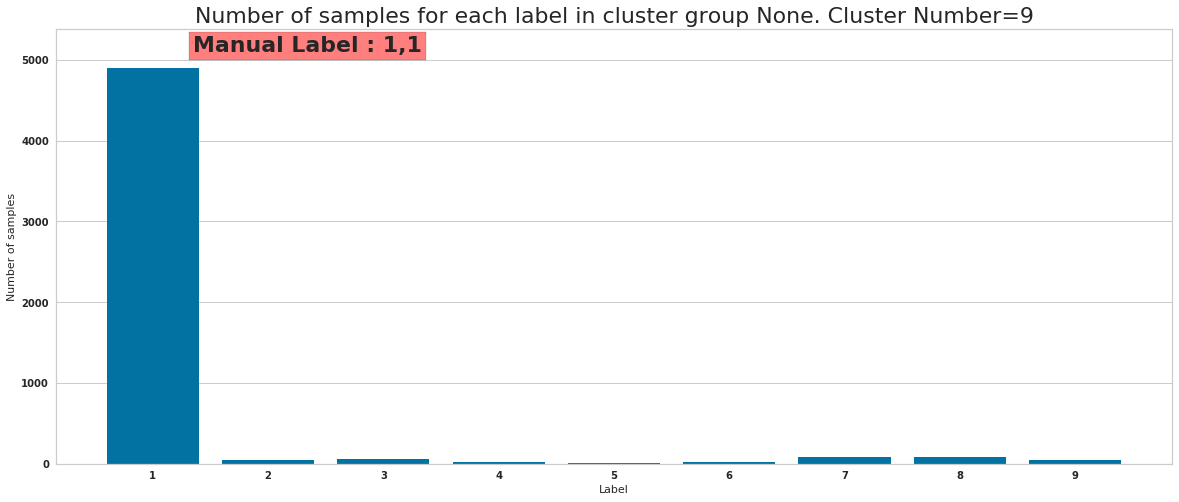

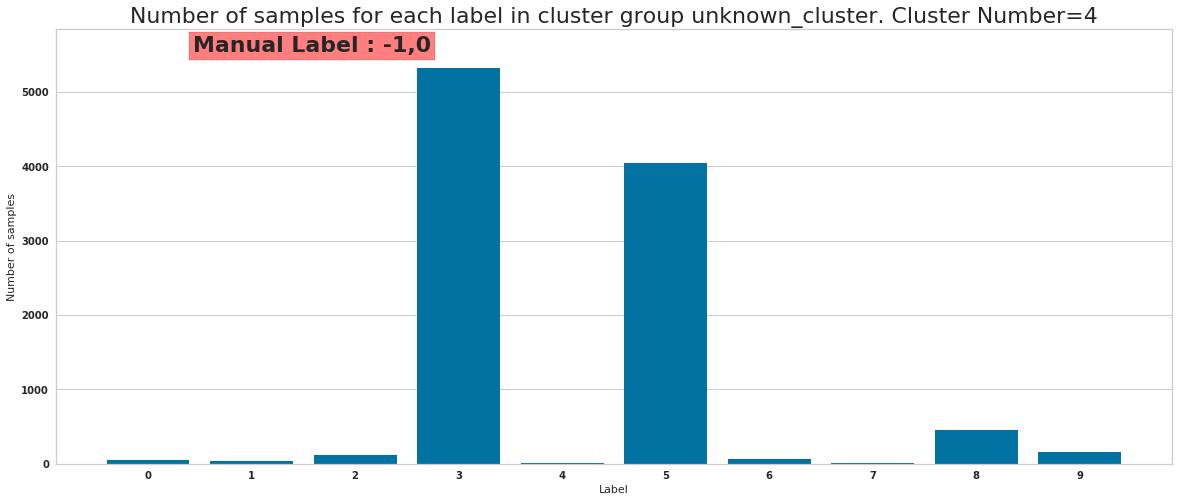

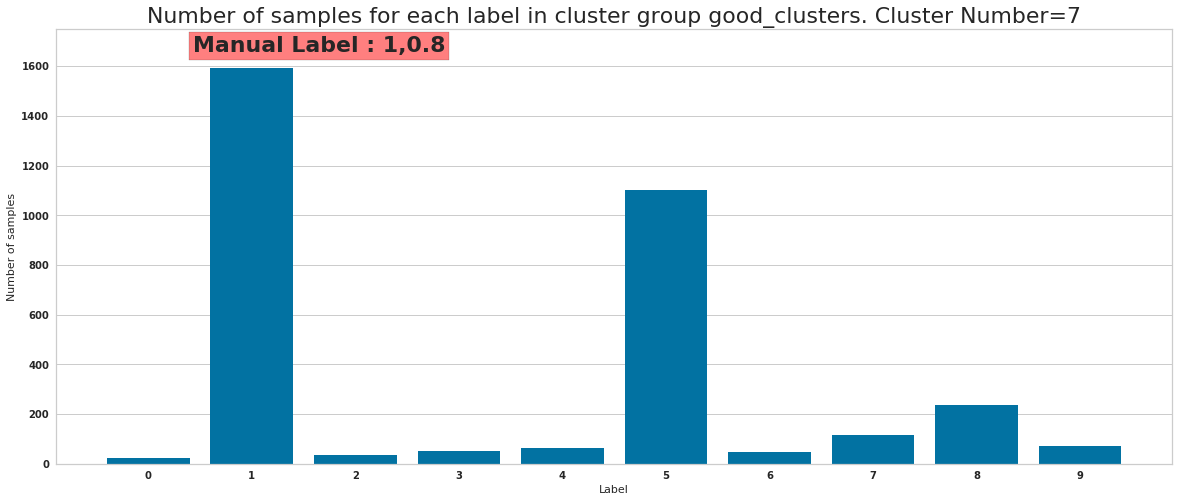

In [ ]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

(5886, 10)
(5638, 10)
(5675, 10)
(5945, 10)
(10283, 10)
(6177, 10)
(5647, 10)
(3335, 10)
(5986, 10)
(5268, 10)
4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters fr

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


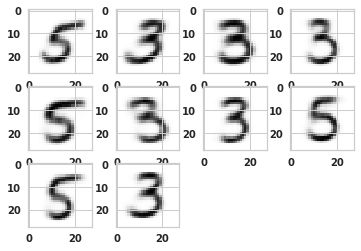

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [ ]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [5, 3, 3, 3,
                                         5, -1, 3, 5,
                                         5,3
                                        ]
level_2_cluster_dict["manual_confidences"] = [0.9,0.9,0.9,0.9,
                                             0.9,0.9,0.9,0.9,
                                             0.9,0.9]
level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [ ]:
print("Setting  next_level_clusters attribute to each primary cluster")
for cluster_id in level2_manual_annotations.keys():
    _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
    _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

print("Computing distances from second level cluster centers")
for cluster_id in level2_manual_annotations.keys():
    _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
    _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

    print(cluster_id)

    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster, cluster_column_name_2)
    
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

4
10
0 (1096,)
1 (955,)
2 (808,)
3 (1067,)
4 (558,)
6 (1498,)
7 (1368,)
8 (1002,)
9 (1127,)
Skipping distance computation for unknown cluster
Manual Label 6
(5886, 57) (5886, 44)
Num correct=5523
Cluster 0 Manual Label 6 Percentage correct 93.83282364933741
********************************
Manual Label 8
(5638, 57) (5638, 44)
Num correct=4727
Cluster 1 Manual Label 8 Percentage correct 83.84178786803831
********************************
Manual Label 4
(5675, 57) (5675, 44)
Num correct=5444
Cluster 2 Manual Label 4 Percentage correct 95.9295154185022
********************************
Manual Label 2
(5945, 57) (5945, 44)
Num correct=5235
Cluster 3 Manual Label 2 Percentage correct 88.05719091673676
********************************
unknown
<class 'dict'>
['good_clusters', 'unknown_cluster']
********5*******
Manual_label 5
********3*******
Manual_label 3
********3*******
Manual_label 3
********3*******
Manual_label 3
********5*******
Manual_label 5
********3*******
Manual_label 3
********5**

In [ ]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [ ]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4


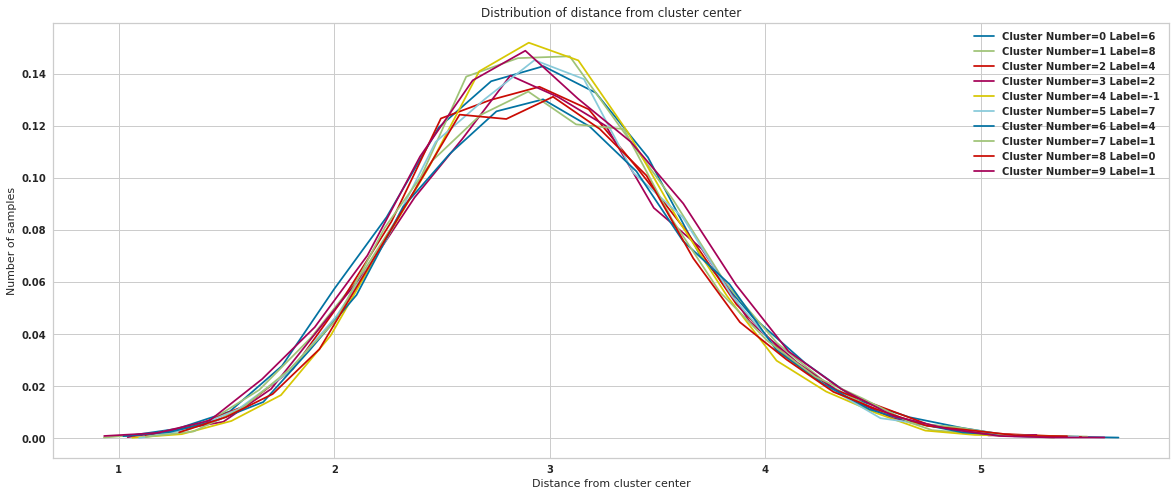

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

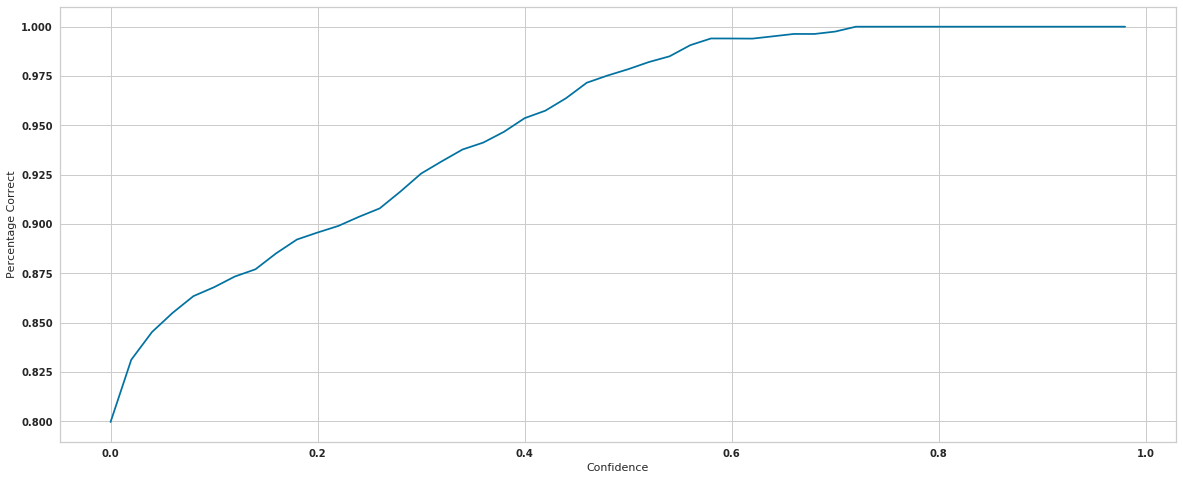

In [ ]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

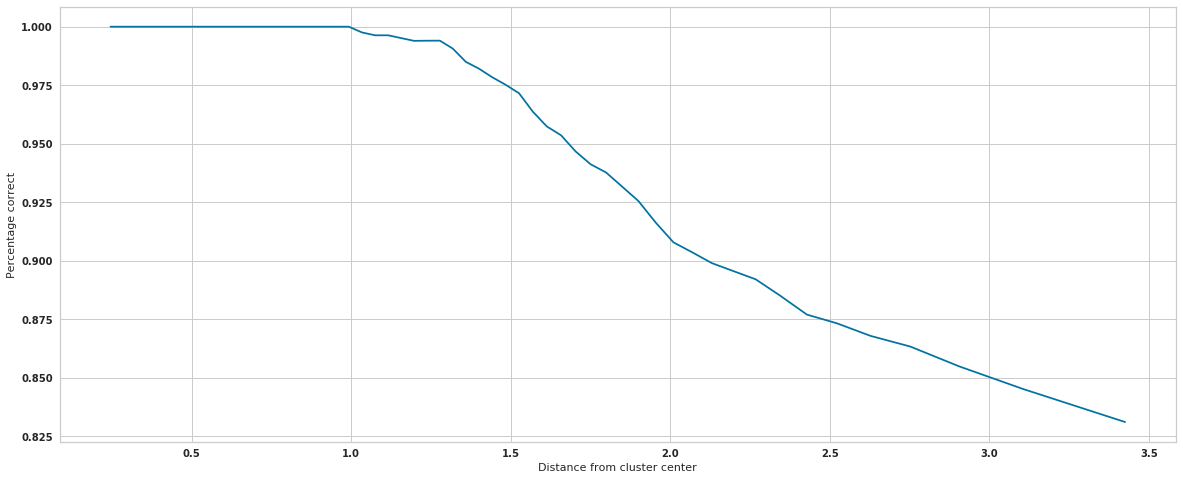

In [ ]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

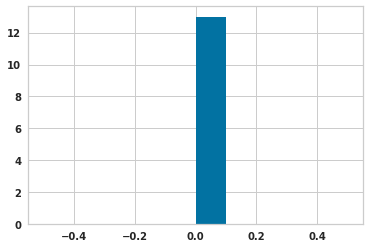

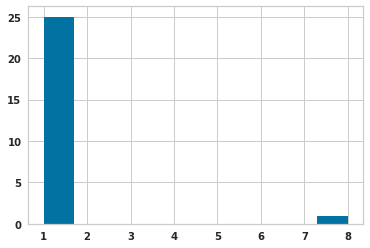

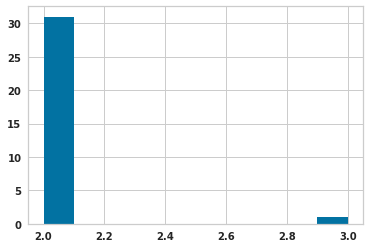

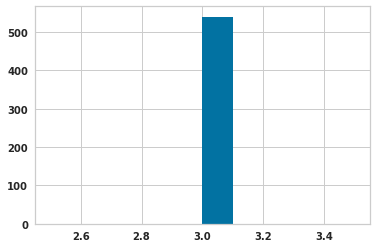

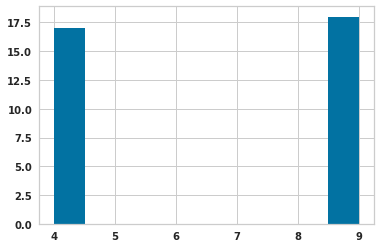

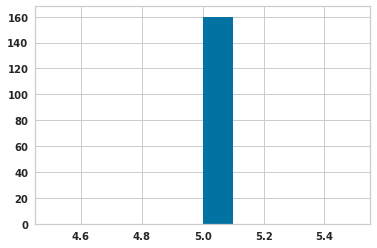

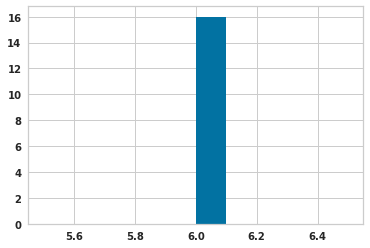

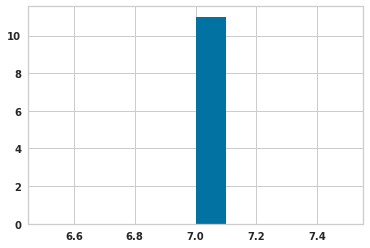

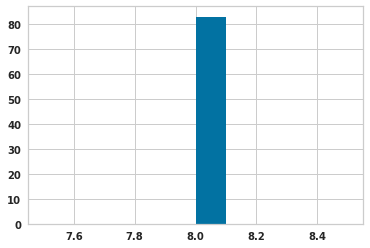

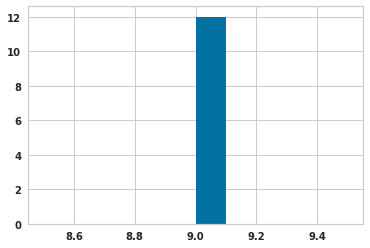

In [ ]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [ ]:
# manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

# manual_annotation_df = None
# if os.path.isfile(manual_annotation_file):
#     print("Reading existing manual annotation file")
#     manual_annotation_df = pd.read_csv(manual_annotation_file)

# epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

# if manual_annotation_df is not None:
#     manual_annotation_df[epoch_col_label] = df["manual_annotation"]
#     manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
# else:
#     print("No existing manual annotation file. Creating new manual annotation dataframe")
#     manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
#     manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

# all_columns = list(manual_annotation_df.columns)
# previous_epochs_completed = []
# for i in range(int(epochs_completed) + 1):
#     epoch_col_label = f"manual_label_{i}"
#     print(epoch_col_label)
#     if epoch_col_label in all_columns:
#         previous_epochs_completed.append(i)


# manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
#                                                                                        previous_epochs_completed),
#                                                      axis=1)
# manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
#                                                                                                   previous_epochs_completed),
#                                                                 axis=1)

        

# manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4


# Iteration 4

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [ ]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        root_path=root_path,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100'}
Loaded manual annotation
Number of samples with manual confidence 59840
Total Manual 

Epoch: 4/62, Nll_loss : 135.28256225585938 KLD:9.044719696044922  Supervised loss:0.1216571033000946
Epoch: 4/63, Nll_loss : 124.02976989746094 KLD:8.643427848815918  Supervised loss:0.15454813838005066
Epoch: 4/64, Nll_loss : 124.6873779296875 KLD:8.469511032104492  Supervised loss:0.1418304145336151
Epoch: 4/65, Nll_loss : 132.67391967773438 KLD:8.842475891113281  Supervised loss:0.13493329286575317
Epoch: 4/66, Nll_loss : 114.263427734375 KLD:8.974178314208984  Supervised loss:0.12764643132686615
Epoch: 4/67, Nll_loss : 117.47048950195312 KLD:8.597637176513672  Supervised loss:0.19769418239593506
Epoch: 4/68, Nll_loss : 124.01310729980469 KLD:9.345407485961914  Supervised loss:0.09545377641916275
Epoch: 4/69, Nll_loss : 132.42431640625 KLD:9.20553970336914  Supervised loss:0.13554221391677856
Epoch: 4/70, Nll_loss : 118.34683227539062 KLD:9.347724914550781  Supervised loss:0.10523276776075363
Epoch: 4/71, Nll_loss : 119.77781677246094 KLD:9.453065872192383  Supervised loss:0.0580960

Epoch: 4/145, Nll_loss : 124.44094848632812 KLD:8.248893737792969  Supervised loss:0.1997237205505371
Epoch: 4/146, Nll_loss : 116.06401062011719 KLD:8.604009628295898  Supervised loss:0.15046405792236328
Epoch: 4/147, Nll_loss : 127.92007446289062 KLD:8.722587585449219  Supervised loss:0.10944145917892456
Epoch: 4/148, Nll_loss : 133.31727600097656 KLD:8.772294998168945  Supervised loss:0.18500864505767822
Epoch: 4/149, Nll_loss : 118.34037017822266 KLD:8.840253829956055  Supervised loss:0.1121819019317627
Epoch: 4/150, Nll_loss : 132.09286499023438 KLD:9.484209060668945  Supervised loss:0.1169169619679451
Epoch: 4/151, Nll_loss : 120.31636047363281 KLD:9.200599670410156  Supervised loss:0.11683642864227295
Epoch: 4/152, Nll_loss : 123.97077941894531 KLD:8.761996269226074  Supervised loss:0.11364877223968506
Epoch: 4/153, Nll_loss : 116.14730834960938 KLD:9.473921775817871  Supervised loss:0.1205996498465538
Epoch: 4/154, Nll_loss : 125.92130279541016 KLD:8.929550170898438  Supervised

Epoch: 4/226, Nll_loss : 122.53898620605469 KLD:8.742542266845703  Supervised loss:0.1432991623878479
Epoch: 4/227, Nll_loss : 122.78282165527344 KLD:8.523862838745117  Supervised loss:0.0771464854478836
Epoch: 4/228, Nll_loss : 127.89109802246094 KLD:8.575456619262695  Supervised loss:0.13344117999076843
Epoch: 4/229, Nll_loss : 124.86324310302734 KLD:8.75681209564209  Supervised loss:0.14790856838226318
Epoch: 4/230, Nll_loss : 129.86026000976562 KLD:8.267496109008789  Supervised loss:0.11094401031732559
Epoch: 4/231, Nll_loss : 131.96746826171875 KLD:8.524497985839844  Supervised loss:0.13902926445007324
Epoch: 4/232, Nll_loss : 124.35701751708984 KLD:8.279818534851074  Supervised loss:0.11133734881877899
Epoch: 4/233, Nll_loss : 124.94204711914062 KLD:8.900540351867676  Supervised loss:0.07083815336227417
Epoch: 4/234, Nll_loss : 127.65239715576172 KLD:8.969356536865234  Supervised loss:0.15146318078041077
Epoch: 4/235, Nll_loss : 124.22431182861328 KLD:9.137307167053223  Supervise

Epoch: 4/307, Nll_loss : 120.89549255371094 KLD:8.728147506713867  Supervised loss:0.11375856399536133
Epoch: 4/308, Nll_loss : 131.40798950195312 KLD:9.083209991455078  Supervised loss:0.1609225869178772
Epoch: 4/309, Nll_loss : 118.31007385253906 KLD:8.966764450073242  Supervised loss:0.09846784174442291
Epoch: 4/310, Nll_loss : 133.82968139648438 KLD:8.867833137512207  Supervised loss:0.08106033504009247
Epoch: 4/311, Nll_loss : 131.98793029785156 KLD:9.190468788146973  Supervised loss:0.08556213229894638
Epoch: 4/312, Nll_loss : 130.5517578125 KLD:9.537199020385742  Supervised loss:0.2508227527141571
Epoch: 4/313, Nll_loss : 127.49950408935547 KLD:8.854299545288086  Supervised loss:0.08973798155784607
Epoch: 4/314, Nll_loss : 114.53306579589844 KLD:9.286869049072266  Supervised loss:0.05109565705060959
Epoch: 4/315, Nll_loss : 118.5078125 KLD:9.240283966064453  Supervised loss:0.11691637337207794
Epoch: 4/316, Nll_loss : 120.3128662109375 KLD:9.490944862365723  Supervised loss:0.09

Epoch: 4/388, Nll_loss : 122.27217102050781 KLD:9.12147331237793  Supervised loss:0.07170383632183075
Epoch: 4/389, Nll_loss : 124.00479125976562 KLD:9.110342025756836  Supervised loss:0.13002654910087585
Epoch: 4/390, Nll_loss : 129.453857421875 KLD:9.054386138916016  Supervised loss:0.1263769119977951
Epoch: 4/391, Nll_loss : 116.14612579345703 KLD:8.911863327026367  Supervised loss:0.14901681244373322
Epoch: 4/392, Nll_loss : 117.04607391357422 KLD:9.307357788085938  Supervised loss:0.10419004410505295
Epoch: 4/393, Nll_loss : 129.96295166015625 KLD:9.162272453308105  Supervised loss:0.08217039704322815
Epoch: 4/394, Nll_loss : 125.72425842285156 KLD:9.28856086730957  Supervised loss:0.1330256462097168
Epoch: 4/395, Nll_loss : 119.16918182373047 KLD:9.072856903076172  Supervised loss:0.14783942699432373
Epoch: 4/396, Nll_loss : 117.28651428222656 KLD:9.730588912963867  Supervised loss:0.07451366633176804
Epoch: 4/397, Nll_loss : 114.94098663330078 KLD:9.15573501586914  Supervised lo

Epoch: 4/469, Nll_loss : 123.20964050292969 KLD:8.399029731750488  Supervised loss:0.09631025791168213
Epoch: 4/470, Nll_loss : 121.94363403320312 KLD:8.510425567626953  Supervised loss:0.061994798481464386
Epoch: 4/471, Nll_loss : 122.667724609375 KLD:8.314901351928711  Supervised loss:0.05956198647618294
Epoch: 4/472, Nll_loss : 128.64512634277344 KLD:8.288374900817871  Supervised loss:0.16241797804832458
Epoch: 4/473, Nll_loss : 121.47775268554688 KLD:8.490930557250977  Supervised loss:0.12061184644699097
Epoch: 4/474, Nll_loss : 121.65458679199219 KLD:8.448070526123047  Supervised loss:0.10376253724098206
Epoch: 4/475, Nll_loss : 125.3270034790039 KLD:8.920555114746094  Supervised loss:0.11653053015470505
Epoch: 4/476, Nll_loss : 120.33616638183594 KLD:8.951175689697266  Supervised loss:0.082654669880867
Epoch: 4/477, Nll_loss : 122.46730041503906 KLD:9.215486526489258  Supervised loss:0.06600165367126465
Epoch: 4/478, Nll_loss : 119.16548919677734 KLD:9.075384140014648  Supervised

Epoch: 4/550, Nll_loss : 118.849853515625 KLD:9.008752822875977  Supervised loss:0.08721768856048584
Epoch: 4/551, Nll_loss : 121.33271789550781 KLD:8.851840019226074  Supervised loss:0.11434683948755264
Epoch: 4/552, Nll_loss : 118.56954956054688 KLD:8.57091999053955  Supervised loss:0.09062771499156952
Epoch: 4/553, Nll_loss : 123.61897277832031 KLD:9.128107070922852  Supervised loss:0.09309571981430054
Epoch: 4/554, Nll_loss : 125.82151794433594 KLD:8.482571601867676  Supervised loss:0.2114787995815277
Epoch: 4/555, Nll_loss : 123.43325805664062 KLD:9.168020248413086  Supervised loss:0.11266746371984482
Epoch: 4/556, Nll_loss : 129.8604736328125 KLD:9.200010299682617  Supervised loss:0.1165471002459526
Epoch: 4/557, Nll_loss : 119.46533966064453 KLD:9.159562110900879  Supervised loss:0.05299374833703041
Epoch: 4/558, Nll_loss : 119.48236083984375 KLD:9.07934284210205  Supervised loss:0.07382558286190033
Epoch: 4/559, Nll_loss : 121.1256332397461 KLD:9.389839172363281  Supervised los

Epoch: 4/631, Nll_loss : 116.36921691894531 KLD:8.739352226257324  Supervised loss:0.16053929924964905
Epoch: 4/632, Nll_loss : 118.61666870117188 KLD:8.981932640075684  Supervised loss:0.1002267450094223
Epoch: 4/633, Nll_loss : 118.38921356201172 KLD:8.420289993286133  Supervised loss:0.1310858577489853
Epoch: 4/634, Nll_loss : 118.39164733886719 KLD:8.468890190124512  Supervised loss:0.12558245658874512
Epoch: 4/635, Nll_loss : 123.43753051757812 KLD:8.95484447479248  Supervised loss:0.08863882720470428
Epoch: 4/636, Nll_loss : 119.95281219482422 KLD:8.63810920715332  Supervised loss:0.07437492907047272
Epoch: 4/637, Nll_loss : 113.28030395507812 KLD:8.599069595336914  Supervised loss:0.13064253330230713
Epoch: 4/638, Nll_loss : 122.55855560302734 KLD:8.52210807800293  Supervised loss:0.07659991085529327
Epoch: 4/639, Nll_loss : 133.39608764648438 KLD:8.755885124206543  Supervised loss:0.06959487497806549
Epoch: 4/640, Nll_loss : 124.64874267578125 KLD:8.842941284179688  Supervised 

Epoch: 4/712, Nll_loss : 126.09375 KLD:9.370214462280273  Supervised loss:0.05953473970293999
Epoch: 4/713, Nll_loss : 121.8460693359375 KLD:8.978193283081055  Supervised loss:0.07393276691436768
Epoch: 4/714, Nll_loss : 117.80404663085938 KLD:9.257482528686523  Supervised loss:0.07876138389110565
Epoch: 4/715, Nll_loss : 122.09831237792969 KLD:8.073129653930664  Supervised loss:0.11917828023433685
Epoch: 4/716, Nll_loss : 123.34459686279297 KLD:8.149904251098633  Supervised loss:0.09174807369709015
Epoch: 4/717, Nll_loss : 129.62734985351562 KLD:8.559555053710938  Supervised loss:0.1779675930738449
Epoch: 4/718, Nll_loss : 116.25575256347656 KLD:8.36588191986084  Supervised loss:0.08360197395086288
Epoch: 4/719, Nll_loss : 124.15782165527344 KLD:8.95737075805664  Supervised loss:0.15429441630840302
Epoch: 4/720, Nll_loss : 119.64115142822266 KLD:9.082958221435547  Supervised loss:0.11253297328948975
Epoch: 4/721, Nll_loss : 121.15032958984375 KLD:9.081829071044922  Supervised loss:0.1

Epoch: 4/793, Nll_loss : 113.60769653320312 KLD:8.766225814819336  Supervised loss:0.19654154777526855
Epoch: 4/794, Nll_loss : 119.68807220458984 KLD:9.355932235717773  Supervised loss:0.07277680933475494
Epoch: 4/795, Nll_loss : 121.3956298828125 KLD:9.107398986816406  Supervised loss:0.1538318693637848
Epoch: 4/796, Nll_loss : 129.83517456054688 KLD:9.024473190307617  Supervised loss:0.1765504628419876
Epoch: 4/797, Nll_loss : 118.43133544921875 KLD:8.948034286499023  Supervised loss:0.07588401436805725
Epoch: 4/798, Nll_loss : 124.83067321777344 KLD:8.674437522888184  Supervised loss:0.14035609364509583
Epoch: 4/799, Nll_loss : 125.82612609863281 KLD:9.365345001220703  Supervised loss:0.07538259029388428
Epoch: 4/800, Nll_loss : 125.33829498291016 KLD:9.055084228515625  Supervised loss:0.14346861839294434
Epoch: 4/801, Nll_loss : 115.41156005859375 KLD:9.359664916992188  Supervised loss:0.08610396832227707
Epoch: 4/802, Nll_loss : 118.92124938964844 KLD:9.408660888671875  Supervise

Epoch: 4/874, Nll_loss : 120.69729614257812 KLD:9.226318359375  Supervised loss:0.10758224129676819
Epoch: 4/875, Nll_loss : 118.98343658447266 KLD:9.271045684814453  Supervised loss:0.11708967387676239
Epoch: 4/876, Nll_loss : 116.68136596679688 KLD:9.18126106262207  Supervised loss:0.1416158825159073
Epoch: 4/877, Nll_loss : 120.92721557617188 KLD:9.481073379516602  Supervised loss:0.04202437773346901
Epoch: 4/878, Nll_loss : 125.69407653808594 KLD:9.45244026184082  Supervised loss:0.08672425150871277
Epoch: 4/879, Nll_loss : 111.02037048339844 KLD:9.134809494018555  Supervised loss:0.16031062602996826
Epoch: 4/880, Nll_loss : 114.94954681396484 KLD:8.702966690063477  Supervised loss:0.10266335308551788
Epoch: 4/881, Nll_loss : 120.06409454345703 KLD:8.839900970458984  Supervised loss:0.09277947247028351
Epoch: 4/882, Nll_loss : 124.74317169189453 KLD:8.493589401245117  Supervised loss:0.14233137667179108
Epoch: 4/883, Nll_loss : 114.12052917480469 KLD:8.515743255615234  Supervised l

In [ ]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-4675"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-4675"
 
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassi

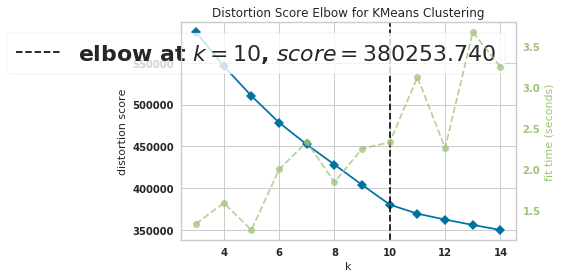

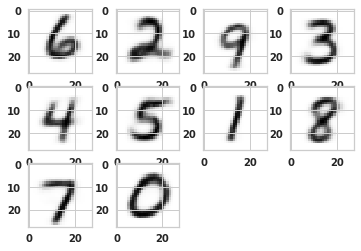

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [ ]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 2, 9, 3,
                                           4, 5, 1, 8,
                                           7, 0
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


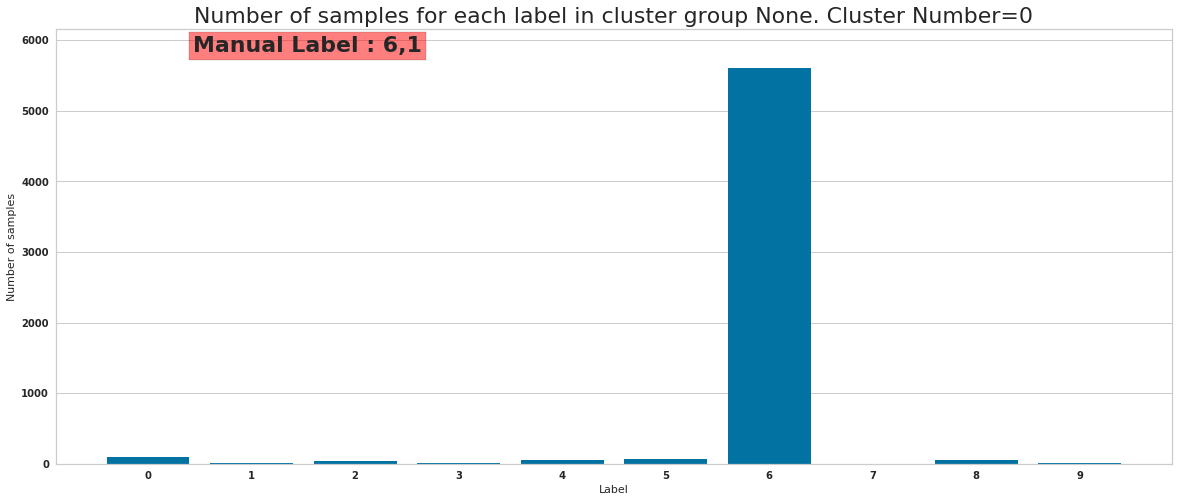

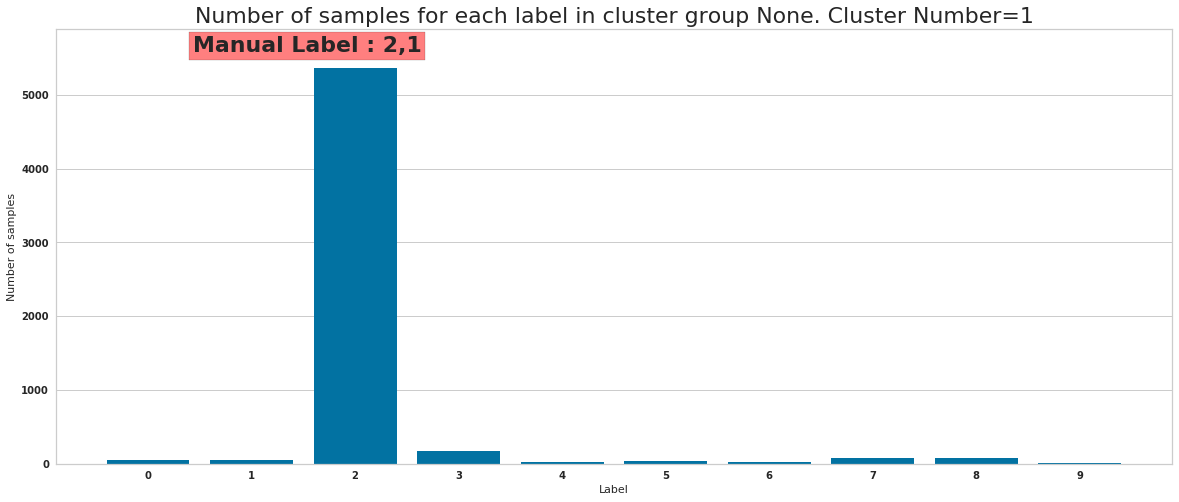

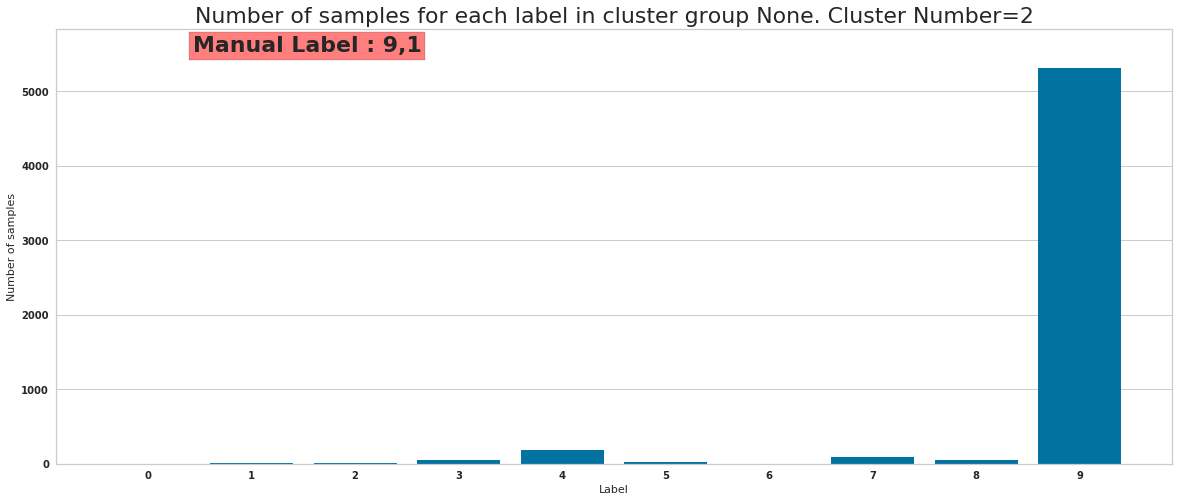

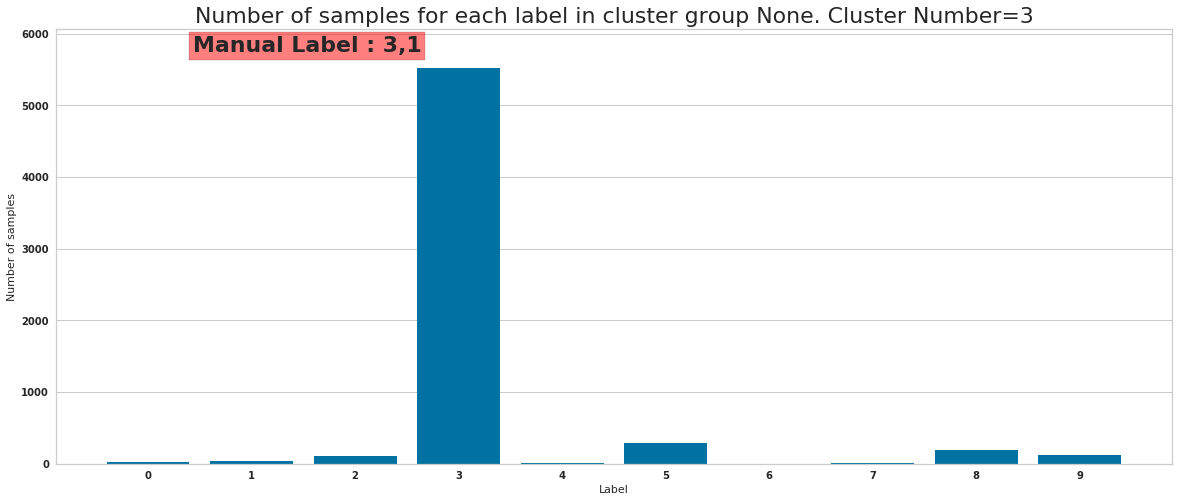

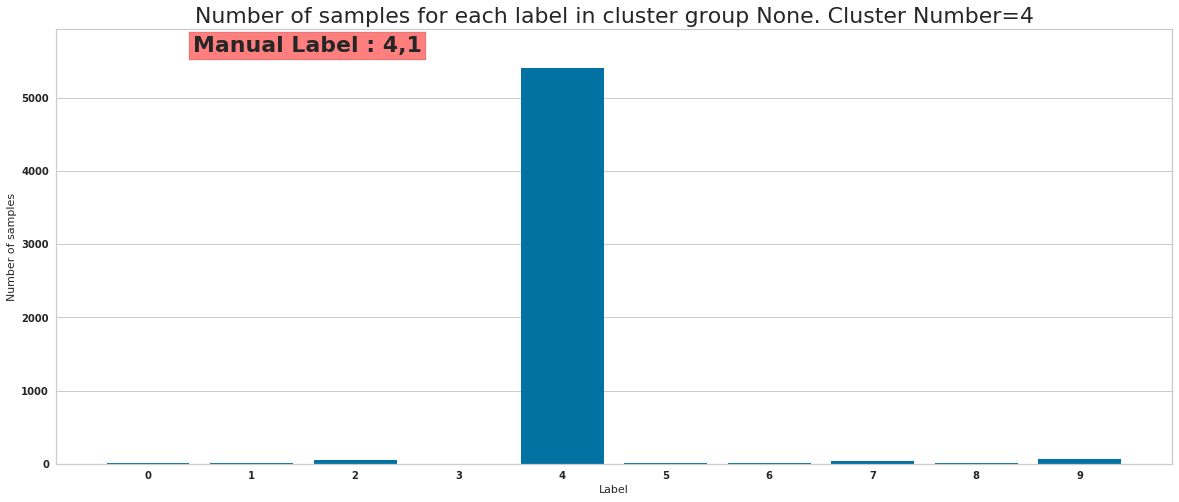

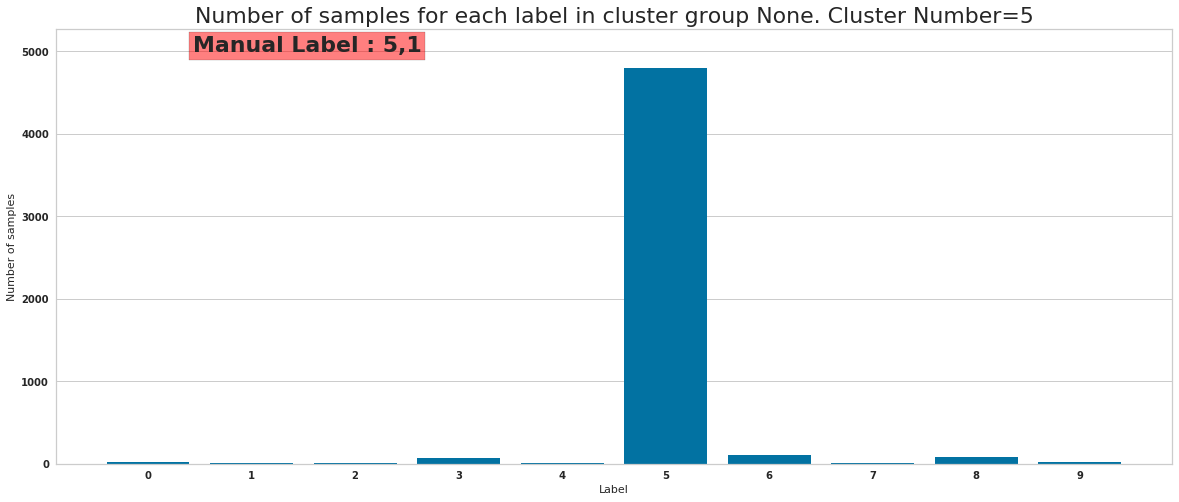

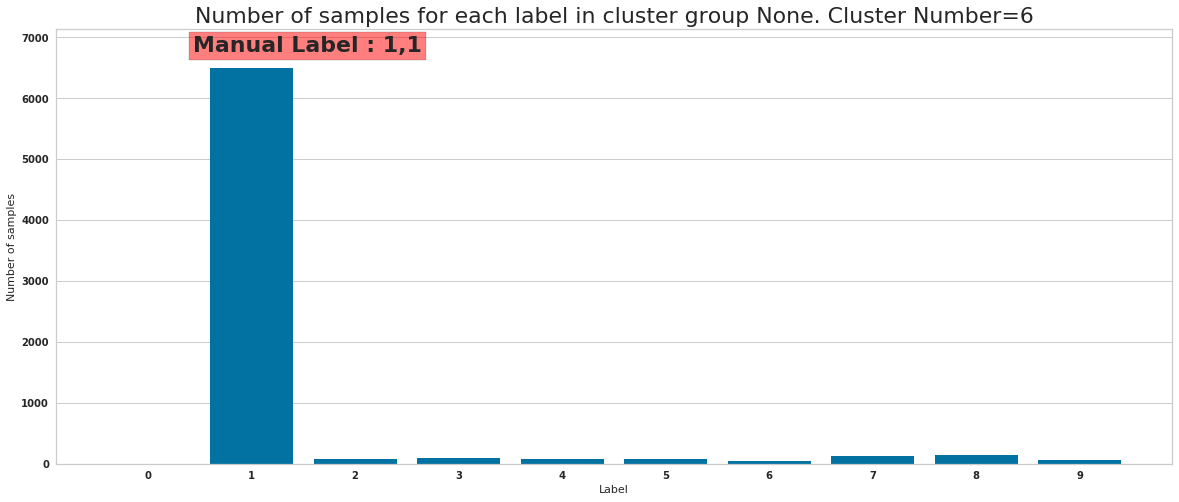

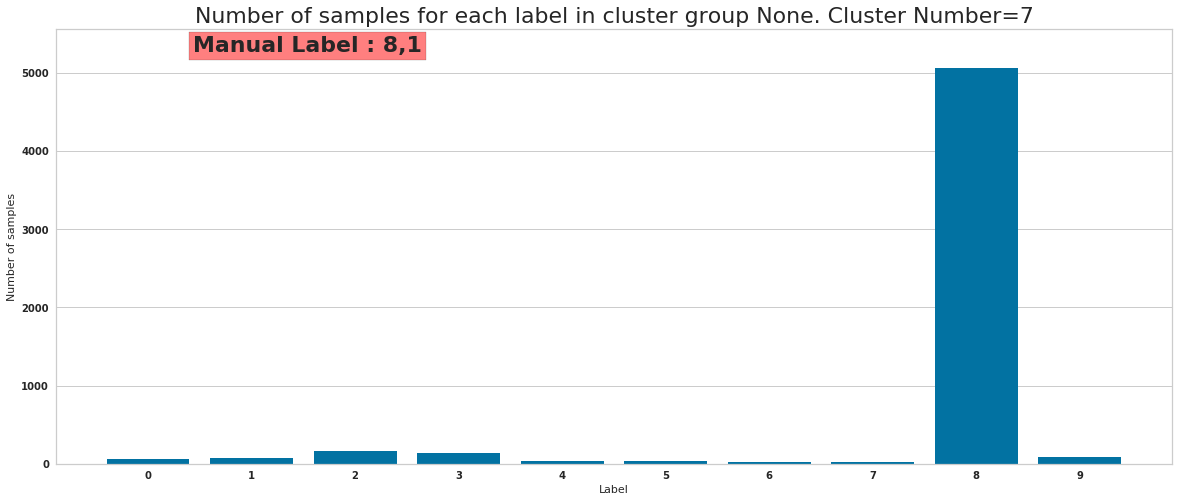

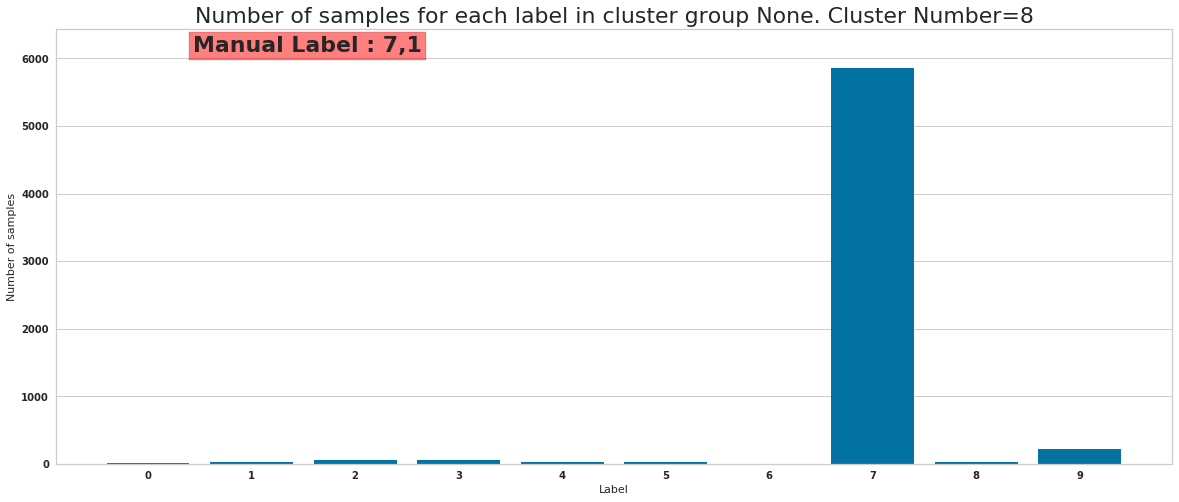

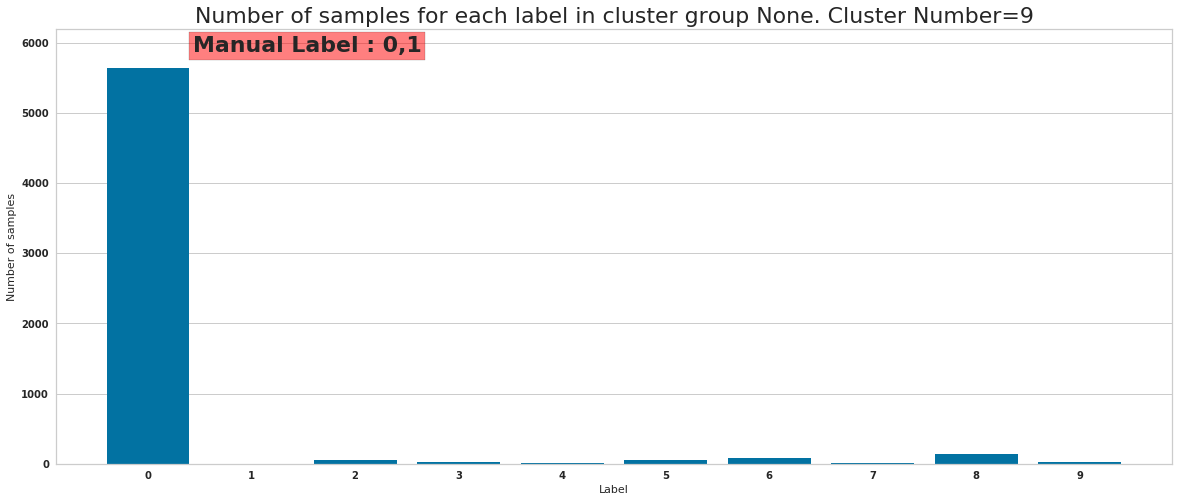

In [ ]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5946, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5885, 10)
(5712, 10)
(6303, 10)
(5623, 10)
(5107, 10)
(7202, 10)
(5694, 10)
(6304, 10)
(6064, 10)


In [ ]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5,0,-1,5,
#                                          5,8,1,5,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0.7,
#                                              0.8,0.8,0.9,0.7,
#                                              0,0]
# level2_manual_annotations[0] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [ ]:
print("Setting  next_level_clusters attribute to each primary cluster")
for cluster_id in level2_manual_annotations.keys():
    _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
    _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

print("Computing distances from second level cluster centers")
for cluster_id in level2_manual_annotations.keys():
    _cluster_centers =  level2_manual_annotations[cluster_id]["cluster_centers"]
    _cluster_labels = level2_manual_annotations[cluster_id]["cluster_labels"]

    print(cluster_id)

    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster, cluster_column_name_2)
    
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5946, 47) (5946, 33)
Num correct=5599
Cluster 0 Manual Label 6 Percentage correct 94.16414396232761
********************************
Manual Label 2
(5885, 47) (5885, 33)
Num correct=5357
Cluster 1 Manual Label 2 Percentage correct 91.02803738317758
********************************
Manual Label 9
(5712, 47) (5712, 33)
Num correct=5309
Cluster 2 Manual Label 9 Percentage correct 92.94467787114846
********************************
Manual Label 3
(6303, 47) (6303, 33)
Num correct=5513
Cluster 3 Manual Label 3 Percentage correct 87.46628589560527
********************************
Manual Label 4
(5623, 47) (5623, 33)
Num correct=5401
Cluster 4 Manual Label 4 Percentage correct 96.05192957495998
********************************
Manual Label 5
(5107, 47) (5107, 33)
Num correct=4792
Cluster 5 Manual Label 5 Percentage correct 93.83199530056785
********************************
Manual Label 1
(7202, 47) (7202, 33)
Num correct=6490
Cluster 6 Manual Label 1 Percentage correct 90.11385

In [ ]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)
    

Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5


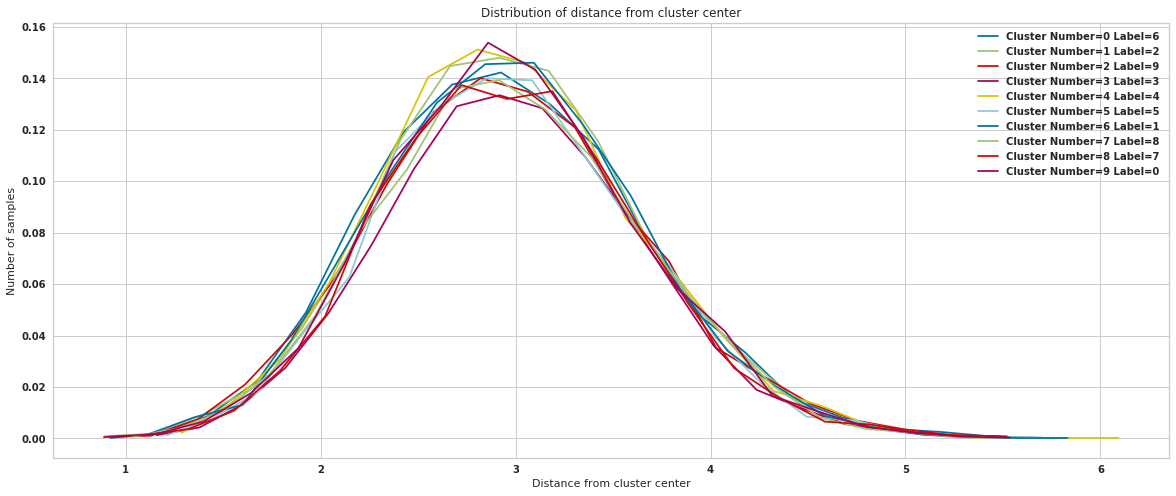

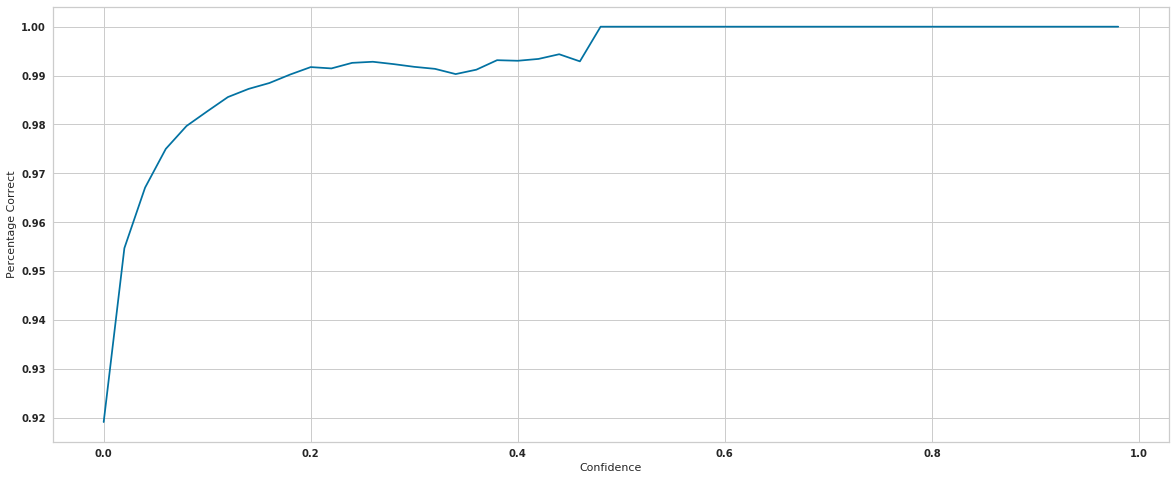

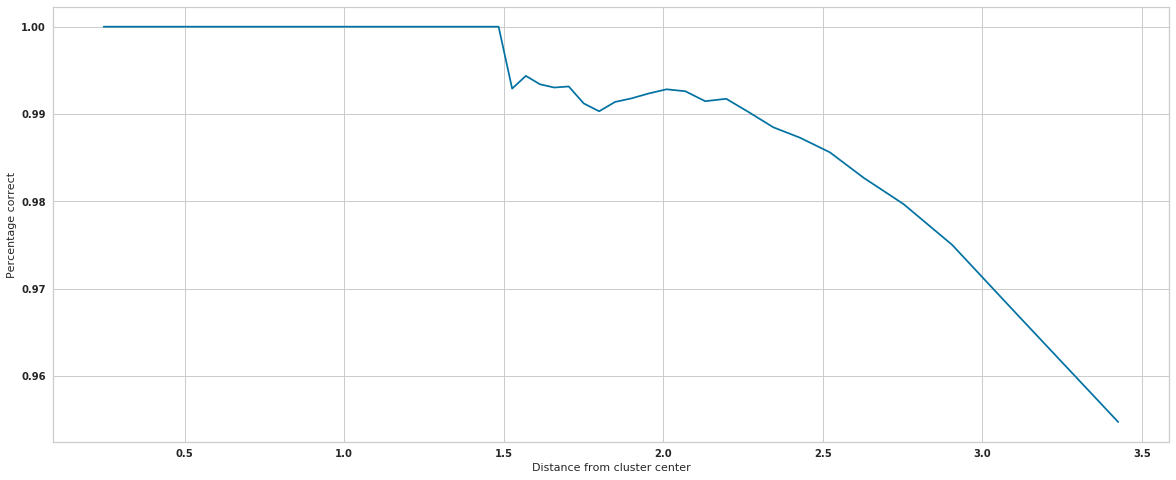

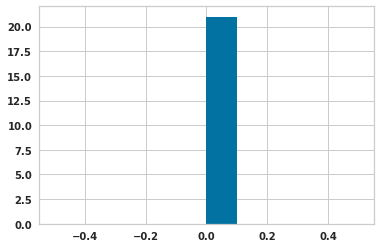

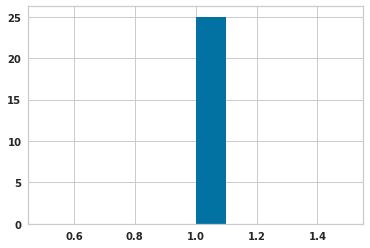

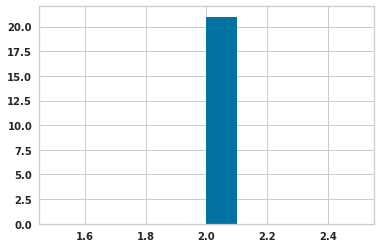

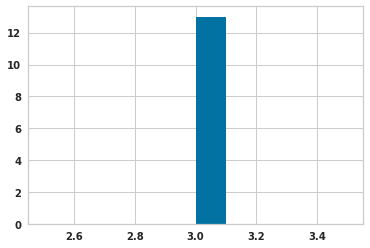

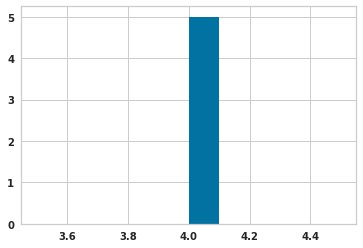

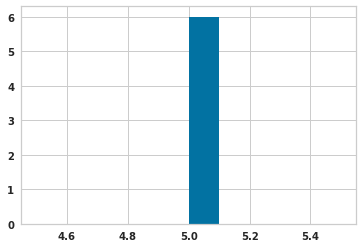

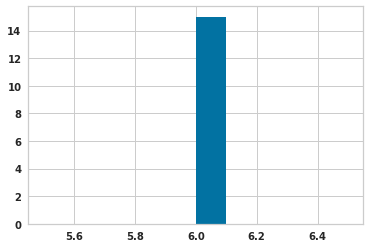

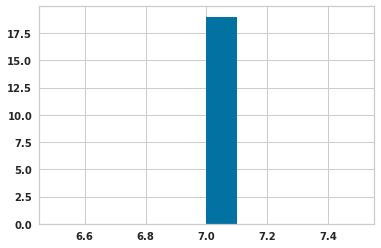

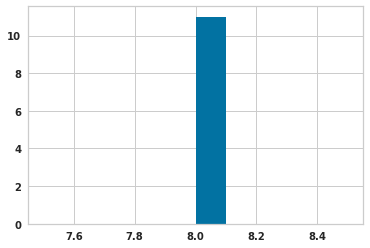

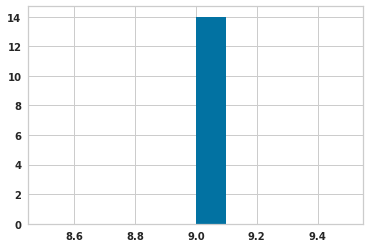

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)

In [ ]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'CLUSTERING_ALG': 'K_MEANS', 'CONFIDENCE_DECAY_FUNCTION': 'EXPONENTIAL', 'DISTANCE_METRIC': 'EUCLIDEAN', 'RUN_ID': 3, 'ID': 1, 'name': 'experiment_100'}
Loaded manual annotation
Number of samples with manual confidence 59840
Total Manual 

Epoch: 5/59, Nll_loss : 111.61788177490234 KLD:9.088159561157227  Supervised loss:0.05417248606681824
Epoch: 5/60, Nll_loss : 115.79315948486328 KLD:8.702409744262695  Supervised loss:0.06947515904903412
Epoch: 5/61, Nll_loss : 117.42604064941406 KLD:8.933220863342285  Supervised loss:0.06116904690861702
Epoch: 5/62, Nll_loss : 129.37258911132812 KLD:9.002828598022461  Supervised loss:0.12266169488430023
Epoch: 5/63, Nll_loss : 123.69046020507812 KLD:8.710203170776367  Supervised loss:0.06360460817813873
Epoch: 5/64, Nll_loss : 120.64274597167969 KLD:8.448593139648438  Supervised loss:0.1331559419631958
Epoch: 5/65, Nll_loss : 128.83384704589844 KLD:8.895086288452148  Supervised loss:0.06858313083648682
Epoch: 5/66, Nll_loss : 112.6038589477539 KLD:8.690878868103027  Supervised loss:0.14235293865203857
Epoch: 5/67, Nll_loss : 114.15841674804688 KLD:8.597795486450195  Supervised loss:0.08843020349740982
Epoch: 5/68, Nll_loss : 119.48324584960938 KLD:9.607580184936523  Supervised loss:0.

Epoch: 5/140, Nll_loss : 124.57300567626953 KLD:8.623085021972656  Supervised loss:0.08115904778242111
Epoch: 5/141, Nll_loss : 117.52374267578125 KLD:9.170135498046875  Supervised loss:0.050027668476104736
Epoch: 5/142, Nll_loss : 122.84747314453125 KLD:9.472845077514648  Supervised loss:0.030042337253689766
Epoch: 5/143, Nll_loss : 119.74153137207031 KLD:8.945484161376953  Supervised loss:0.036011483520269394
Epoch: 5/144, Nll_loss : 118.34994506835938 KLD:9.227313995361328  Supervised loss:0.05072108283638954
Epoch: 5/145, Nll_loss : 121.91752624511719 KLD:8.918920516967773  Supervised loss:0.15755680203437805
Epoch: 5/146, Nll_loss : 113.3624038696289 KLD:9.260428428649902  Supervised loss:0.0900251641869545
Epoch: 5/147, Nll_loss : 121.11781311035156 KLD:9.252828598022461  Supervised loss:0.06852227449417114
Epoch: 5/148, Nll_loss : 128.04541015625 KLD:9.155176162719727  Supervised loss:0.07719249278306961
Epoch: 5/149, Nll_loss : 118.25900268554688 KLD:8.959573745727539  Supervis

Epoch: 5/221, Nll_loss : 124.79086303710938 KLD:9.136449813842773  Supervised loss:0.11002184450626373
Epoch: 5/222, Nll_loss : 117.72090148925781 KLD:9.802797317504883  Supervised loss:0.05858031287789345
Epoch: 5/223, Nll_loss : 118.12289428710938 KLD:9.383636474609375  Supervised loss:0.05879110470414162
Epoch: 5/224, Nll_loss : 123.02070617675781 KLD:9.866223335266113  Supervised loss:0.036046352237463
Epoch: 5/225, Nll_loss : 122.84300994873047 KLD:9.286401748657227  Supervised loss:0.07156623899936676
Epoch: 5/226, Nll_loss : 122.78080749511719 KLD:8.903934478759766  Supervised loss:0.08827576786279678
Epoch: 5/227, Nll_loss : 122.96061706542969 KLD:8.66356086730957  Supervised loss:0.04754136875271797
Epoch: 5/228, Nll_loss : 122.12053680419922 KLD:8.621463775634766  Supervised loss:0.10268284380435944
Epoch: 5/229, Nll_loss : 120.30098724365234 KLD:9.002616882324219  Supervised loss:0.048923708498477936
Epoch: 5/230, Nll_loss : 127.72884368896484 KLD:8.512368202209473  Supervis

Epoch: 5/302, Nll_loss : 121.47338104248047 KLD:8.56035041809082  Supervised loss:0.10557463020086288
Epoch: 5/303, Nll_loss : 118.94413757324219 KLD:8.506406784057617  Supervised loss:0.03229079395532608
Epoch: 5/304, Nll_loss : 119.97886657714844 KLD:8.467291831970215  Supervised loss:0.09811464697122574
Epoch: 5/305, Nll_loss : 117.84013366699219 KLD:8.313929557800293  Supervised loss:0.05373622849583626
Epoch: 5/306, Nll_loss : 128.1526336669922 KLD:8.455135345458984  Supervised loss:0.14139455556869507
Epoch: 5/307, Nll_loss : 120.32748413085938 KLD:8.437850952148438  Supervised loss:0.047691334038972855
Epoch: 5/308, Nll_loss : 128.2603302001953 KLD:8.74821662902832  Supervised loss:0.09487420320510864
Epoch: 5/309, Nll_loss : 116.00363159179688 KLD:8.749080657958984  Supervised loss:0.04012115299701691
Epoch: 5/310, Nll_loss : 133.3558349609375 KLD:8.540639877319336  Supervised loss:0.05036713555455208
Epoch: 5/311, Nll_loss : 130.5484619140625 KLD:8.576020240783691  Supervised 

Epoch: 5/383, Nll_loss : 121.83404541015625 KLD:8.87635612487793  Supervised loss:0.09555321931838989
Epoch: 5/384, Nll_loss : 129.36907958984375 KLD:9.36922550201416  Supervised loss:0.08444125950336456
Epoch: 5/385, Nll_loss : 126.39973449707031 KLD:9.22337532043457  Supervised loss:0.04192245006561279
Epoch: 5/386, Nll_loss : 124.51182556152344 KLD:8.922582626342773  Supervised loss:0.06677713990211487
Epoch: 5/387, Nll_loss : 122.75232696533203 KLD:8.604145050048828  Supervised loss:0.06199958920478821
Epoch: 5/388, Nll_loss : 121.69742584228516 KLD:8.758613586425781  Supervised loss:0.02912319079041481
Epoch: 5/389, Nll_loss : 121.84725952148438 KLD:8.798996925354004  Supervised loss:0.1085490882396698
Epoch: 5/390, Nll_loss : 125.14759826660156 KLD:9.062137603759766  Supervised loss:0.09300099313259125
Epoch: 5/391, Nll_loss : 113.38066864013672 KLD:8.91248893737793  Supervised loss:0.07953643053770065
Epoch: 5/392, Nll_loss : 117.93997192382812 KLD:9.474313735961914  Supervised 

Epoch: 5/463, Nll_loss : 119.87710571289062 KLD:9.138181686401367  Supervised loss:0.07146058976650238
Epoch: 5/464, Nll_loss : 115.25125885009766 KLD:8.931400299072266  Supervised loss:0.0539669394493103
Epoch: 5/465, Nll_loss : 127.95883178710938 KLD:9.091374397277832  Supervised loss:0.10697896778583527
Epoch: 5/466, Nll_loss : 114.53729248046875 KLD:9.136763572692871  Supervised loss:0.03752158209681511
Epoch: 5/467, Nll_loss : 114.46503448486328 KLD:9.331149101257324  Supervised loss:0.06465737521648407
Epoch: 5/468, Nll_loss : 123.66847229003906 KLD:9.302206039428711  Supervised loss:0.09068021178245544
Epoch: 5/469, Nll_loss : 114.88675689697266 KLD:8.836101531982422  Supervised loss:0.07817717641592026
Epoch: 5/470, Nll_loss : 118.96006774902344 KLD:8.79511547088623  Supervised loss:0.04390258342027664
Epoch: 5/471, Nll_loss : 117.78260803222656 KLD:8.698540687561035  Supervised loss:0.040408775210380554
Epoch: 5/472, Nll_loss : 119.2166748046875 KLD:8.755109786987305  Supervis

Epoch: 5/544, Nll_loss : 123.88359069824219 KLD:9.121217727661133  Supervised loss:0.08103267103433609
Epoch: 5/545, Nll_loss : 123.15478515625 KLD:9.458808898925781  Supervised loss:0.1276039034128189
Epoch: 5/546, Nll_loss : 117.67667388916016 KLD:8.960906982421875  Supervised loss:0.18789340555667877
Epoch: 5/547, Nll_loss : 126.90253448486328 KLD:8.851310729980469  Supervised loss:0.060529924929142
Epoch: 5/548, Nll_loss : 115.77168273925781 KLD:8.765145301818848  Supervised loss:0.1341560184955597
Epoch: 5/549, Nll_loss : 116.69784545898438 KLD:8.823355674743652  Supervised loss:0.08925719559192657
Epoch: 5/550, Nll_loss : 117.38227844238281 KLD:8.958184242248535  Supervised loss:0.06502626836299896
Epoch: 5/551, Nll_loss : 121.00994873046875 KLD:8.739860534667969  Supervised loss:0.040542230010032654
Epoch: 5/552, Nll_loss : 114.26759338378906 KLD:8.53573989868164  Supervised loss:0.04643450304865837
Epoch: 5/553, Nll_loss : 118.06131744384766 KLD:9.055805206298828  Supervised lo

Epoch: 5/625, Nll_loss : 129.97320556640625 KLD:8.572389602661133  Supervised loss:0.06894996762275696
Epoch: 5/626, Nll_loss : 124.16905212402344 KLD:8.388021469116211  Supervised loss:0.0588180348277092
Epoch: 5/627, Nll_loss : 118.76052856445312 KLD:8.252077102661133  Supervised loss:0.12541304528713226
Epoch: 5/628, Nll_loss : 120.8075942993164 KLD:8.373397827148438  Supervised loss:0.04671095311641693
Epoch: 5/629, Nll_loss : 122.79823303222656 KLD:8.491937637329102  Supervised loss:0.052184928208589554
Epoch: 5/630, Nll_loss : 120.62215423583984 KLD:8.866143226623535  Supervised loss:0.033812738955020905
Epoch: 5/631, Nll_loss : 117.31217193603516 KLD:8.873504638671875  Supervised loss:0.06444144248962402
Epoch: 5/632, Nll_loss : 114.13070678710938 KLD:9.206629753112793  Supervised loss:0.04375779256224632
Epoch: 5/633, Nll_loss : 114.6007080078125 KLD:8.85753345489502  Supervised loss:0.051544416695833206
Epoch: 5/634, Nll_loss : 118.1336669921875 KLD:8.979195594787598  Supervis

Epoch: 5/706, Nll_loss : 112.80999755859375 KLD:9.44311809539795  Supervised loss:0.04990626871585846
Epoch: 5/707, Nll_loss : 118.21176147460938 KLD:9.36351490020752  Supervised loss:0.0682893842458725
Epoch: 5/708, Nll_loss : 108.14481353759766 KLD:8.713857650756836  Supervised loss:0.05659542232751846
Epoch: 5/709, Nll_loss : 121.58059692382812 KLD:9.326972007751465  Supervised loss:0.06765492260456085
Epoch: 5/710, Nll_loss : 118.69914245605469 KLD:9.293743133544922  Supervised loss:0.042663924396038055
Epoch: 5/711, Nll_loss : 121.48451232910156 KLD:8.71844482421875  Supervised loss:0.18560943007469177
Epoch: 5/712, Nll_loss : 126.44661712646484 KLD:8.647533416748047  Supervised loss:0.04727816954255104
Epoch: 5/713, Nll_loss : 122.01492309570312 KLD:8.617990493774414  Supervised loss:0.04485645890235901
Epoch: 5/714, Nll_loss : 116.39508056640625 KLD:8.912803649902344  Supervised loss:0.04532556235790253
Epoch: 5/715, Nll_loss : 120.83424377441406 KLD:8.120050430297852  Supervise

Epoch: 5/787, Nll_loss : 123.1728515625 KLD:8.753719329833984  Supervised loss:0.15751484036445618
Epoch: 5/788, Nll_loss : 125.80506896972656 KLD:8.883750915527344  Supervised loss:0.07023602724075317
Epoch: 5/789, Nll_loss : 123.28333282470703 KLD:8.98857307434082  Supervised loss:0.07713110744953156
Epoch: 5/790, Nll_loss : 118.78609466552734 KLD:9.030984878540039  Supervised loss:0.06605690717697144
Epoch: 5/791, Nll_loss : 111.95184326171875 KLD:8.741172790527344  Supervised loss:0.13836945593357086
Epoch: 5/792, Nll_loss : 119.19743347167969 KLD:9.122163772583008  Supervised loss:0.08446819335222244
Epoch: 5/793, Nll_loss : 112.94395446777344 KLD:8.357626914978027  Supervised loss:0.16147300601005554
Epoch: 5/794, Nll_loss : 119.21284484863281 KLD:9.07327651977539  Supervised loss:0.04496738687157631
Epoch: 5/795, Nll_loss : 121.06634521484375 KLD:8.87172794342041  Supervised loss:0.12888096272945404
Epoch: 5/796, Nll_loss : 129.8693389892578 KLD:8.92416763305664  Supervised loss

Epoch: 5/869, Nll_loss : 121.7186279296875 KLD:8.93702507019043  Supervised loss:0.0777444988489151
Epoch: 5/870, Nll_loss : 127.25495910644531 KLD:9.134773254394531  Supervised loss:0.06051481142640114
Epoch: 5/871, Nll_loss : 118.88556671142578 KLD:8.510354995727539  Supervised loss:0.06478728353977203
Epoch: 5/872, Nll_loss : 114.5323486328125 KLD:8.899030685424805  Supervised loss:0.027453910559415817
Epoch: 5/873, Nll_loss : 120.41853332519531 KLD:8.64924430847168  Supervised loss:0.08194875717163086
Epoch: 5/874, Nll_loss : 121.24124145507812 KLD:9.034883499145508  Supervised loss:0.06647757440805435
Epoch: 5/875, Nll_loss : 120.18899536132812 KLD:9.008406639099121  Supervised loss:0.07197171449661255
Epoch: 5/876, Nll_loss : 113.3926773071289 KLD:9.059341430664062  Supervised loss:0.15222220122814178
Epoch: 5/877, Nll_loss : 119.35638427734375 KLD:9.313088417053223  Supervised loss:0.03424769267439842
Epoch: 5/878, Nll_loss : 124.70576477050781 KLD:9.373489379882812  Supervised 

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/experiment_100/Exp_32_128_64_10_ELBOW_3/trained_models/SemiSupervisedClassi

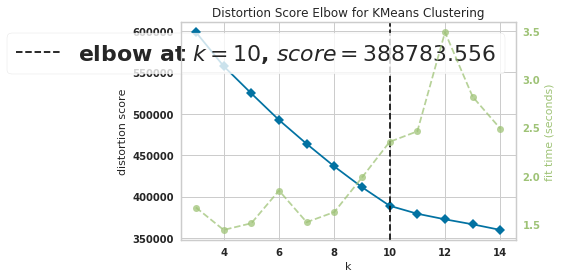

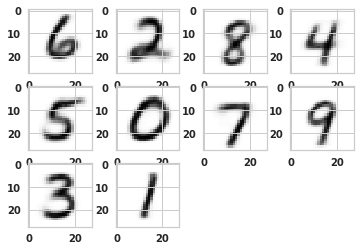

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors_gmm(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


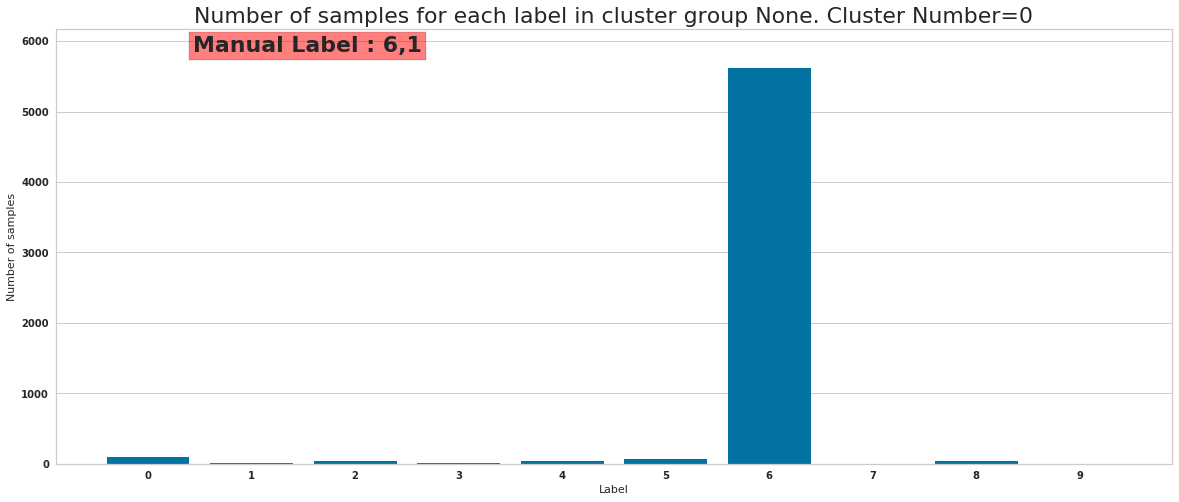

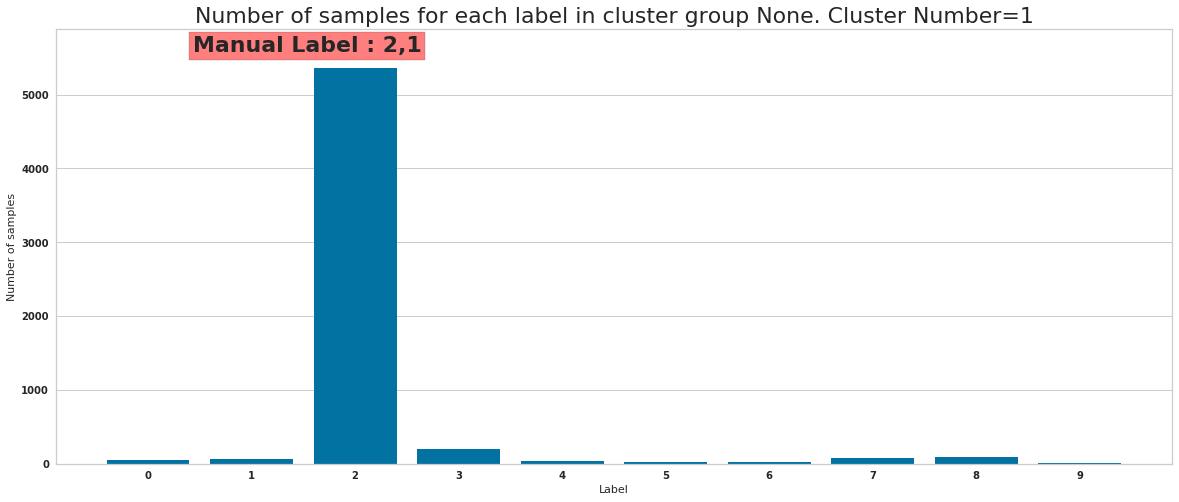

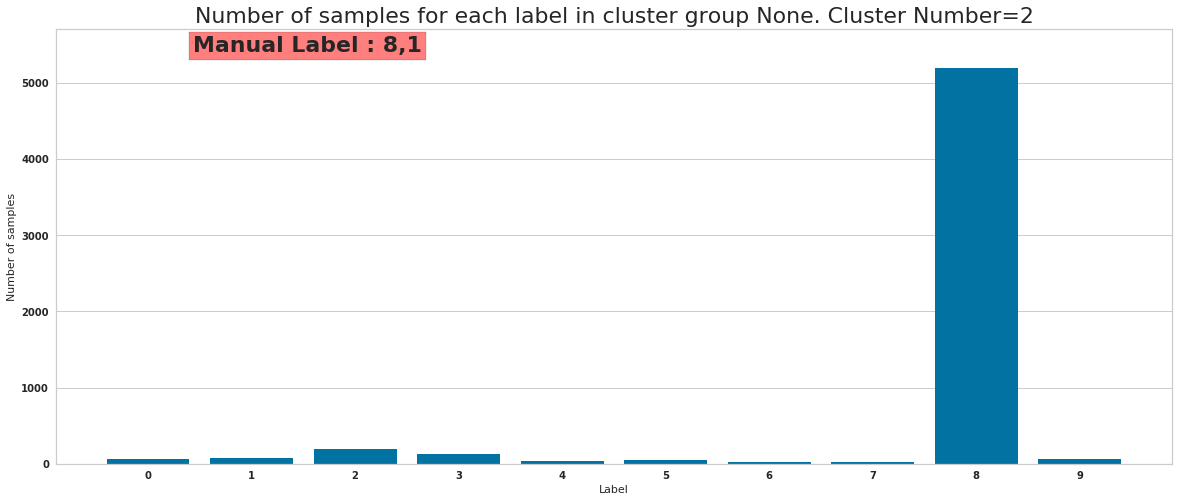

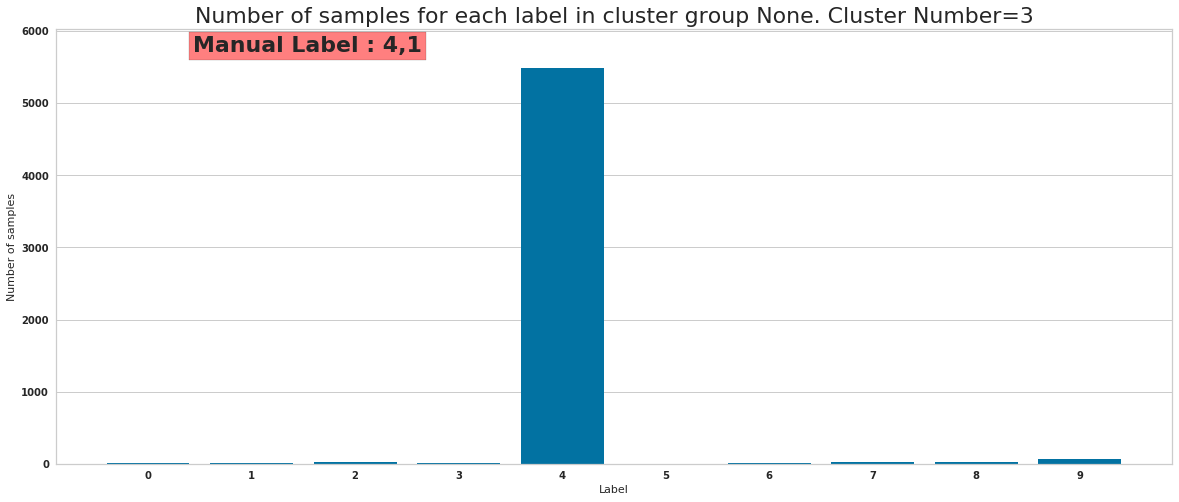

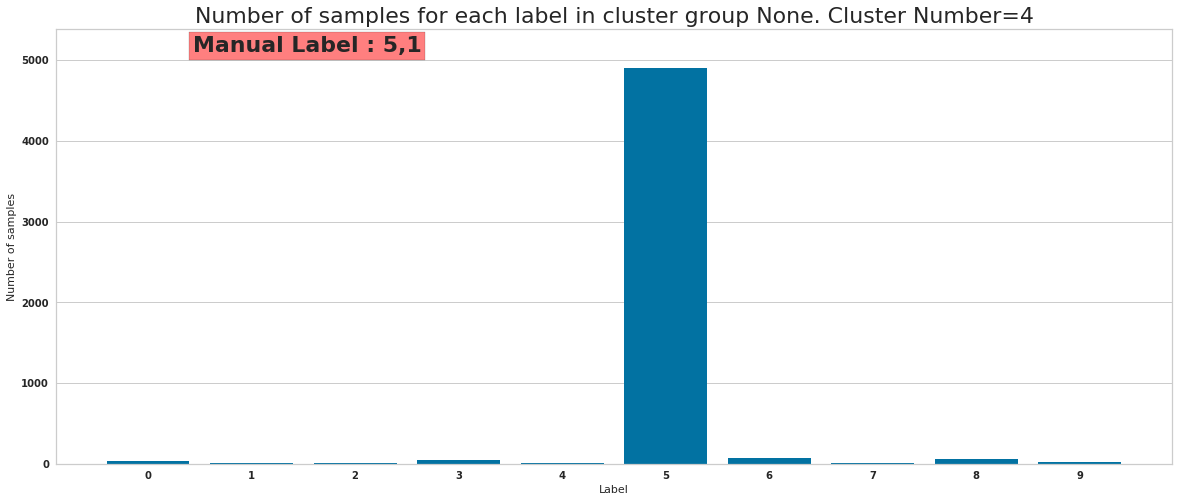

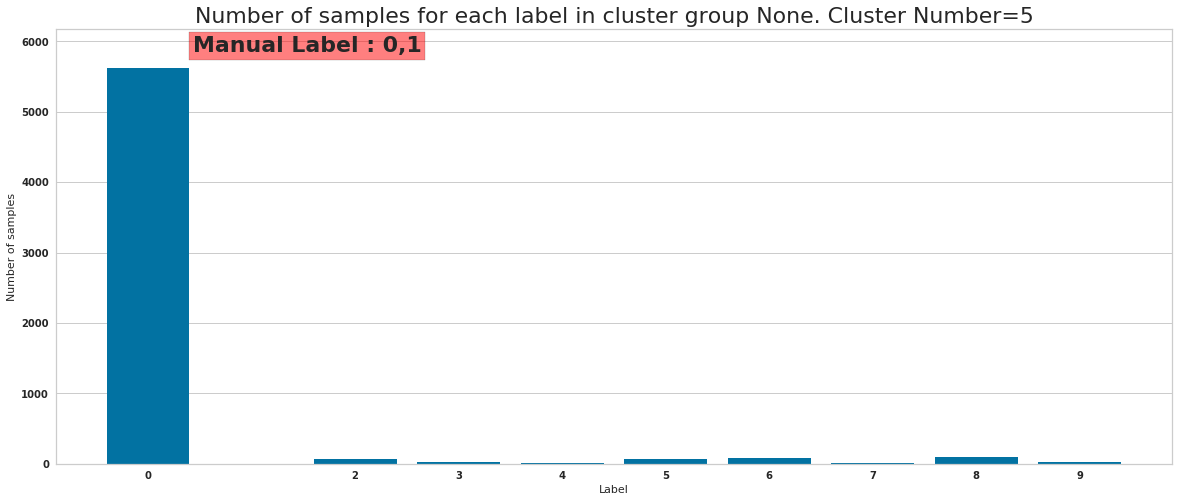

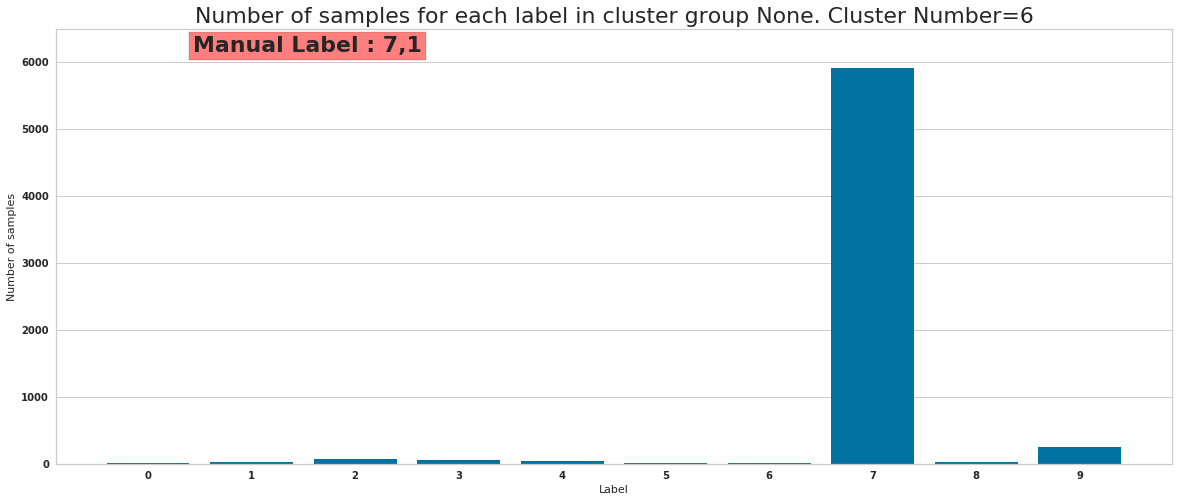

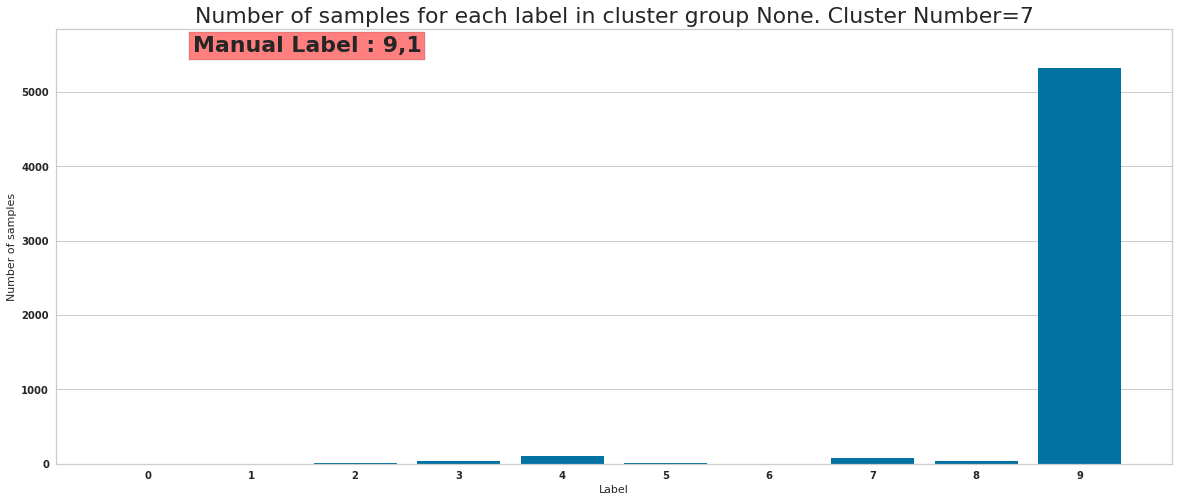

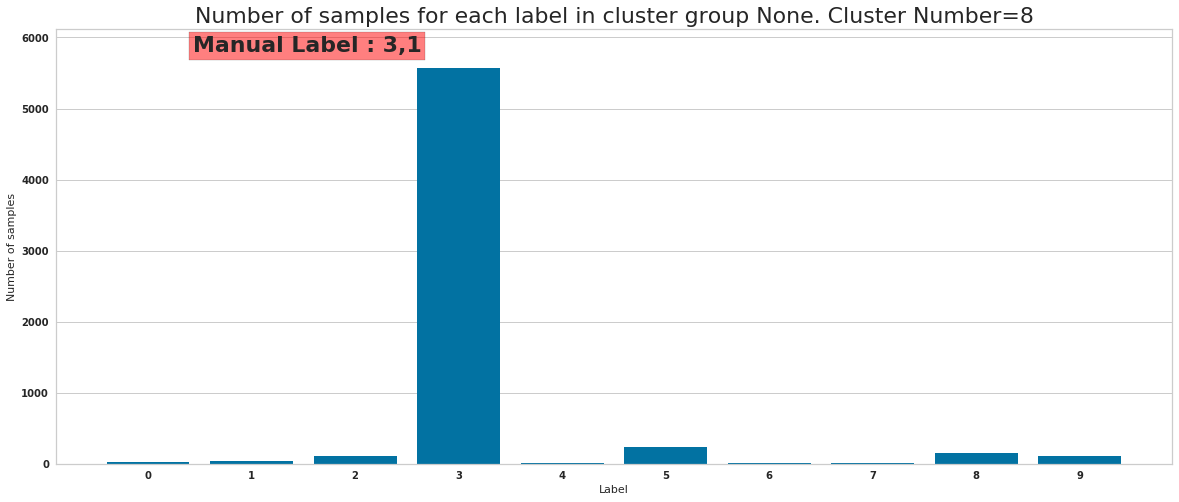

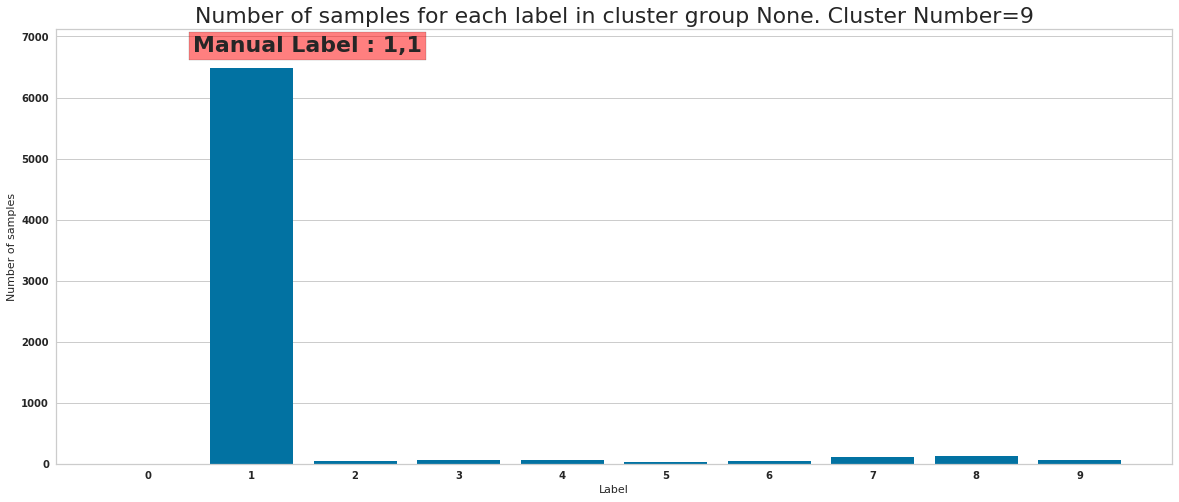

In [ ]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 2, 8, 4,
                                           5, 0, 7, 9,
                                           3, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level_gmm(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5924, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5943, 10)
(5857, 10)
(5675, 10)
(5161, 10)
(6008, 10)
(6401, 10)
(5585, 10)
(6265, 10)
(7021, 10)


In [ ]:
level2_manual_annotations =dict()

# TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [ ]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster,cluster_column_name_2)    

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


num_individual_samples_annotated=assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5924, 47) (5924, 33)
Num correct=5611
Cluster 0 Manual Label 6 Percentage correct 94.71640783254557
********************************
Manual Label 2
(5943, 47) (5943, 33)
Num correct=5354
Cluster 1 Manual Label 2 Percentage correct 90.0891805485445
********************************
Manual Label 8
(5857, 47) (5857, 33)
Num correct=5190
Cluster 2 Manual Label 8 Percentage correct 88.61191736383815
********************************
Manual Label 4
(5675, 47) (5675, 33)
Num correct=5480
Cluster 3 Manual Label 4 Percentage correct 96.56387665198238
********************************
Manual Label 5
(5161, 47) (5161, 33)
Num correct=4896
Cluster 4 Manual Label 5 Percentage correct 94.86533617515985
********************************
Manual Label 0
(6008, 47) (6008, 33)
Num correct=5615
Cluster 5 Manual Label 0 Percentage correct 93.45872170439414
********************************
Manual Label 7
(6401, 47) (6401, 33)
Num correct=5904
Cluster 6 Manual Label 7 Percentage correct 92.235588

In [ ]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        

manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH, "manual_annotation.csv")

manual_annotation_df = None
if os.path.isfile(manual_annotation_file):
    print("Reading existing manual annotation file")
    manual_annotation_df = pd.read_csv(manual_annotation_file)

epoch_col_confidence, epoch_col_label = get_manual_annotation_col_name(epochs_completed)

if manual_annotation_df is not None:
    manual_annotation_df[epoch_col_label] = df["manual_annotation"]
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"]
else:
    print("No existing manual annotation file. Creating new manual annotation dataframe")
    manual_annotation_df = pd.DataFrame(data = df["manual_annotation"].values, columns=[epoch_col_label] )
    
    manual_annotation_df[epoch_col_confidence] = df["manual_annotation_confidence"].values

all_columns = list(manual_annotation_df.columns)
previous_epochs_completed = []
for i in range(int(epochs_completed) + 1):
    epoch_col_label = f"manual_label_{i}"
    print(epoch_col_label)
    if epoch_col_label in all_columns:
        previous_epochs_completed.append(i)


manual_annotation_df["manual_annotation"] = manual_annotation_df.apply(lambda row:get_overall_label(row,
                                                                                       previous_epochs_completed),
                                                     axis=1)
manual_annotation_df["manual_annotation_confidence"] = manual_annotation_df.apply(lambda row:get_overall_confidence(row,
                                                                                                  previous_epochs_completed),
                                                                axis=1)

        

manual_annotation_df.to_csv(manual_annotation_file, index=False)


Reading existing manual annotation file
manual_label_0
manual_label_1
manual_label_2
manual_label_3
manual_label_4
manual_label_5
manual_label_6


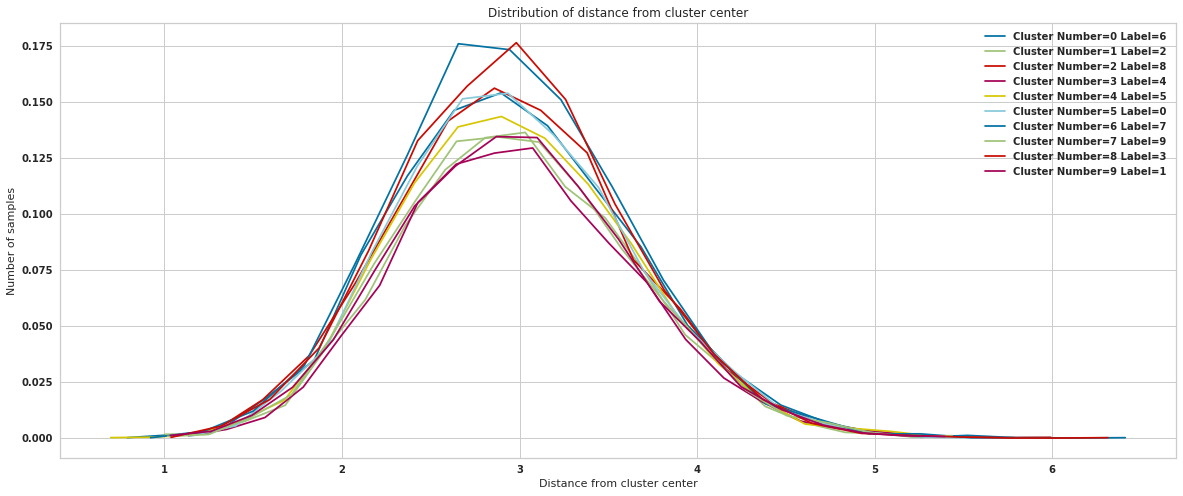

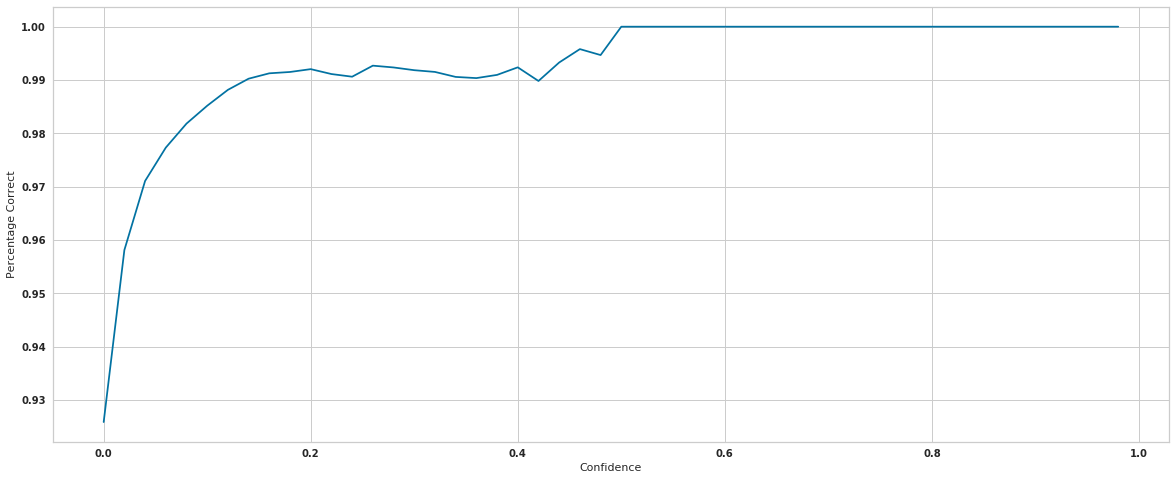

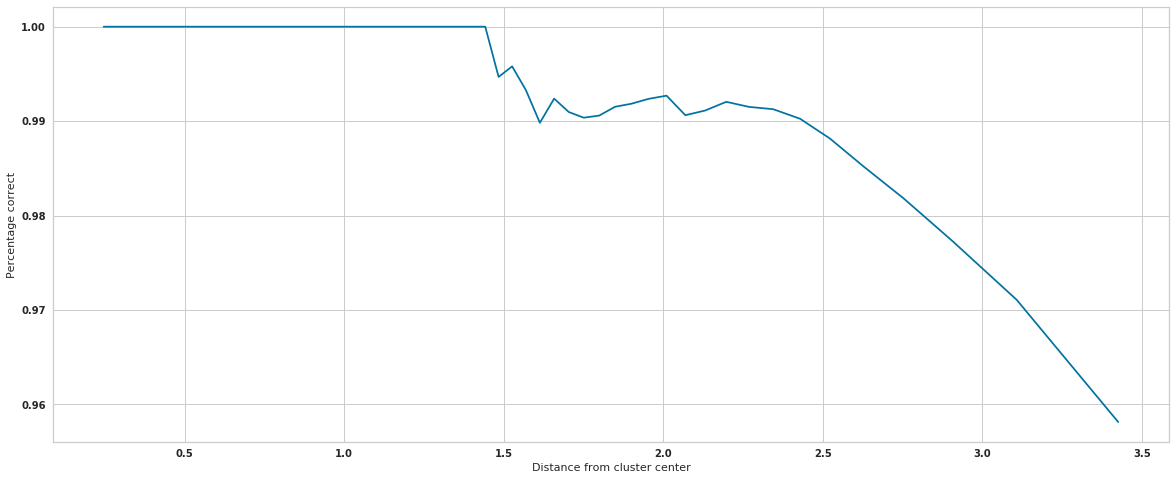

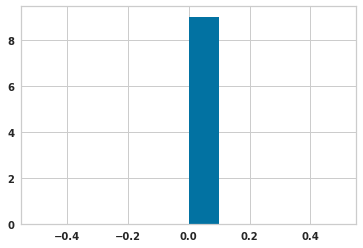

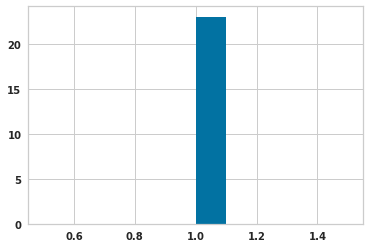

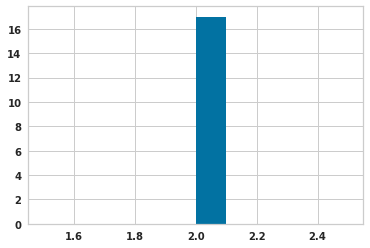

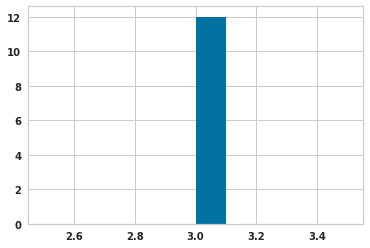

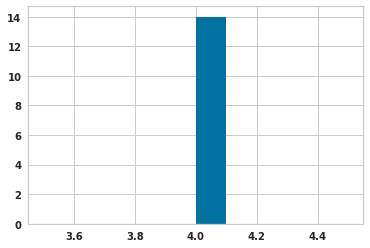

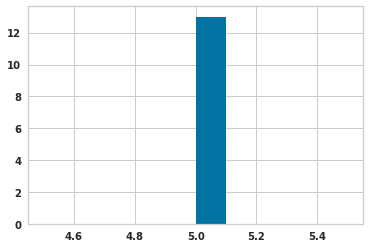

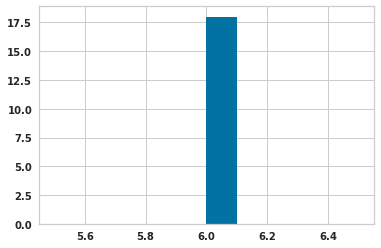

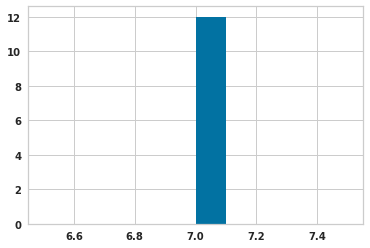

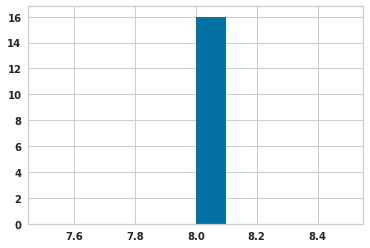

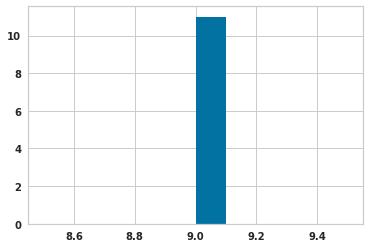

In [ ]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [ ]:
metric_file = os.path.join(exp_config.ANALYSIS_PATH, f"metrics_{int(epochs_completed)}.csv")
metric_df = pd.read_csv(metric_file)
metric_df.head()

num_samples_wrongly_annotated = get_num_samples_wrongly_annotated()
total_confidence_of_wrong_annotation = get_sum_confidence_wrong()

metric_df["num_individual_samples_annotated"] = [num_individual_samples_annotated] * metric_df.shape[0]
metric_df["num_samples_wrongly_annotated"] = [num_samples_wrongly_annotated] * metric_df.shape[0]
metric_df["total_confidence_of_wrong_annotation"] = [total_confidence_of_wrong_annotation] * metric_df.shape[0]



metric_df.head()
metric_df.to_csv(metric_file)
confidence_percent_correct_file_name = os.path.join(exp_config.ANALYSIS_PATH,
                                                    f"confidence_percent_correct_{num_epochs}.csv")
confidence_percent_correct_df = pd.DataFrame(confidence, columns=["confidence"])
confidence_percent_correct_df["percentage_correct"] = percentage_correct
confidence_percent_correct_df.to_csv(confidence_percent_correct_file_name)